# Imports and plot properties


In [4]:
"""
Created on Thu Feb  6 15:24:06 2020

@author: Shiva
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import pandas as pd
from pandas import read_excel
from matplotlib.font_manager import FontProperties
from scipy.ndimage.interpolation import shift
import os
import glob
import timeit
from scipy import stats
import statsmodels.stats.api as sms
from matplotlib.collections import LineCollection
from tempfile import TemporaryFile
import matplotlib.gridspec as gridspec
import seaborn as sns
from statannot import add_stat_annotation
# import numpy_indexed as npi
#print(os.path.dirname(__file__))
import itertools
import pickle
from pathlib import Path
import yaml
from ruamel.yaml import YAML
from os.path import dirname as up
import shutil
import fnmatch
flatten = itertools.chain.from_iterable

#############################   Plot properties   ########################################################


font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size('30')
font.set_weight('bold')

font_label = FontProperties()
font_label.set_family('serif')
font_label.set_name('Times New Roman')
font_label.set_style('italic')
font_label.set_size('25')
font_label.set_weight('bold')
def set_ticks(ax):
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20)
    ax.yaxis.set_ticks_position('left')


# Config file 

In [2]:
def create_config_template():
    """
    Creates a template for config.yaml file. This specific order is preserved while saving as yaml file.
    """

    yaml_str = """\
    # Project definitions (do not edit)
        \n
        Task:
        date:
        experimentor:
        \n
    # Project path (change when moving around)
        \n
        project_path: '/home/shiva/Desktop/Rat_Lever_Analysis'
        \n
    # Annotation data set configuration 
        \n
        body_part_list:
        exp_par: # optogentics, pharmacology, ...
        optogenetic_manip: # True, False
        r_or_l: # 'R' or 'L' the hand performing the task
        fp_trial: # number of frames per trial
        fps: # frame per second of video
        laser_duration: # ms. Laser duration in partial-MT protocol. 
        laser_delay: # delay of laser onset relative to pad-off
        laser_protocol: # all-RT, all-MT, prtial-MT,...
        laser_pulse: # beta, square,...
        laser_intensity: # mW
        \n
    # Plotting configuration 
        \n
        laser_on_color:
        laser_off_color:
        markersize:
        alphavalue:
        n_grid: # number of grids in x for averaging y among trials
        \n
    # Analysis configuration
        \n
        n_timebin:
        pad_length_cm: # length of pad in cm used to scale videos
        velocity_mask: # an arbitrary value to mask the unwanted timebins of trials
        \n
    # Cropping Parameters (varies according to croppings made during DLC analysis)
        \n
        frame_height: # pix
        \n
    # if Refinement
        \n
        if_refine:
        \n
    # Refinement configuration 
        \n
        max_speed: # cm/s. The max speed estimated for the animal 
        jitter_proximity_thresh_rho: #cm. the acceptable jitter in abs(r) vector to be considered the same jump
        jitter_proximity_thresh_phi: #rad. the acceptable jitter in the angel of r vector to be considered the same jump
        thresh_adjust: # if there are 5 jumped points the threshold is <jitter_proximity_thresh_rho>
        t_s: # number of timebins before and after for reference in jitter removal
        p_cutoff: # the DLC likelihood threshold for considering detections
        n_good_points_ratio:
        max_delta_r_per_frame: # cm/4ms
        cor_t_prox_thresh:  #number of frames more than which the low likelihood points are not allowd to be connected
        pad_thresh:
        window: # moving average window for position
        window_veloc: # moving average window for velocity
        """

    ruamelFile = YAML()
    cfg_file = ruamelFile.load(yaml_str)
    return cfg_file, ruamelFile
    
def read_config(configname):
    """
    Reads structured config file defining a project.
    """
    ruamelFile = YAML()
    path = Path(configname)
    if os.path.exists(path):
        try:
            with open(path, "r") as f:
                cfg = ruamelFile.load(f)
                curr_dir = os.path.dirname(configname)
                if cfg["project_path"] != curr_dir:
                    cfg["project_path"] = curr_dir
                    write_config(configname, cfg)
        except Exception as err:
            if len(err.args) > 2:
                if (
                    err.args[2]
                    == "could not determine a constructor for the tag '!!python/tuple'"
                ):
                    with open(path, "r") as ymlfile:
                        cfg = yaml.load(ymlfile, Loader=yaml.SafeLoader)
                        write_config(configname, cfg)
                else:
                    raise

    else:
        raise FileNotFoundError(
            "Config file is not found. Please make sure that the file exists and/or that you passed the path of the config file correctly!"
        )
    return cfg

def write_config(configname, cfg):
    """
    Write structured config file.
    """
#     write_plainconfig(configname, cfg)
    with open(configname, "w") as cf:
        cfg_file, ruamelFile = create_config_template()
        for key in cfg.keys():
            cfg_file[key] = cfg[key]

        # Adding default value for variable for backward compatibility.
        if not "skeleton" in cfg.keys():
            pass
        ruamelFile.dump(cfg_file, cf)

def edit_config(configname, edits):
    """
    Convenience function to edit and save a config file from a dictionary.
    Parameters
    ----------
    configname : string
        String containing the full path of the config file in the project.
    """
    cfg = read_plainconfig(configname)
    for key, value in edits.items():
        cfg[key] = value
    write_plainconfig(configname, cfg)
    return cfg

def read_plainconfig(configname):
    if not os.path.exists(configname):
        raise FileNotFoundError(
            f"Config {configname} is not found. Please make sure that the file exists."
        )
    with open(configname) as file:
        return YAML().load(file)

def write_plainconfig(configname, cfg):
    with open(configname, "w") as file:
        YAML().dump(cfg, file)
        
def set_config_file(folder,path): 
    cfg = {'Task': 'Rat_lever_press',
        'date':'01-05-2020',
        'body_part_list': ['finger0',  'finger1base', 'finger1joint', 'finger2base', 'finger2joint',
                           'forearm', 'elbow'],
        'laser_on_color': 'lightskyblue',
        'laser_off_color': 'k',
        'markersize': 5,
        'alphavalue': 0.5,
        'n_grid': 20,
        'n_timebin': 10,
        'pad_length_cm': 2,
        'fps': 250,
        'frame_height': 400,
        'if_refine': True,
        'max_speed': 100,
        'jitter_proximity_thresh_rho': 0.2,
        'jitter_proximity_thresh_phi': 30/180*np.pi,
        'thresh_adjust': 1/5,
        't_s': 4,
        'p_cutoff': 0.8,
        'n_good_points_ratio':1/4,
        'cor_t_prox_thresh':100,
        'pad_thresh':5,
        'window':10,
        'window_veloc':5,
        'velocity_mask': 2000,
        'laser_duration': 250,
        'laser_delay': 25}

    edits = {'max_delta_r_per_frame': cfg['max_speed']/cfg['fps']}


    configname = os.path.join(path, folder, 'config_'+folder+'.yaml')
    if not os.path.exists(configname):
        write_config(configname, cfg)
        edit_config(configname, edits)
    return configname


# configname = '/home/shiva/Desktop/Rat_Lever_Analysis/config.yaml'
# configname = set_config_file('Rat_Lever_Analysis','/home/shiva/Desktop')
# write_config(configname, cfg)
# edit_config(configname, edits)
# cfg = read_plainconfig(configname)

    
pre_direct = '/home/shiva/Desktop/Rat_Lever_Analysis' # ubuntu director

# Rat Functions

In [12]:
def attempt_to_make_folder(foldername):
    """ Attempts to create a folder with specified name. Does nothing if it already exists. """
    try:
        os.path.isdir(foldername)
    except TypeError:  # https://www.python.org/dev/peps/pep-0519/
        foldername = os.fspath(
            foldername
        )  # https://github.com/AlexEMG/DeepLabCut/issues/105 (cfg['window']s)

    if os.path.isdir(foldername):
        print(foldername, " already exists!")
    else:
        os.mkdir(foldername)
        
def read_pickle(filename):
    """ Read the pickle file """
    with open(filename, "rb") as handle:
        return pickle.load(handle)

def write_pickle(filename, data):
    """ Write the pickle file """
    with open(filename, "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_DLC_csv(file_name_pos,fp_trial):
    ''' Read DeepLab Cut Data and remove the <incomplete-trial> at the end'''
    
    df = pd.read_csv(file_name_pos, delimiter=",", header=[1,2])#*scale_pix_to_cm # scale to cm
    remainer = len(df.index)%fp_trial
    df = df.drop(np.arange(len(df.index)-remainer,len(df.index)))
    return df

def read_LED_csv(file_name_LED,DLC_end):
    ''' Read LED states from file and cut the <half-trial> at the end according to the DLC file size'''
    df = pd.read_csv(file_name_LED, delimiter=",")
    df = df.drop(np.arange(DLC_end,len(df.index)))
    return df

def drop_incomplete_trials(df,df_LED,fp_trial):
    ''' in case the number of read frames by the two algorithms
    is not the same the frames are dropped according to the dataframe with least number of frames'''
    
    length = min(len(df.index),len(df_LED.index))
    n_tr = len(df.index)/fp_trial
    df = df.drop(np.arange(len(df.index)-remainer,len(df.index)))

    return df,df_LED

def list_all_files(path, extension):
    
    '''get all the files with said extention in the path where you want to search 
        return full path
    '''
    files = [x for x in os.listdir(path) if not x.startswith('.')]
    files.sort()
    files_list = list(filter(lambda x: extension in x, files))

    return list(map(lambda x: os.path.join(path,x), files_list)) # join paths to file names and return

def convert_csv_to_xlsx(path):
    
    '''check if the directory has all the files in this format, if not convert to this format
        and remove the csv to make space
    '''
    files = [x for x in os.listdir(path) if not x.startswith('.')]
    files.sort()
    csv_files = list(filter(lambda x: ".csv" in x, files))
    csv_file_names = [x.replace(".csv","") for x in csv_files] # remove extensions to be able to compare lists
    xlsx_files = list(filter(lambda x: extension in x, files))
    xlsx_file_names = [x.replace(".xlsx","") for x in xlsx_files]
    if not set(csv_file_names) < set(xlsx_file_names): # if most files are in csv convert them to xlsx

        for filepath_in in csv_files:
            name = os.path.join(path, filepath_in)

            try:
                pd.read_csv(name, delimiter=",").to_excel(os.path.join(path,filepath_in.replace(".csv",".xlsx")), header = True,index = False)
            except pd.errors.ParserError: # it must be a laser file
                pd.read_csv(name, delimiter=",",skiprows= 4).to_excel(os.path.join(path,filepath_in.replace(".csv",".xlsx")), startrow=4, header = True, index = False)

            os.remove(name) # remove the csv file.
                 
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
    
def moving_average_array(X, n):
    ''' function to return the moving average with same dimentions'''
    z2= np.cumsum(np.pad(X, (n,0), 'constant', constant_values=0))
    z1 = np.cumsum(np.pad(X, (0,n), 'constant', constant_values=X[-1]))
    return (z1-z2)[(n-1):-1]/n

def equidistant_points_between(p1, p2, n_p_between):
    x = np.linspace(p1[0], p2[0], n_p_between+1, endpoint=False)
    y = np.linspace(p1[1], p2[1], n_p_between+1, endpoint=False)
    return x[1:],y[1:]

def issubset(a, b):
    """Return whether sequence `a` is a subset of sequence `b`"""
    return len(np.setdiff1d(a, b)) == 0

def derivative(x,delta_t,cfg):
    ''' take the derivative with delta_t '''
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ (delta_t/cfg['fps'])
    return shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])

def derivative_mov_ave(x,delta_t,cfg):
    ''' take the derivative with delta_t and do a moving average over the cfg['window']'''
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ (delta_t/cfg['fps'])
    dx_dt = shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])
    return moving_average_array(dx_dt, cfg['window_veloc']) # return the moving average
#     return dx_dt # if you don't want to do a moving average 

def include_patterns(*patterns):
    """ Function that can be used as shutil.copytree() ignore parameter that
    determines which files *not* to ignore, the inverse of "normal" usage.

    This is a factory function that creates a function which can be used as a
    callable for copytree()'s ignore argument, *not* ignoring files that match
    any of the glob-style patterns provided.

    ‛patterns’ are a sequence of pattern strings used to identify the files to
    include when copying the directory tree.

    Example usage:

        copytree(src_directory, dst_directory,
                 ignore=include_patterns('*.sldasm', '*.sldprt'))
    """
    def _ignore_patterns(path, all_names):
        # Determine names which match one or more patterns (that shouldn't be
        # ignored).
        keep = (name for pattern in patterns
                        for name in fnmatch.filter(all_names, pattern))
        # Ignore file names which *didn't* match any of the patterns given that
        # aren't directory names.
        dir_names = (name for name in all_names if os.path.isdir(os.path.join(path, name)))
        return set(all_names) - set(keep) - set(dir_names)

    return _ignore_patterns

def input_plot(df, laser_t):
    ''' get the specifics of the plot as input and call the corresponding plot function '''
    
    print("Select what you want to see: \n")
    print(" 1. Tail \n 2. Nose \n 3. Fore Limb \n 4. Hind Limb")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
    
    print(" 1. Position \n 2. Velocity \n 3. Acceleration")
    what_plot = int(input())-1 # ask what body part to plot
    
    print(" 1. X \n 2. Y ")
    which_plot = int(input())-1 # ask what body part to plot
    
    print(" 1. Right & Left \n 2. Average")
    Average_sep_plot = int(input()) # ask what body part to plot
    
    if Average_sep_plot == 2:
        print(Average_sep_plot)
        plot_what_which_where(df, laser_t, np.array(which_plot),np.array(what_plot),np.array(where_plot))
    else:
        plot_what_which_where_r_l(df, laser_t, np.array(which_plot),np.array(what_plot),np.array(where_plot))
        
def get_input_cor_body_part():
    ''' ask for the body part and coordinate from user'''
    
    print("Select for which parts you want to see the trial: \n")
    print(" 1. finger 0 \n 2. finger 1 joint \n 3. finger 1 base \n 4. finger 2 joint \n 5. finger 2 base")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
#     print(" 1. X \n 2. Y ")
#     which_plot = int(input())-1 # ask what body part to plot
    print(" 1. Position \n 2. Velocity \n ")
    what_plot = int(input())-1 # ask what body part to plot
    return where_plot,what_plot

def run_one_folder(rat_no, folder_list):
    
    ''' run data over all mice of one group and one intensity and 
        save data of epochs and individal rats to a npz file
    '''
    
    plt.figure(2)
    fig = plt.figure(figsize=(20,15))
    nrows=2;ncols=3
    direct = os.path.join(pre_direct, 'Rat_' + str(rat_no))  # directory to the folder for each mouse
    count = 0
    for folder in folder_list: # Run over all the mice
        print(folder)
        count +=1
        start = timeit.default_timer()
        
        path = os.path.join(direct, folder)
        files_list_DLC = list_all_files(os.path.join(path, 'DLC'),'.csv')
        files_list_LED = list_all_files(os.path.join(path, 'LED'),'.csv')

        body_part,what_plot = [0],0
        all_sessions = extract_epochs_over_sessions(files_list_DLC, files_list_LED, direct, folder, cfg['fp_trial'])
        all_sessions.discard_unacceptable_trials()

        failed = Failed(all_sessions)
        successful = Successful(all_sessions)
        print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
        print(" max trial time = ", successful.max_time/cfg['fps']*1000 ," ms", "\n min trial time = ", successful.min_time/cfg['fps']*1000 ," ms")


        if len(files_list_DLC)==0 :
            print("No files for ",folder)
            continue
        elif len(files_list_LED)==0 :
            print("No LED detection")
            continue
        else:

            ax = fig.add_subplot(nrows,ncols,count)
            plot_mean_trajectory(all_sessions,folder)
            stop = timeit.default_timer()
            print('run time = ',stop-start)

    plt.tight_layout()

    plt.savefig(os.path.join(pre_direct,'Subplots','All_days_'+'Rat_'+str(rat_no)+'.png'),bbox_inches='tight',orientation='landscape',dpi=200)
    plt.show()

#     save_npz(mouse_type,exp_par,folder,folder, cfg['window'],cfg['n_timebin'],"",
#              epochs_all_mice, epochs_mean_each_mouse, epochs_spont_all_mice)

def plot_trajectory(epochs_x,epochs_y,day):
#     epochs_mean_x = np.average(epochs_x, axis = 0)
#     epochs_mean_y = np.average(epochs_y, axis = 0)
    rand_epochs = np.random.randint(0,epochs_x.shape[0],50)
    for j in rand_epochs:
        ind, = np.where(epochs_x[j,:] != -1) 
        plt.plot(epochs_x[j,ind],epochs_y[j,ind], color = 'lightskyblue', linestyle='-',linewidth=1, alpha=.5)#, marker='o',markersize=1)
    #     plt.plot(np.arange(len(epochs_x[j])),epochs_x[j], color = 'lightskyblue', linestyle='-',linewidth=2, alpha=.8, marker='o',markersize=1)
    #     plt.scatter(np.arange(len(epochs_x[j])),epochs_x[j], color = 'lightskyblue')

#     plt.plot(epochs_mean_x,epochs_mean_y, color = 'k', linestyle='-',linewidth=3, alpha=1,label = "mean trajectory")#, marker='o',markersize=1)
    plt.title("Rat #"+str(rat_no)+"\n"+day).set_fontproperties(font)
    plt.ylabel("Y cm").set_fontproperties(font_label)
    plt.ylabel("X cm").set_fontproperties(font_label)
    plt.xlim(1,6)
    plt.ylim(1.5,5.5)

def correct_labeling_jitter(epochs_x, epochs_y, likelihood, cfg):
    ''' correct the single point jitters in detections exceeding the max speed of the mouse with
        the average of before and after time stamps 
        '''
    n_trials = epochs_x.shape[0]
    cfg['fp_trial'] = epochs_x.shape[1]
    xx = np.concatenate((np.repeat(epochs_x[:,0].reshape(-1,1),cfg['t_s']+1,axis = 1),epochs_x,
                         np.repeat(epochs_x[:,-1].reshape(-1,1),cfg['t_s']+1,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
    yy = np.concatenate((np.repeat(epochs_y[:,0].reshape(-1,1),cfg['t_s']+1,axis = 1),epochs_y,
                         np.repeat(epochs_y[:,-1].reshape(-1,1),cfg['t_s']+1,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
    likelihood = np.concatenate((np.full((n_trials,cfg['t_s']+1),1),likelihood,
                         np.full((n_trials,cfg['t_s']+1),1)),axis = 1) # repeat boundaries to avoid boundary condition

    for i in range(xx.shape[0]): # go over trials
#     for i in range(m,m+1): # go over single trial
        ind_h_lik, = np.where(likelihood[i] > cfg['p_cutoff'])
        if len(ind_h_lik) < cfg['fp_trial']*cfg['n_good_points_ratio']:
            continue
        x = np.copy(xx[i,ind_h_lik]) 
        y = np.copy(yy[i,ind_h_lik])
        
        shifted_x = shift(x, -1, cval=0) #  shifts in a periodic manner, hence the next line
        shifted_x[-1] = shifted_x[-2] # set the shifted value 
        deltas_after_x = x - shifted_x
        
        shifted_y = shift(y, -1, cval=0) # np.roll shifts in a periodic manner, hence the next line
        shifted_y[-1] = shifted_y[-2] # set the shifted value 
        deltas_after_y =  y - shifted_y 
        
        shifted_x = shift(x, 1, cval=0) #  shifts in a periodic manner, hence the next line
        shifted_x[0] = shifted_x[1] # set the shifted value 
        deltas_before_x = x - shifted_x

        shifted_y = shift(y, 1, cval=0) # np.roll shifts in a periodic manner, hence the next line
        shifted_y[0] = shifted_y[1] # set the shifted value 
        deltas_before_y =  y - shifted_y

        deltas_after = np.sqrt(np.power(deltas_after_x,2)+np.power(deltas_after_y,2))
        deltas_before = np.sqrt(np.power(deltas_before_x,2)+np.power(deltas_before_y,2))
        for j in range(1,len(ind_h_lik)-1):
            jitter_thresh_before = cfg['max_delta_r_per_frame'] * (ind_h_lik[j] - ind_h_lik[j-1])
            jitter_thresh_after = cfg['max_delta_r_per_frame'] * (ind_h_lik[j+1] - ind_h_lik[j])
            
            if deltas_before[j] > jitter_thresh_before and deltas_after[j] > jitter_thresh_after:
#                 plt.plot(x[ind_h_lik[j]],y[ind_h_lik[j]],'ro')
#                 plt.plot(x,y,'-o',c = 'g')
#                 print(ind_h_lik[j] - ind_h_lik[j-1])
#                 print(ind_h_lik[j+1] - ind_h_lik[j])
#                 xx[i,ind_h_lik[j]] = (np.average(x[j-cfg['t_s']-1:j-1])+np.average(x[j+1:j+cfg['t_s']+1]))/2
#                 yy[i,ind_h_lik[j]] = (np.average(y[j-cfg['t_s']-1:j-1])+np.average(y[j+1:j+cfg['t_s']+1]))/2
                xx[i,ind_h_lik[j]] = (x[j-1]+x[j+1])/2
                yy[i,ind_h_lik[j]] = (y[j-1]+y[j+1])/2


#             print("# jitter in DLC  = ", len(ind_row))                                     

    return xx[:, cfg['t_s'] + 1 : -( cfg['t_s'] + 1 ) ] , yy[:, cfg['t_s'] + 1 : -( cfg['t_s'] + 1 ) ]

def correct_lasting_labeling_jitter(epochs_x, epochs_y,likelihood,to_keep, cfg):
    
    ''' correct the detections exceeding the max speed of the mouse (chekcing for r vector) with
        extrapolation with a straight line. Thus enforcing corrections to be dependent on early detections.
        for early jitters t extra points are provided before time zero by 
        <set_points_around_the_pad> function.
    '''
    t = cfg['t_s']
    count = 0
    for i in range(epochs_x.shape[0]): # go over trials
#     for i in range(m,m+1): # go over single trial
        ind_h_lik, = np.where(likelihood[i] > cfg['p_cutoff'])
        x_copy = np.copy(epochs_x[i,ind_h_lik]) 
        y_copy = np.copy(epochs_y[i,ind_h_lik]) 
        if len(ind_h_lik) < cfg['fp_trial']*cfg['n_good_points_ratio']:
            continue
        shifted_x = shift((x_copy), 1, cval=0) #  shifts in a periodic manner, hence the next line
        shifted_x[0] = shifted_x[1] # set the shifted value 
        deltas_before_x = np.copy(shifted_x - x_copy)

        shifted_y = shift((y_copy), 1, cval=0) # np.roll shifts in a periodic manner, hence the next line
        shifted_y[0] = shifted_y[1] # set the shifted value 
        deltas_before_y =  np.copy(shifted_y - y_copy)
#         x,y,deltas_x,deltas_y = x_copy,y_copy,deltas_before_x, deltas_before_y
        x,y,deltas_x,deltas_y = set_points_around_the_pad(x_copy,y_copy,
                                                        deltas_before_x, deltas_before_y,t)

        rho,phi = cart2pol(deltas_x,deltas_y) # we have the displacement vector in polar coordinates
        ind, = np.where(rho > cfg['max_delta_r_per_frame']) # find the jumps
        
#         ind = ind[ind > t] # leave room for having reference before the jump
#         print("exceedings",ind)
#         print("jitters",x[ind[0]-1:ind[-1]+1])
        if len(ind) >= 2: # since we're checking for back and forths we need couples            
            for j in range (0,len(ind)-1):
#                 print("ind",ind[j],ind[j+1])
                if ind[j+1] - ind[j] > cfg['cor_t_prox_thresh']: # if the points are too far apart
                    continue
#                 print("phi", abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi),cfg['jitter_proximity_thresh_phi'])
#                 print("rho", abs(rho[ind[j]] - rho[ind[j+1]]),cfg['jitter_proximity_thresh_rho'])
                if abs(rho[ind[j]] - rho[ind[j+1]]) < cfg['jitter_proximity_thresh_rho'] and abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi) < cfg['jitter_proximity_thresh_phi']: 
                ## check to see if there is an approximatly same size backward jump to the correct path from this jump
#                     print("in")
                    # referece provided by average of t points before the jump
                    ref_av_x = np.sum(x[ind[j]-t:ind[j]-1])/ len((x[ind[j]-t:ind[j]-1])) 
                    ref_av_y = np.sum(y[ind[j]-t:ind[j]-1])/ len((y[ind[j]-t:ind[j]-1]))
                    n_points_to_correct = len((x[ind[j]:ind[j+1]])) # number of points included in the jump
                    # average of jumped points provided by average of points included in the jump
                    av_x = np.sum(x[ind[j]:ind[j+1]])/ n_points_to_correct
                    av_y = np.sum(y[ind[j]:ind[j+1]])/n_points_to_correct
                    
                    r_ref,theta_ref = cart2pol(ref_av_x,ref_av_y)# get a vector pointing to reference average  
                    r_av,theta_av = cart2pol(av_x,av_y)# get a vector pointing to jump average 
#                     print("Rs",r_av,r_ref)
#                     print("thetas",theta_av,theta_ref)
#                     print((n_points_to_correct*cfg['jitter_proximity_thresh_rho']*cfg['thresh_adjust']))
#                     print((n_points_to_correct*cfg['jitter_proximity_thresh_phi']*cfg['thresh_adjust']/2))

                    # since points are corrected as we go. If this is not a forth and back, the reference and jump vectors would be almost the same
                    if abs(r_av - r_ref) <  (n_points_to_correct
                    *cfg['jitter_proximity_thresh_rho']*cfg['thresh_adjust']) and abs(theta_av - theta_ref) < (n_points_to_correct
                    *cfg['jitter_proximity_thresh_phi']*cfg['thresh_adjust']/2):
                        continue # if these criteria aren't met this not a forth and back of a jump but the back and forth of two consecutive jumps
#                         print("passed")
                    p1 = np.array([x[ind[j]-1],y[ind[j]-1]])
                    p2 = np.array([x[ind[j+1]],y[ind[j+1]]])
                    correction_x,correction_y = equidistant_points_between(p1, p2, n_p_between = ind[j+1]- ind[j])# extrapolate the correction for jumped points using
                     
                    count += 1
                    ind = ind - t
#                     print("before",x_copy[ind[j]:ind[j+1]])
                    x_copy[ind[j]:ind[j+1]] = correction_x
                    y_copy[ind[j]:ind[j+1]] = correction_y
#                     print("after",x_copy[ind[j]:ind[j+1]])
        epochs_x[i,likelihood[i] > cfg['p_cutoff']] = x_copy
        epochs_y[i,likelihood[i] > cfg['p_cutoff']] = y_copy
    print("# second order jitter :", count)
    return epochs_x, epochs_y, to_keep

def set_points_around_the_pad(x, y, delta_x, delta_y, t):
    
    ''' concatenate t elements before pad-off  '''
#     print("beg",x[0])
    x = np.hstack((np.repeat(x[0],t),x)) 
    y = np.hstack((np.repeat(y[0],t),y)) 
    delta_x = np.hstack((np.zeros((t)),delta_x)) 
    delta_y = np.hstack((np.zeros((t)),delta_y)) 
    
    return x,y,delta_x,delta_y

def filter_by_likelihood(df, body_part, cfg):
    
    ''' return the indices of frames with likelihood of more than cfg['p_cutoff']'''
    likelihood = np.copy( df [ (cfg['r_or_l'] + body_part, 'likelihood' ) ].values).reshape(-1,1)
    ind_high_certainty, = np.where( likelihood > cfg['p_cutoff'] )
    return ind_high_certainty

def position(df,body_part,r_or_l,scale_pix_to_cm):
    ''' read selected body part's x,y and likelihood from the data frame '''
    
    x = np.copy(df[(r_or_l+body_part,'x')].values).reshape(-1,1)*scale_pix_to_cm
    y = np.copy(df[(r_or_l+body_part,'y')].values).reshape(-1,1)*scale_pix_to_cm
    likelihood = np.copy(df[(r_or_l+body_part,'likelihood')].values).reshape(-1,1)

    return   x,y,likelihood #moving_average_array(averaged_position, cfg['window'])

# def average_position(df,body_part,cfg['r_or_l'],cfg['fp_trial'],scale_pix_to_cm):
#     ''' average over the selected body parts '''
    
#     cfg['body_part_list'] = cfg['body_part_list'][body_part]
#     averaged_position_x = np.zeros((len(df.index),1))
#     averaged_position_y = np.zeros((len(df.index),1))

#     for param in cfg['body_part_list'] : # average over body parts
#         x = np.copy(df[(cfg['r_or_l']+param,'x')].values).reshape(-1,1)*scale_pix_to_cm

#         y = np.copy(df[(cfg['r_or_l']+param,'y')].values).reshape(-1,1)*scale_pix_to_cm

#         x, y = correct_labeling_jitter(x,y,cfg['max_delta_r_per_frame'],n_iter_jitter, cfg['t_s'],cfg['fp_trial'])
#         averaged_position_x += x ; averaged_position_y += y
#     averaged_position_x = averaged_position_x/len(cfg['body_part_list'])
#     averaged_position_y = averaged_position_y/len(cfg['body_part_list'])
#     return   averaged_position_x,averaged_position_y #moving_average_array(averaged_position, cfg['window'])
#     return 0

def set_pix_scale(df_LED,ref_length_cm):
    
    ref_length_pix = abs(df_LED['x'][df_LED['point'] == 'pad_right'].values.copy()-
                         df_LED['x'][df_LED['point'] == 'pad_left'].values.copy())
    
    scale_pix_to_cm = ref_length_cm /  ref_length_pix
    
    return scale_pix_to_cm

def extract_opto_epochs(df, df_LED, path,folder,body_part,cfg):
    
    ''' extract epochs of one session 
        return the session class containing all the info for the session
    '''

    scale_pix_to_cm = set_pix_scale(df_LED,cfg['pad_length_cm'])
#     variable_x , variable_y = average_position(df,body_part,cfg['r_or_l'],cfg['fp_trial'],scale_pix_to_cm)
    x , y, likelihood = position(df,body_part,cfg['r_or_l'],scale_pix_to_cm)
    print(cfg['frame_height'])
    y = cfg['frame_height']*scale_pix_to_cm - y # image has decreasing y instead of increasing

    session = Session(folder)
    session.set_epochs(x, y,likelihood, cfg) # reshapes to separate trials  
    session.set_properties(path,df_LED,cfg)
    session.set_laser_properties(df_LED,cfg)
#     session.refine_pad_LED_based_on_cfg['laser_protocol'](cfg['laser_delay'], cfg['laser_duration'])
#     session.ave_LED_info_based_on_cfg['laser_protocol'](cfg['laser_delay'], cfg['laser_duration'])

    session.apply_pad_constraint(cfg)
    session.mark_unreasonable_n_acc_likelihood(cfg)
    
    session.epochs_x, session.epochs_y = correct_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,cfg)
    session.epochs_x, session.epochs_y,session.to_keep = correct_lasting_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,session.to_keep,cfg)
    session.correct_small_likelihoods(cfg)
    session.calculate_steps_traveled(cfg) # get the steps before masking 
    session.calculate_velocity(cfg)
    session.discard_unacceptable_trials()
    session.mask_beginnings_and_end_of_trials(cfg, True, True)
    print("n trials = ",session.n_trials)
    return session

def extract_epochs(df, df_LED, path, folder, body_part, cfg):
    
    ''' extract epochs of one session 
        return the session class containing all the info for the session
    '''

    scale_pix_to_cm = set_pix_scale(df_LED, cfg['pad_length_cm'])
#     variable_x , variable_y = average_position(df,body_part,cfg['r_or_l'],cfg['fp_trial'],scale_pix_to_cm)
    x , y, likelihood = position(df,body_part,cfg['r_or_l'],scale_pix_to_cm)
    y = cfg['frame_height'] * scale_pix_to_cm - y # image has decreasing y instead of increasing

    session = Session(folder)
    session.set_epochs(x, y,likelihood, cfg) # reshapes to separate trials  
    session.set_properties(path,df_LED,cfg)
    session.apply_pad_constraint(cfg)
    session.mark_unreasonable_n_acc_likelihood(cfg)
    
    session.epochs_x, session.epochs_y = correct_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,cfg)
    session.epochs_x, session.epochs_y,session.to_keep = correct_lasting_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,session.to_keep,cfg)
    session.correct_small_likelihoods(cfg)
    session.calculate_steps_traveled(cfg) # get the steps before masking 
    session.calculate_velocity(cfg)
    session.discard_unacceptable_trials()
    session.mask_beginnings_and_end_of_trials(cfg, True, True)
    print("n trials = ",session.n_trials)
    return session

def extract_epochs_over_sessions(files_list_DLC, files_list_LED, folder,body_part,cfg_sample):
    
    '''return all the epochs of all trials for one animal '''
    trials_each = 45 # estimated number of trials per session
    all_sessions = All_Session(len(files_list_DLC)* trials_each,cfg_sample['optogenetic_manip'],cfg_sample['fp_trial'])
    trial_count = 0
    for i in range(0,len(files_list_DLC)):
#         print(' number of session = {} out of {}'.format(i+1,len(files_list_DLC)))
#         print(files_list_DLC[i])
        
        configname = os.path.join(up(up(up(files_list_DLC[i]))), 'config_'+folder+'.yaml')
        cfg = read_plainconfig(configname)
        df = read_DLC_csv(files_list_DLC[i],cfg['fp_trial'])
        df_LED = read_LED_csv(files_list_LED[i],len(df.index))
#         r_or_l = r_or_l_list[i]
        path = files_list_LED[i]
        if cfg['optogenetic_manip'] == True:
            session = extract_opto_epochs(df, df_LED, path, folder, body_part, cfg)
        elif cfg['optogenetic_manip'] == False:
            session = extract_epochs(df, df_LED, path, folder, body_part, cfg)
#         print(np.max(session.velocity_r,axis = 1))
        all_sessions.add_session(trial_count, session.n_trials, session,cfg['optogenetic_manip'])
        trial_count += session.n_trials
    all_sessions.remove_extra_nans(cfg['optogenetic_manip'])
    
    return all_sessions

def find_mean_trajectory(cfg, all_sessions):
    
    ''' finds the mean trajectory by averaging within a 
        each x-grid cfg['window'] and return the mean and stats in class <trials>
    '''
    
    epochs_x, epochs_y = all_sessions.epochs_x,all_sessions.epochs_y
    x_grid = np.linspace(min(epochs_x[epochs_x > 0]), max(epochs_x[epochs_x > 0]), cfg['n_grid'])

    trials = Trials(cfg['n_grid']-1)

    for i in range(len(x_grid[:-1])):
    #     plt.axvline(x=x_grid[i], ls='-', c='y',linewidth = 1)
        xs = epochs_x[np.logical_and(epochs_x < x_grid[i+1], epochs_x > x_grid[i])]
        ys = epochs_y[np.logical_and(epochs_x < x_grid[i+1], epochs_x > x_grid[i])]
        if len(xs) !=0 : # if there are actual observations for this grid cfg['window']
            trials.x[i] = np.average(xs)
            trials.y[i] = np.average(ys)
            temp_x = sms.DescrStatsW(xs).tconfint_mean(alpha=0.05, alternative='two-sided')
            trials.conf_inter_x [i,:] = temp_x[1] - trials.x[i], trials.x[i]-temp_x[0]
            temp_y = sms.DescrStatsW(xs).tconfint_mean(alpha=0.05, alternative='two-sided')
            trials.conf_inter_y [i,:] = temp_y[1] - trials.y[i], trials.y[i]-temp_y[0]

            trials.err_y[i] = np.std(ys)
            trials.err_x[i] = np.std(xs)

#             trials.err_y[i] = stats.sem(ys)
#             trials.err_x[i] = stats.sem(xs)

    trials.remove_nans()
    return trials

def find_all_files_same_protocol(direct, protocol_name):
    
    ''' gets folder as input and finds all sessions of a certain protocol among different animals.
        returns an array specifying L or R handedness together with DLC and LED file paths 
    '''
    files_list_DLC = []
    files_list_LED = []
    r_or_l_list = []
    
    for dirpath, dirnames, filenames in os.walk(direct):
        for dirname in dirnames:
            if dirname == protocol_name:
                
                prop = protocol_name.split('_')
                path = os.path.join(dirpath, protocol_name)
                R_L_folder = [ f.name for f in os.scandir(path) if f.is_dir() ][0] # gives the Right or Left
                
                config_sup_info = { 
                                    'optogenetic_manip': True , 
                                    'exp_par': os.path.basename( os.path.normpath( direct ) ) ,
                                    'r_or_l': R_L_folder[0] ,
                                    'fp_trial': int( prop[-1] ) , 
                                    'laser_protocol': prop[3] , 
                                    'laser_pulse': prop[0] ,
                                    'laser_intensity': prop[1]
                                  } 
                
                configname = set_config_file(protocol_name,dirpath)
                edit_config(configname, config_sup_info)
                attempt_to_make_folder( os.path.join(path, R_L_folder, 'Plots') )
                
                files_list_DLC += list_all_files(os.path.join(path, R_L_folder, 'DLC'),'.csv')
                files_list_LED += (list_all_files(os.path.join(path, R_L_folder, 'LED'),'.csv'))
#     print("number of sessionsf for "+ protocol_name + "protocol " , len(files_list_DLC))
    cfg_sample = read_plainconfig(configname)
    return  cfg_sample, files_list_DLC, files_list_LED

def group_and_av_animals(result,y):

    rat_key = np.unique(result['rat_no'])
    grouped_ave_var = np.empty((len(rat_key),2))
    c = 0
    for rat_no in rat_key:
        grouped_ave_var[c,0] = np.average(result[(result['rat_no'] == rat_no) & (result['laser'] == 'laser')][y])
        grouped_ave_var[c,1] = np.average(result[(result['rat_no'] == rat_no) & (result['laser'] == 'no laser')][y])
        c += 1
    return grouped_ave_var

def build_sessions_transf_to_df(folder,exp_par):
    
    ''' build a class object from all sessions with <folder> protocol
        separate laser/non-laser and successful/failed trials
        put important measurements into a df and return
    '''

    pre_direct_chosen = os.path.join(pre_direct, exp_par)


    cfg, files_list_DLC, files_list_LED = find_all_files_same_protocol(pre_direct_chosen, folder)
    where_plot,what_plot = 0,0
    body_part = cfg['body_part_list'][where_plot]
    all_sessions = extract_epochs_over_sessions(files_list_DLC, files_list_LED, folder,body_part,cfg)
    laser = Laser(all_sessions)
    laser_failed = Failed(laser)
    laser_successful = Successful(laser)

    non_laser = Non_Laser(all_sessions)
    normal_failed = Failed(non_laser)
    normal_successful = Successful(non_laser)
    
    n1 = laser_successful.n_trials 
    n2 = laser_failed.n_trials
    n3 = normal_successful.n_trials
    n4 = normal_failed.n_trials 
    
    print("laser success trials = ",laser_successful.n_trials)
    print("laser failed trials = ",laser_failed.n_trials)

    print("normal success trials = ",normal_successful.n_trials)
    print("normal failed trials = ",normal_failed.n_trials)


    col_names =  ['rat_no','opto_par','pulse','intensity','protocol','Nfpt','RT(ms)','MT(ms)', 'tortuosity','distance(cm)','v_max(cm/s)', 'trial', 'laser']
    
    result = pd.DataFrame(columns = col_names)
    
    df = pd.DataFrame(({'rat_no':laser_successful.rat_no, 'opto_par':[exp_par]*n1, 'pulse':[cfg['laser_pulse']]*n1, 
        'intensity':[cfg['laser_intensity']]*n1,'protocol':[cfg['laser_protocol']]*n1,'Nfpt':[cfg['fp_trial']]*n1,
        'RT(ms)':laser_successful.pad_off_t, 'distance(cm)':laser_successful.distance,'tortuosity':laser_successful.tortuosity,
        'MT(ms)':laser_successful.got_reward_t- laser_successful.pad_off_t,'v_max(cm/s)':np.max(laser_successful.velocity_r,axis=1),
        'trial':['successful']* n1 , 'laser':['laser']* n1 }))
    
    df1 = pd.DataFrame(({'rat_no':laser_failed.rat_no, 'opto_par':[exp_par]*n2, 'pulse':[cfg['laser_pulse']]*n2, 
        'intensity':[cfg['laser_intensity']]*n2,'protocol':[cfg['laser_protocol']]*n2,'Nfpt':[cfg['fp_trial']]*n2,
        'RT(ms)':laser_failed.pad_off_t, 'distance(cm)':laser_failed.distance,'tortuosity':laser_failed.tortuosity,
        'MT(ms)':laser_failed.fp_trial[0]-laser_failed.pad_off_t,'v_max(cm/s)':np.max(laser_failed.velocity_r,axis=1),
        'trial':['failed']* n2, 'laser':['laser']* n2}))
    
    df2 = pd.DataFrame(({'rat_no':normal_successful.rat_no, 'opto_par':[exp_par]*n3, 'pulse':[cfg['laser_pulse']]*n3,
        'intensity':[cfg['laser_intensity']]*n3,'protocol':[cfg['laser_protocol']]*n3,'Nfpt':[cfg['fp_trial']]*n3,
        'RT(ms)':normal_successful.pad_off_t,'distance(cm)':normal_successful.distance, 'tortuosity':normal_successful.tortuosity,
        'MT(ms)':normal_successful.got_reward_t - normal_successful.pad_off_t,'v_max(cm/s)':np.max(normal_successful.velocity_r,axis=1),
        'trial':['successful']* n3 , 'laser':['no laser']* n3 }))
    
    df3 = pd.DataFrame(({'rat_no':normal_failed.rat_no, 'opto_par':[exp_par]*n4, 'pulse':[cfg['laser_pulse']]*n4, 
        'intensity':[cfg['laser_intensity']]*n4,'protocol':[cfg['laser_protocol']]*n4,'Nfpt':[cfg['fp_trial']]*n4,
        'RT(ms)':normal_failed.pad_off_t, 'distance(cm)':normal_failed.distance,'tortuosity':normal_failed.tortuosity,
        'MT(ms)':normal_failed.fp_trial[0]-normal_failed.pad_off_t,'v_max(cm/s)':np.max(normal_failed.velocity_r,axis=1),
        'trial':['failed']* n4 , 'laser':['no laser']* n4 }))

    result = pd.concat([result, df, df1, df2, df3],ignore_index=True)

    result['RT(ms)'] = result['RT(ms)']*1000/cfg['fp_trial']
    result['MT(ms)'] = result['MT(ms)']*1000/cfg['fp_trial']
    return result

def build_metadeta_all_folders(experiment_dict):
              
    result = build_sessions_transf_to_df(experiment_dict['folder'][0],experiment_dict['exp_par'][0])
    for i in range(1,len(experiment_dict['folder'])):
        result = pd.concat([result,build_sessions_transf_to_df(experiment_dict['folder'][i],
                experiment_dict['exp_par'][i])],ignore_index=True)
    return result

def set_conf_and_df(pre_direct, folder, rat_no, exp_par ):
    
    prop = folder.split('_')
    direct = os.path.join(pre_direct, exp_par, 'Rat_' +str(rat_no))  # directory to the folder for each mouse
    R_L_folder = [ f.name for f in os.scandir(os.path.join(direct,folder)) if f.is_dir() ][0]
    path = os.path.join(direct, folder, R_L_folder)
    config_sup_info = { 
                        'optogenetic_manip': True, 
                        'exp_par': Path(path).parts[-4],
                        'r_or_l': R_L_folder[0],
                        'fp_trial': int(prop[5]), 
                        'laser_protocol': prop[3], 
                        'laser_pulse': prop[0],
                        'laser_intensity': prop[1]
                        } 
    configname = set_config_file(folder,direct)
    edit_config(configname, config_sup_info)
    attempt_to_make_folder(os.path.join(path, 'Plots'))
    files_list_DLC = list_all_files(os.path.join(path, 'DLC'),'.csv')
    files_list_LED = list_all_files(os.path.join(path, 'LED'),'.csv')
    cfg = read_plainconfig(configname)
    where_plot,what_plot = 0,0
    body_part = cfg['body_part_list'][where_plot]

    return files_list_DLC, files_list_LED, path, body_part, cfg

def get_DLC_LED_df(files_list_DLC, files_list_LED, n_session,cfg):
    
    df = read_DLC_csv(files_list_DLC[n_session], cfg['fp_trial'] )
    df_LED = read_LED_csv(files_list_LED[n_session],len(df.index))
    
    return df, df_LED

def copy_csv_with_directory_tree(srcDir, dstDir):
    if not os.path.isdir(dstDir):
        shutil.copytree(srcDir, dstDir, 
                        ignore=include_patterns('*.csv'))

def categorize_csv_to_folders(dstDir):
    ''' move the LED csv to  <LED> folder and DLC ones to <DLC> folder '''
    for dirpath, dirnames, filenames in os.walk(dstDir):
        for filename in filenames:

            if filename.endswith('.csv'):

                if not os.path.exists(os.path.join(dirpath, 'LED')):
                    os.makedirs(os.path.join(dirpath, 'LED'))
                if not os.path.exists(os.path.join(dirpath,'DLC')):
                    os.makedirs(os.path.join(dirpath,'DLC'))

                if filename.endswith('LED.csv'):
                    shutil.move(os.path.join(dirpath, filename), 
                                os.path.join(dirpath, 'LED', filename))
                elif filename.endswith('.csv'):
                    shutil.move(os.path.join(dirpath, filename), 
                                os.path.join(dirpath, 'DLC', filename))

# Classes

In [2]:
class Trials:
    ''' stores the mean and errors of the trajectory for any number of trials'''
    
    def __init__(self,n_grid):
        self.x = np.zeros((n_grid)) * np.nan
        self.y = np.zeros((n_grid)) * np.nan
        self.err_x = np.zeros((n_grid)) * np.nan
        self.conf_inter_x = np.zeros((n_grid, 2)) * np.nan
        self.conf_inter_y = np.zeros((n_grid, 2)) * np.nan
        self.err_y = np.zeros((n_grid)) * np.nan
        self.max_time = None
        self.min_time = None
        
    def remove_nans(self):
        ''' if the grid is too fine some windows wouldn't have any data, here we discard them'''
        ind = ~np.isnan(self.x) 
        self.x = self.x[ind]
        self.y = self.y[ind]
        self.err_x = self.err_x[ind]
        self.err_y = self.err_y[ind]
        self.conf_inter_x = self.conf_inter_x[ind]
        self.conf_inter_y = self.conf_inter_y[ind]
        
class Session:
    ''' class storing information for each video session'''
    
    def __init__(self,folder):
        self.rat_no = None
        self.path = None
        self.folder = folder
        self.fp_trial = None
        self.pad_left_x = None
        self.pad_right_x = None
        self.pad_y = None
        self.lever_x = None
        self.lever_y = None
        self.n_pad_miss_detection = None
        self.n_trials = None
        self.n_failed = None
        self.n_succeeded = None
        self.epochs_x = None
        self.epochs_y = None
        self.likelihood = None # likelihood reported by DLC
        self.pad_off_t = None # stores times when paw left the pad relative to start of trial (-1 if didn't)
        self.got_reward_t = None # stores times of lever press in each trial (-1 for failed)
        self.pad_miss_detection = None # set true for mis detected pad trials
        self.starts = None # start of each trial in the session time line
        self.ends = None # stop of each trial in the session time line
        self.failure = None # True for trials where either paw didn't leave the pad or didn't press the lever
        self.to_keep = None # False for trials to be discarded
        self.laser_trial = None # True for trials that contain laser stimulation
        self.laser_ind = None # stores the indices for laser-on time points 
        self.n_laser_trials = None
        self.laser_duration = None
        self.laser_start = None
        self.laser_pulse = None # Square continous or beta wave 
        self.laser_intensity = None
        self.laser_protocol = None # all-RT, all-MT, partial-MT 
        self.velocity_r = None # velocity 
        self.distance = None
        self.tortuosity = None
        self.MT = None # movement time
        self.steps = None # the length of steps taken throughout the trial
        self.scale_pix_to_cm = None
        
    def set_epochs(self, x, y , likelihood,cfg):
         # set the epochs provided by csv files
        n_trials = int(len(x)/cfg['fp_trial'])
        self.epochs_x = x.reshape(n_trials,cfg['fp_trial'])
        self.epochs_y = y.reshape(n_trials,cfg['fp_trial'])
        self.likelihood = likelihood.reshape(n_trials,cfg['fp_trial'])

        
    def set_properties(self, path, df, cfg):
        
        ''' find when the paw left the pad and when reached the lever
            determine failed and successful trials and trials to be discarded due to errors
        
        '''
        self.fp_trial = cfg['fp_trial']
        # read LEDs from the LED df 
        pad = np.copy(df[cfg['r_or_l']+'_pad'].values).reshape( int(len(df.index)/cfg['fp_trial']),
                                                                cfg['fp_trial'])
        reward = np.copy(df['reward'].values).reshape( int( len(df.index)/cfg['fp_trial']), 
                                                      cfg['fp_trial'])
#         print(cfg['r_or_l'])
        # coef to change pix to cm
        self.scale_pix_to_cm = cfg['pad_length_cm'] / abs(df['x'][df['point']=='pad_right'].values.copy()-
                                df['x'][df['point']=='pad_left'].values.copy()) # coef to change pix to cm
        
#         self.epochs_x = self.epochs_x*self.scale_pix_to_cm # scale into cm
#         self.epochs_y = self.epochs_y*self.scale_pix_to_cm
        
        self.n_trials = pad.shape[0]
        self.pad_off_t = np.zeros((self.n_trials),dtype = int)
        self.MT = np.zeros((self.n_trials),dtype = int)

        self.pad_left_x = ( np.full( (self.n_trials), 
                                  df['x'][ df['point'] == 'pad_left'].values.copy()) * 
                           self.scale_pix_to_cm )
        
        self.pad_right_x = ( np.full( (self.n_trials),
                                   df['x'][ df['point'] == 'pad_right'].values.copy()) * 
                            self.scale_pix_to_cm )
        self.pad_y = ( np.full( (self.n_trials), 
                             cfg['frame_height'] - df['y'][df['point'] == 'pad_left'].copy()) * 
                    self.scale_pix_to_cm )
        
        self.lever_x = ( np.full( (self.n_trials), 
                                 df['x'][df['point'] == 'lever'].copy()) *
                        self.scale_pix_to_cm )
        self.lever_y = ( np.full( (self.n_trials), 
                               cfg['frame_height'] - df['y'][df['point'] == 'lever'].copy()) * 
                        self.scale_pix_to_cm )
        self.got_reward_t = np.zeros((self.n_trials), dtype = int)
        self.starts = np.arange(0,len(df.index),cfg['fp_trial'])
        self.ends = np.arange(0,len(df.index),cfg['fp_trial'])
        self.pad_miss_detection = np.array( [ False ] * self.n_trials)
        self.failure = np.array([ False ] * self.n_trials)
        self.path = np.array( [ path ] * self.n_trials, dtype='object')
        self.rat_no = np.array([Path(path).parts[-5]]* self.n_trials, dtype='object')
        
        for i in range (self.n_trials):

            temp_reward, = np.where(reward[i,:] == 1) # times where reward LED is on
            temp_pad_on, = np.where(pad[i,:] == 1) # times where reward corresponding pad LED is on
            temp_pad_off, = np.where(pad[i,:] == 0) # times where reward corresponding pad LED is off
            
            if len(temp_reward) == 0: #----------------------# failed trial
                if len(temp_pad_on) == 0: #-------------------------# hand already left the paw
                    self.pad_off_t[i] = int(0)
                else:
                    if len(temp_pad_off) != 0:
                        self.pad_off_t[i] = int(np.min(temp_pad_off)) # first time hand left pad
                    else: self.pad_off_t[i] = int(0)
                self.got_reward_t[i]  = -1 #-----------------# coding the failures
                self.failure[i] = True
                
            else: #------------------------------------------# successful trial
                self.got_reward_t[i]  = int(np.min(temp_reward)) # earliest time paw pressed lever
                if len(temp_pad_on) == 0: #-------------------------# hand already left the paw
                    self.pad_off_t[i] = int(0)
                else:
#                     print("pad ",temp_pad_on,temp_reward)
#                     print("reward", temp_reward)
#                     print(self.starts[i])
#                     print("reward after pad ",temp_pad[temp_pad < self.got_reward_t[i]])
                    if len(temp_pad_on[temp_pad_on < self.got_reward_t[i]]) == 0:
                        self.pad_off_t[i] = int(0)
                    elif len(temp_pad_off[temp_pad_off < self.got_reward_t[i]]) == 0:#--------------------------------------# store last frame before pressing the lever the paw was on the pad
                        self.pad_off_t[i] = -1 #-----------------# code pad was wrongly activated
                        print("pad not off before reward")
                        self.pad_miss_detection[i] = True
                    else:
                        self.pad_off_t[i] = int(np.min(temp_pad_off[temp_pad_off < self.got_reward_t[i]]))

#                     print("reward ", self.got_reward_t[i])
#                     print("pad left at:" , self.pad_off_t[i])
                ## -------------- if MT is less than a threshold there was pad miss detection (or lever)
                if self.got_reward_t[i] - self.pad_off_t[i] < cfg['pad_thresh']: ###################### to do
                    print("< pad thresh", self.pad_off_t[i], self.got_reward_t[i])
                    self.pad_off_t[i] = -1 #-----------------# code pad was wrongly activated
                    self.pad_miss_detection[i] = True
       
        self.to_keep = np.invert(self.pad_miss_detection) # remove trials with pad mis detection
        self.n_failed = sum(self.failure)
        self.n_succeeded = self.n_trials - self.n_failed
        self.n_pad_miss_detection = sum(self.pad_miss_detection)
        self.MT = self.got_reward_t - self.pad_off_t # movement time
        print("to discard - pad misdetection",self.n_pad_miss_detection)
    
    def apply_pad_constraint(self,cfg):
        
        ''' whatever the situation the paw starts from the pad. Here considering from the x 
            of the first detection
        '''
        self.epochs_x = np.roll(self.epochs_x, 1, axis=1) # shift to add the pad constraint even for ones that are leaving at 0
        self.epochs_y = np.roll(self.epochs_y, 1, axis=1)
        self.epochs_y[:,0] = self.epochs_y[:,1]
        self.epochs_x[:,0] = self.epochs_x[:,1]
        self.likelihood = np.roll(self.likelihood, 1, axis=1) # shift to add the pad constraint even for ones that are leaving at 0
        self.likelihood[:,0] = 1
        discard = 0
        for i in range (self.n_trials):
            high_likelihood, = np.where(self.likelihood[i] > cfg['p_cutoff'])
            if cfg['r_or_l'] == 'L':
                above_pad, = np.where((self.epochs_x[i] > self.pad_left_x[0]) & 
                                       (self.epochs_x[i] < self.pad_right_x[0]+self.pad_right_x[0]/3))
            else:
                above_pad, = np.where((self.epochs_x[i] > (self.pad_left_x[0] - self.pad_left_x[0]/3)) & 
                                       (self.epochs_x[i] < self.pad_right_x[0]))
#             print("above pad",above_pad)
#             print("h likelihood", high_likelihood[high_likelihood > self.pad_off_t[i]])
            supposed_x_on_pad_ind = np.intersect1d(high_likelihood[high_likelihood > self.pad_off_t[i]], above_pad)
#             print("intersect",supposed_x_on_pad_ind, i)
            if len(supposed_x_on_pad_ind != 0 ):
                supposed_x_on_pad = self.epochs_x[i,supposed_x_on_pad_ind[0]]
#                 print("join pad",supposed_x_on_pad)
                width  = (self.pad_right_x[0] - self.pad_left_x[0])
                if self.epochs_y[i,supposed_x_on_pad_ind[0]] < self.pad_y[0] -width or self.epochs_y[i,supposed_x_on_pad_ind[0]] > self.pad_y[0]+width:
                    discard +=1
                    self.to_keep[i] = False 
                self.epochs_x[i,:self.pad_off_t[i]+1] = supposed_x_on_pad
                self.epochs_y[i,:self.pad_off_t[i]+1] = self.pad_y[0]
                self.likelihood[i,:self.pad_off_t[i]+1] = 1
            else: # if there are no high probability detections above the pad, this trial better be discarded
                discard +=1
                self.to_keep[i] = False 
        print("to discard - no solid detection above pad", discard)

    def mark_unreasonable_n_acc_likelihood(self,cfg):
        
        ''' mark trials that have less than n_good_points with likelihood 
            above cfg['p_cutoff'] as unusable
        '''
        
        good = np.sum(self.likelihood > cfg['p_cutoff'],axis = 1) 
        ind, = np.where(good < cfg['n_good_points_ratio']*self.fp_trial)
        self.to_keep[ind] = False
        print("to discard - low likelihoods ", len(ind))
        
    def correct_small_likelihoods(self,cfg):
        
        ''' put equidistant points from ends instead of detections with 
            likelihood less than cfg['p_cutoff']
        '''
        
        for i in range (self.n_trials):
            low_p_ind, = np.where(self.likelihood[i] < cfg['p_cutoff'])
            goods = (self.likelihood[i] > cfg['p_cutoff']).astype(int)
            good_shift = shift(goods.copy(), -1 ,cval = 1)
            bounds_start, = np.where((goods - good_shift) == 1) 
            good_shift = shift(goods.copy(), 1 ,cval = 1)
            bounds_end, = np.where(( goods - good_shift) == 1) 
            ind = np.unique(np.concatenate((bounds_start,bounds_end),0))

            for j in range(len(ind)-1):
                this = ind[j] ; next_ = ind[j+1]
                if next_-this > cfg['cor_t_prox_thresh']: # if the points are too far apart
                    continue
                p1 = np.array([self.epochs_x[i,this],self.epochs_y[i,this]])
                p2 = np.array([self.epochs_x[i,next_],self.epochs_y[i,next_]])
#                 if i == m: 
#                     print("low p", low_p_ind)
#                     print('end',bounds_end)
#                     print('start',bounds_start)
#                     print("edges",ind)
#                     print(this,next_,issubset(np.arange(ind[j]+1,ind[j+1]),low_p_ind))
                    
                if next_-this-1 > 0 and issubset(np.arange(ind[j]+1,ind[j+1]),low_p_ind):
                    x,y = equidistant_points_between(p1, p2, next_-this-1)
#                     print(points)
                    self.epochs_x[i,this+1:next_] = x
                    self.epochs_y[i,this+1:next_] = y
                    
    def mask_beginnings_and_end_of_trials(self, cfg, beginning, end):
        
        ''' mask values for before leaving the pad and after lever press '''
        
        
        successful_trials, = np.where(~self.failure)
        for i in successful_trials: # go over successfull trials
            
            if end == True: ## after reward delivary is not important --> mask it
                
                self.epochs_x[i,self.got_reward_t[i]:] = -1 ; self.epochs_y[i,self.got_reward_t[i]:] = -1
                self.velocity_r[i,self.got_reward_t[i]:] = cfg['velocity_mask'] ; self.velocity_r[i,self.got_reward_t[i]:] = cfg['velocity_mask']
                
            if beginning == True:## before pad off is not important --> mask it
                
                if self.pad_off_t[i] != 0 and self.pad_off_t[i] != -1:
                    self.epochs_x[i,:self.pad_off_t[i]] = -1 ; self.epochs_y[i,:self.pad_off_t[i]] = -1
                    self.velocity_r[i,:self.pad_off_t[i]] = cfg['velocity_mask'] ; self.velocity_r[i,:self.pad_off_t[i]] = cfg['velocity_mask']
        
    def set_laser_properties(self, df, cfg):
        ''' read laser onset and offsets from df and set the properties corresponding to laser stimulation'''
        
        laser = np.copy(df['laser'].values).reshape(int(len(df.index)/cfg['fp_trial']),cfg['fp_trial'])
        self.laser_trial = np.array([False]* self.n_trials)
        self.laser_duration = np.zeros((self.n_trials))
        self.laser_start = np.zeros((self.n_trials))
        
        self.laser_pulse = np.array([cfg['laser_pulse']]* self.n_trials, dtype='object')        
        self.laser_intensity = np.array([cfg['laser_intensity']]* self.n_trials, dtype='object')
        self.laser_protocol = np.array([cfg['laser_protocol']]* self.n_trials, dtype='object')
        for i in range (self.n_trials):

            temp_laser, = np.where(laser[i,:] == 1) # times where laser was on
            
            if len(temp_laser) == 0: #-------------------------# not a laser trial
                continue
                
            else: #--------------------------------------------#  laser trial
                self.laser_trial[i] = True 
                laser_start = min(temp_laser) ; laser_end = max(temp_laser) 
#                 if self.got_reward_t[i] < laser_end: # if the detection of reward happens before laser end 
#                     # since we know the laser tends to turn off with lever press
#                     laser_end = self.got_reward_t[i]
#                 print("discontinuity = ", sum(laser[i,laser_start:laser_end] == 0))
                self.laser_duration[i] = laser_end - laser_start
                self.laser_start[i] = laser_start

        self.n_laser_trials = sum(self.laser_trial)
    
    def ave_LED_info_based_on_laser_protocol(self, cfg):
        ''' averages over laser and pad off detections based on protocol. This is for when you are 
            sure of all LED detections equally and want to increase accuracy by averaging.
            Note: to be called after discard function.'''
        
        if self.laser_protocol[0] == "partial-MT":

            start = (self.pad_off_t[self.laser_trial]+cfg['laser_delay']+self.laser_start[self.laser_trial])/2
            self.pad_off_t[self.laser_trial] = (start-cfg['laser_delay']).astype(int); self.laser_start[self.laser_trial] = start.astype(int)
            self.pad_off_t[self.pad_off_t < 0] = 0
            self.laser_duration[self.laser_trial] = start.astype(int) + int(cfg['laser_duration']/(1000/cfg['fps'])) # assuming stimulation is applied in a specific duration
            ind = np.logical_and(self.got_reward_t < (self.laser_duration+self.laser_start),self.got_reward_t != -1) # if the detection of reward happens before laser end 
           # since we know the laser tends to turn off with lever press
            self.laser_duration[ind] = self.got_reward_t[ind]- self.laser_start[ind]
            self.MT = self.got_reward_t - self.pad_off_t
            
        if self.laser_protocol[0] == "all-MT": # laser onset aligned to pad off and laser off to reward delivery
            start = (self.pad_off_t[self.laser_trial]+ self.laser_start[self.laser_trial])/2
            end = (self.got_reward_t[self.laser_trial]+ self.laser_start[self.laser_trial]+
                            self.laser_duration[self.laser_trial])/2
            self.pad_off_t[self.laser_trial] = start.astype(int) ; self.laser_start[self.laser_trial] = start.astype(int)
            self.got_reward_t[self.laser_trial] = end.astype(int) ; self.laser_duration[self.laser_trial] = end.astype(int) - start.astype(int)
            self.MT = self.got_reward_t - self.pad_off_t
            
        if self.laser_protocol[0] == "all-RT": # leaving the pad is aligned with laser off
            pad_off = (self.pad_off_t[self.laser_trial]+ self.laser_start[self.laser_trial]+self.laser_duration[self.laser_trial])/2
            self.pad_off_t[self.laser_trial] =pad_off.astype(int); self.laser_duration[self.laser_trial] = pad_off.astype(int)-self.laser_start[self.laser_trial]
            self.MT = self.got_reward_t - self.pad_off_t
            
    def refine_pad_LED_based_on_laser_protocol(self, cfg):
        ''' since the pad detector LED is more prone to error, 
            it is corrected by the laser and reward LED and the knowlegde of the protocol. 
            Note: to be called after discard function to have no negatives for pad and reward times'''
        
        if self.laser_protocol[0] == "partial-MT":
            self.pad_off_t[self.laser_trial] = (self.laser_start[self.laser_trial]-cfg['laser_delay']).astype(int)
            self.pad_off_t[self.pad_off_t < 0] = 0
            self.laser_duration[self.laser_trial] = self.laser_start[self.laser_trial] + int(cfg['laser_duration']/(1000/cfg['fps'])) # assuming stimulation is applied in a specific duration
            ind = np.logical_and(self.got_reward_t < (self.laser_duration+self.laser_start),self.got_reward_t != -1) # if the detection of reward happens before laser end 
           # since we know the laser tends to turn off with lever press
            self.laser_duration[ind] = self.got_reward_t[ind]- self.laser_start[ind]
            self.MT = self.got_reward_t - self.pad_off_t
            
        if self.laser_protocol[0] == "all-MT": # laser onset aligned to pad off and laser off to reward delivery

            self.pad_off_t[self.laser_trial] = (self.laser_start[self.laser_trial]-cfg['laser_delay']).astype(int)
            self.pad_off_t[self.pad_off_t < 0] = 0
            end = (self.got_reward_t[self.laser_trial]+ self.laser_start[self.laser_trial]+
                            self.laser_duration[self.laser_trial])/2
            self.got_reward_t[self.laser_trial] = end.astype(int) ; self.laser_duration[self.laser_trial] = end.astype(int) - start.astype(int)
            self.MT = self.got_reward_t - self.pad_off_t
            
        if self.laser_protocol[0] == "all-RT": # leaving the pad is aligned with laser off
            self.pad_off_t[self.laser_trial] = (self.laser_start[self.laser_trial]+self.laser_duration[self.laser_trial])
            self.MT = self.got_reward_t - self.pad_off_t
            
    def calculate_velocity(self, cfg):
        
        ''' calculate velocity over cfg['n_timebin']s. 
            Note: pads the epochs on both ends to be able to calculate 
            the velocity for the boundaries as well
        '''
        
        conc_t = int(cfg['n_timebin']/2)
        r = np.sqrt(np.power(self.epochs_x,2) + np.power(self.epochs_y,2))
        shifted_forward_r = np.concatenate((np.repeat(r[:,0].reshape(-1,1),conc_t,axis = 1),
                                            r[:,:-conc_t]),axis = 1) # repeat boundaries to avoid boundary condition
        shifted_back_r = np.concatenate((r[:,conc_t:],np.repeat(r[:,-1].reshape(-1,1),conc_t,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
        
        self.velocity_r = ( shifted_back_r - shifted_forward_r ) / (2 * conc_t / cfg['fps'] )
#         self.velocity_r = self.steps*cfg['fps']

    def calculate_steps_traveled(self, cfg):
        
        ''' clculate the d^2 = delta(x)^2+ delta(y)^2 
            and replace the unacceptable jumps with the mean
        '''
        
        x = self.epochs_x.copy()
        y = self.epochs_y.copy()
        conc_t = 1
        shifted_forward_x = np.concatenate((np.repeat(x[:,0].reshape(-1,1),conc_t,axis = 1),x),axis = 1) # repeat boundaries to avoid boundary condition
        shifted_back_x = np.concatenate((x,np.repeat(x[:,-1].reshape(-1,1),conc_t,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
        delta_x_2 = np.power((shifted_back_x - shifted_forward_x)[:,:-1],2)
        shifted_forward_y = np.concatenate((np.repeat(y[:,0].reshape(-1,1),conc_t,axis = 1),y),axis = 1) # repeat boundaries to avoid boundary condition
        shifted_back_y = np.concatenate((y,np.repeat(y[:,-1].reshape(-1,1),conc_t,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
        delta_y_2 = np.power((shifted_back_y - shifted_forward_y)[:,:-1],2)   
        self.steps = np.sqrt(delta_x_2 + delta_y_2)
        
        for i in range(self.steps.shape[0]):
            ind, = np.where(self.steps[i] != 0)
            
            mean_distance = np.average(self.steps[i,ind])# average over timebins where there was movement
#             ind, = np.where(self.steps[i] > cfg['max_delta_r_per_frame'])
#             if self.failure[i] == False and self.laser_trial[i] == False: to see where jitters are detected in laser sessions
#                 print("jitter ", ind-self.pad_off_t[i])
#             self.steps[i,ind] = mean_distance # replace with mean in case of crazy jumps
        self.distance = np.zeros((self.n_trials))
        failed, = np.where(self.failure)
        successful, = np.where(np.invert(self.failure))
        for i in failed:
#             ind, = np.where(self.steps[i] != 0)
#             mean_distance = np.average(self.steps[i,ind])
#             ind, = np.where(self.steps[i] > cfg['max_delta_r_per_frame'])
#             self.steps[i,ind] = mean_distance
            self.distance[i] = np.sum(self.steps[i,int(self.pad_off_t[i]):])
            x2 = np.power((self.lever_x-self.epochs_x[np.arange(self.n_trials),self.pad_off_t.astype(int)]),2)
            y2 = np.power((self.lever_y - self.pad_y),2)
            straight_trajectory_length = (x2 + y2)**0.5 # paw on pad to lever
            self.tortuosity = (self.distance / straight_trajectory_length).astype(float)
        for i in successful:
#             ind, = np.where(self.steps[i] != 0)
#             mean_distance = np.average(self.steps[i,ind])
#             ind, = np.where(self.steps[i] > cfg['max_delta_r_per_frame'])
#             self.steps[i,ind] = mean_distance
            self.distance[i] = np.sum(self.steps[i,int(self.pad_off_t[i]):int(self.got_reward_t[i])])
            x2 = np.power((self.lever_x-self.epochs_x[np.arange(self.n_trials),self.pad_off_t.astype(int)]),2)
            y2 = np.power((self.lever_y - self.pad_y),2)
            straight_trajectory_length = (x2 + y2)**0.5 # paw on pad to lever
            self.tortuosity = (self.distance / straight_trajectory_length).astype(float)
           

    def discard_unacceptable_trials(self):
        
        ''' adjust all of the session object variables after discarding the unacceptable trials
        '''
        
        print("discarded: ",self.n_trials - sum(self.to_keep))
        self.epochs_x = self.epochs_x[self.to_keep]
        self.epochs_y = self.epochs_y[self.to_keep]
        self.likelihood =self.likelihood[self.to_keep]
        self.velocity_r = self.velocity_r[self.to_keep]
        self.tortuosity = self.tortuosity[self.to_keep]
        self.distance = self.distance[self.to_keep]
        self.pad_off_t = self.pad_off_t[self.to_keep]
        self.got_reward_t = self.got_reward_t[self.to_keep]
        self.pad_miss_detection = self.pad_miss_detection[self.to_keep]
        self.starts = self.starts[self.to_keep]
        self.ends = self.ends[self.to_keep]
        self.failure = self.failure[self.to_keep]
        self.MT = self.MT[self.to_keep]
        self.path = self.path[self.to_keep]
        self.rat_no = self.rat_no[self.to_keep]
        self.steps = self.steps[self.to_keep]
        self.n_trials = len(self.starts)
        self.n_failed = sum(self.failure)
        self.n_succeeded = self.n_trials - self.n_failed
        self.n_pad_miss_detection = sum(self.pad_miss_detection)
        self.pad_left_x = self.pad_left_x[self.to_keep]
        self.pad_right_x = self.pad_right_x[self.to_keep]
        self.pad_y = self.pad_y[self.to_keep]
        self.lever_x = self.lever_x[self.to_keep]
        self.lever_y = self.lever_y[self.to_keep]
        if self.n_laser_trials != None : # if this concerns optogenetic manipulation        
            self.laser_trial = self.laser_trial[self.to_keep] 
            self.laser_duration = self.laser_duration[self.to_keep] 
            self.laser_start = self.laser_start[self.to_keep]
            self.laser_pulse = self.laser_pulse[self.to_keep] 
            self.laser_intensity = self.laser_intensity[self.to_keep]
            self.laser_protocol = self.laser_protocol[self.to_keep]
            self.n_laser_trials = sum(self.laser_trial)
        self.to_keep = self.to_keep[self.to_keep]
        
class Failed(Session):
    ''' storing only failed trials
         Note: this is the last class to be called to categorize sessions 
    '''

    def __init__(self, session):

        self.n_trials = session.n_failed
        self.path = session.path[session.failure]
        self.rat_no = session.rat_no[session.failure]
        self.folder = session.folder
        self.fp_trial = session.fp_trial
        self.pad_left_x = session.pad_left_x[session.failure]
        self.pad_right_x = session.pad_right_x[session.failure]
        self.pad_y = session.pad_y[session.failure]
        self.lever_x = session.lever_x[session.failure]
        self.lever_y = session.lever_y[session.failure]
        self.epochs_x = session.epochs_x[session.failure]
        self.epochs_y = session.epochs_y[session.failure]
        self.likelihood = session.likelihood[session.failure]
        self.velocity_r = session.velocity_r[session.failure]
        self.pad_off_t = session.pad_off_t[session.failure]
        self.got_reward_t = session.got_reward_t[session.failure]
        self.pad_miss_detection = session.pad_miss_detection[session.failure]
        self.starts = session.starts[session.failure]
        self.ends = session.ends[session.failure] 
        self.steps = session.steps[session.failure] 
        self.MT = session.MT[session.failure] 
        self.n_pad_miss_detection = sum(self.pad_miss_detection)
        self.distance = session.distance[session.failure] # the distace travelled during MT.
        self.tortuosity = session.tortuosity[session.failure]  # ratio of the traveled distance to the straight line from pad to lever
        
        if session.n_laser_trials != None : # if this concerns optogenetic manipulation
            self.laser_pulse = session.laser_pulse[session.failure] 
            self.laser_intensity = session.laser_intensity[session.failure] 
            self.laser_protocol = session.laser_protocol[session.failure] 
            self.laser_trial = session.laser_trial[session.failure] 
            self.laser_start = session.laser_start[session.failure] 
            self.laser_duration = session.laser_duration[session.failure] 
             
class Successful(Session):
    ''' storing only successful trials
        Note: this is the last class to be called to categorize sessions
    '''
    
    def __init__(self,session):

        self.n_trials = session.n_succeeded
        self.path = session.path[np.invert(session.failure)]
        self.rat_no = session.rat_no[np.invert(session.failure)]
        self.folder = session.folder 
        self.fp_trial = session.fp_trial
        self.pad_left_x = session.pad_left_x[np.invert(session.failure)]
        self.pad_right_x = session.pad_right_x[np.invert(session.failure)]
        self.pad_y = session.pad_y[np.invert(session.failure)]
        self.lever_x = session.lever_x[np.invert(session.failure)]
        self.lever_y = session.lever_y[np.invert(session.failure)]
        self.epochs_x = session.epochs_x[np.invert(session.failure)]
        self.epochs_y = session.epochs_y[np.invert(session.failure)]
        self.likelihood = session.likelihood[np.invert(session.failure)]
        self.velocity_r = session.velocity_r[np.invert(session.failure)]
        self.pad_off_t = session.pad_off_t[np.invert(session.failure)]
        self.got_reward_t = session.got_reward_t[np.invert(session.failure)]
        self.pad_miss_detection = session.pad_miss_detection[np.invert(session.failure)]
        self.starts = session.starts[np.invert(session.failure)]
        self.MT = session.MT[np.invert(session.failure)]
        self.ends = session.ends[np.invert(session.failure)] 
        self.steps = session.steps[np.invert(session.failure)] 
#         print(self.got_reward_t)
#         print(self.pad_off_t)
#         self.max_time = max(self.got_reward_t - self.pad_off_t)
#         self.min_time = min(self.got_reward_t - self.pad_off_t)
#         self.trial_no_max_time = np.argmax(self.got_reward_t - self.pad_off_t)
#         self.trial_no_min_time = np.argmin(self.got_reward_t - self.pad_off_t)
        self.distance = session.distance[np.invert(session.failure)] # the distace travelled during MT.
        self.tortuosity = session.tortuosity[np.invert(session.failure)]  # ratio of the traveled distance to the straight line from pad to lever
        
        if session.n_laser_trials != None : # if this concerns optogenetic manipulation
            self.laser_pulse = session.laser_pulse[np.invert(session.failure)] 
            self.laser_intensity = session.laser_intensity[np.invert(session.failure)] 
            self.laser_protocol = session.laser_protocol[np.invert(session.failure)] 
            self.laser_trial = session.laser_trial[np.invert(session.failure)] 
            self.laser_start = session.laser_start[np.invert(session.failure)] 
            self.laser_duration = session.laser_duration[np.invert(session.failure)] 
            self.distance_during_laser = np.zeros((len(self.laser_trial)))
              
class Laser(Session):
    ''' storing only laser trials from the session'''
    
    def __init__(self,session):
        self.laser_pulse= session.laser_pulse[session.laser_trial]
        self.laser_intensity = session.laser_intensity[session.laser_trial]
        self.laser_protocol = session.laser_protocol[session.laser_trial]
        self.n_trials = session.n_laser_trials
        self.n_laser_trials = session.n_laser_trials 
        self.path = session.path[session.laser_trial]
        self.rat_no = session.rat_no[session.laser_trial]
        self.pad_left_x = session.pad_left_x[session.laser_trial]
        self.pad_right_x = session.pad_right_x[session.laser_trial]
        self.pad_y = session.pad_y[session.laser_trial]
        self.lever_x = session.lever_x[session.laser_trial]
        self.lever_y = session.lever_y[session.laser_trial]
        self.folder = session.folder 
        self.fp_trial = session.fp_trial
        self.laser_pulse = session.laser_pulse[session.laser_trial]
        self.laser_intensity = session.laser_intensity[session.laser_trial]
        self.laser_protocol = session.laser_protocol[session.laser_trial]
        self.epochs_x = session.epochs_x[session.laser_trial]
        self.epochs_y = session.epochs_y[session.laser_trial]
        self.likelihood = session.likelihood[session.laser_trial]
        self.velocity_r = session.velocity_r[session.laser_trial]
        self.pad_off_t = session.pad_off_t[session.laser_trial]
        self.got_reward_t = session.got_reward_t[session.laser_trial]
        self.pad_miss_detection = session.pad_miss_detection[session.laser_trial]
        self.starts = session.starts[session.laser_trial]
        self.ends = session.ends[session.laser_trial]
        self.steps = session.steps[session.laser_trial]
        self.MT = session.MT[session.laser_trial]
        self.failure = session.failure[session.laser_trial]
        self.to_keep = session.to_keep[session.laser_trial]
        self.laser_duration = session.laser_duration[session.laser_trial]
        self.n_failed = sum(self.failure)
        self.n_succeeded = self.n_trials - sum(self.failure)
        self.laser_trial = session.laser_trial[session.laser_trial]
        self.laser_start = session.laser_start[session.laser_trial]
        self.distance = session.distance[session.laser_trial]
        self.tortuosity = session.tortuosity[session.laser_trial]
        self.mean_velocity_during_laser = np.zeros((self.n_laser_trials)) # mean velocity during laser stimulus

        for i in range(len(self.laser_trial)):

            self.mean_velocity_during_laser[i] = np.sum(self.steps[i,int(self.laser_start[i]):int(self.laser_start[i]
                                +self.laser_duration[i])])/self.laser_duration[i]

class Non_Laser(Session):
    ''' storing only non-laser trials from the session'''
    
    def __init__(self,session):
        self.laser_pulse = session.laser_pulse
        self.laser_intensity = session.laser_intensity
        self.laser_protocol = session.laser_protocol
        self.n_laser_trials = session.n_laser_trials
        self.n_trials =session.n_trials - session.n_laser_trials
        self.path = session.path[np.invert(session.laser_trial)]
        self.rat_no = session.rat_no[np.invert(session.laser_trial)]
        self.pad_left_x = session.pad_left_x[np.invert(session.laser_trial)]
        self.pad_right_x = session.pad_right_x[np.invert(session.laser_trial)]
        self.pad_y = session.pad_y[np.invert(session.laser_trial)]
        self.lever_x = session.lever_x[np.invert(session.laser_trial)]
        self.lever_y = session.lever_y[np.invert(session.laser_trial)]
        self.folder = session.folder 
        self.fp_trial = session.fp_trial
        self.laser_pulse = session.laser_pulse[np.invert(session.laser_trial)]
        self.laser_intensity = session.laser_intensity[np.invert(session.laser_trial)]
        self.laser_protocol = session.laser_protocol[np.invert(session.laser_trial)]
        self.epochs_x = session.epochs_x[np.invert(session.laser_trial)]
        self.epochs_y = session.epochs_y[np.invert(session.laser_trial)]
        self.likelihood = session.likelihood[np.invert(session.laser_trial)]
        self.velocity_r = session.velocity_r[np.invert(session.laser_trial)]
        self.pad_off_t = session.pad_off_t[np.invert(session.laser_trial)]
        self.got_reward_t = session.got_reward_t[np.invert(session.laser_trial)]
        self.pad_miss_detection = session.pad_miss_detection[np.invert(session.laser_trial)]
        self.starts = session.starts[np.invert(session.laser_trial)]
        self.ends = session.ends[np.invert(session.laser_trial)]
        self.steps = session.steps[np.invert(session.laser_trial)]
        self.MT = session.MT[np.invert(session.laser_trial)]
        self.failure = session.failure[np.invert(session.laser_trial)]
        self.to_keep = session.to_keep[np.invert(session.laser_trial)]
        self.laser_duration = session.laser_duration[np.invert(session.laser_trial)]
        self.n_failed = sum(self.failure)
        self.laser_trial = session.laser_trial[np.invert(session.laser_trial)]
        self.laser_start = session.laser_start[np.invert(session.laser_trial)]
        self.velocity_r = session.velocity_r[np.invert(session.laser_trial)]
        self.distance = session.distance[np.invert(session.laser_trial)]
        self.tortuosity = session.tortuosity[np.invert(session.laser_trial)]
        self.n_succeeded = self.n_trials - sum(self.failure)
#         self.distance_during_laser = np.zeros((self.n_trials))

#         for i in range(len(self.laser_trial)):
            
#             self.distance_during_laser[i] = np.sum(self.steps[i,start:end],axis = 1)/(end - start)

class All_Session(Session):
    ''' class storing information for each video session'''
    
    def __init__(self,estimated_n_trials,optogenetic_manip,fp_trial):

        self.path = np.array(['nan']*estimated_n_trials,dtype='object')
        self.rat_no = np.array(['nan']*estimated_n_trials,dtype='object')
        self.pad_left_x = np.array(['nan']*estimated_n_trials,dtype='object')
        self.pad_right_x = np.array(['nan']*estimated_n_trials,dtype='object')
        self.pad_y = np.array(['nan']*estimated_n_trials,dtype='object')
        self.lever_x = np.array(['nan']*estimated_n_trials,dtype='object')
        self.lever_y = np.array(['nan']*estimated_n_trials,dtype='object')
        self.folder = None
        self.n_pad_miss_detection = np.empty((estimated_n_trials)) * np.nan
        self.fp_trial = np.empty((estimated_n_trials)) * np.nan
        self.tortuosity = np.empty((estimated_n_trials)) * np.nan
        self.distance = np.empty((estimated_n_trials)) * np.nan
        self.epochs_x = np.empty((estimated_n_trials, fp_trial)) * np.nan
        self.epochs_y = np.empty((estimated_n_trials, fp_trial)) * np.nan
        self.likelihood = np.empty((estimated_n_trials, fp_trial)) * np.nan
        self.velocity_r = np.empty((estimated_n_trials, fp_trial)) * np.nan
        self.steps = np.empty((estimated_n_trials, fp_trial)) * np.nan

        self.pad_off_t = np.empty((estimated_n_trials)) * np.nan # stores times when paw left the pad relative to start of trial (-1 if didn't)
        self.got_reward_t = np.empty((estimated_n_trials)) * np.nan # stores times of lever press in each trial (-1 for failed)
        self.pad_miss_detection = np.array([False]* estimated_n_trials) # set true for mis detected pad trials
        self.starts = np.empty((estimated_n_trials)) * np.nan # start of each trial in the session time line
        self.ends = np.empty((estimated_n_trials)) * np.nan # stop of each trial in the session time line
        self.MT = np.empty((estimated_n_trials)) * np.nan
#         self.distance = np.empty((estimated_n_trials)) * np.nan

        self.failure = np.array([False]* estimated_n_trials) # True for trials where either paw didn't leave the pad or didn't press the lever
        self.to_keep = np.array([True]* estimated_n_trials)
        self.n_trials = None
        self.n_failed = None
        self.n_succeeded = None
        self.n_pad_miss_detection = None
        self.n_laser_trials = None
        if optogenetic_manip == True  :
            self.laser_trial = np.array([False]* estimated_n_trials) # True for trials that contain laser stimulation
            self.laser_ind = np.empty((estimated_n_trials, fp_trial)) * np.nan # stores the indices for laser-on time points 
            self.laser_duration = np.empty((estimated_n_trials)) * np.nan
            self.laser_start = np.empty((estimated_n_trials)) * np.nan
            self.laser_pulse = np.array(['nan']*estimated_n_trials,dtype='object')
            self.laser_intensity = np.array(['nan']*estimated_n_trials,dtype='object') 
            self.laser_protocol = np.array(['nan']*estimated_n_trials,dtype='object')
            

    def add_session(self,n_trials_before, n_trial_to_add, session,optogenetic_manip):
        ''' gets each session and adds it's data to this class  '''
        end = n_trials_before+ n_trial_to_add  

        self.path[n_trials_before : end] = session.path
        self.rat_no[n_trials_before : end] = session.rat_no

        self.pad_left_x[n_trials_before : end] = session.pad_left_x
        self.pad_right_x[n_trials_before : end] = session.pad_right_x
        self.pad_y[n_trials_before : end] = session.pad_y
        self.lever_x[n_trials_before : end] = session.lever_x
        self.lever_y[n_trials_before : end] = session.lever_y
        self.folder = session.folder
        self.fp_trial[n_trials_before : end] = session.fp_trial

        self.epochs_x[n_trials_before : end] = session.epochs_x
        self.epochs_y[n_trials_before : end] = session.epochs_y
        self.likelihood[n_trials_before : end] = session.likelihood
        self.velocity_r[n_trials_before : end] = session.velocity_r
        self.distance[n_trials_before : end] = session.distance
        self.tortuosity[n_trials_before : end] = session.tortuosity
        self.pad_off_t[n_trials_before : end] = session.pad_off_t
        self.got_reward_t[n_trials_before : end] = session.got_reward_t
        self.pad_miss_detection[n_trials_before : end] = session.pad_miss_detection
        self.starts[n_trials_before : end] = session.starts
        self.ends[n_trials_before : end] = session.ends
        self.steps[n_trials_before : end] = session.steps
#         self.distance[n_trials_before : end] = session.distance

        self.MT[n_trials_before : end] = session.MT
        self.failure[n_trials_before : end] = session.failure
        self.to_keep[n_trials_before : end] = session.to_keep
        self.n_pad_miss_detection = sum(self.pad_miss_detection)
        
        if optogenetic_manip == True  : # if this concerns optogenetic manipulation
            self.laser_trial[n_trials_before : end] = session.laser_trial
            self.laser_duration[n_trials_before : end]= session.laser_duration
            self.laser_start[n_trials_before : end]= session.laser_start
            self.laser_pulse[n_trials_before : end] = session.laser_pulse
            self.laser_intensity[n_trials_before : end] = session.laser_intensity
            self.laser_protocol[n_trials_before : end] = session.laser_protocol
            self.n_laser_trials = sum(self.laser_trial)


    def remove_extra_nans(self,optogenetic_manip):
        ''' variables initialisez with estimated size to avoid using append, 
        here the empty leftovers are discarded'''
    
        ind = ~np.isnan(self.pad_off_t) 
        self.path = self.path[ind] 
        self.rat_no = self.rat_no[ind] 
        self.pad_left_x = self.pad_left_x[ind] 
        self.pad_right_x = self.pad_right_x[ind] 
        self.pad_y = self.pad_y[ind] 
        self.lever_x = self.lever_x[ind] 
        self.lever_y = self.lever_y[ind] 
        self.fp_trial = self.fp_trial[ind]
        self.epochs_x = self.epochs_x[ind]
        self.epochs_y = self.epochs_y[ind]
        self.likelihood = self.likelihood[ind]

        self.velocity_r = self.velocity_r[ind]
        self.tortuosity = self.tortuosity[ind]
        self.distance = self.distance[ind]
        self.pad_off_t = self.pad_off_t[ind]
        self.got_reward_t = self.got_reward_t[ind]
        self.pad_miss_detection = self.pad_miss_detection[ind]
        self.starts = self.starts[ind]
        self.ends = self.ends[ind]
        self.MT = self.MT[ind]
        self.steps = self.steps[ind]
#         self.distance = self.distance[ind]
        self.failure = self.failure[ind]
        self.to_keep = self.to_keep[ind]
        self.n_trials = len(self.path)
        self.n_failed = sum(self.failure)
        self.n_succeeded = self.n_trials - self.n_failed
        self.n_pad_miss_detection = sum(self.pad_miss_detection)
        
        if optogenetic_manip == True  : # if this concerns optogenetic manipulation
            self.laser_trial = self.laser_trial[ind]
            self.laser_duration = self.laser_duration[ind]
            self.laser_start = self.laser_start[ind]
            self.laser_pulse = self.laser_pulse[ind]
            self.laser_intensity = self.laser_intensity[ind]
            self.laser_protocol = self.laser_protocol[ind]
            self.n_laser_trials = sum(self.laser_trial)

# Copy only ".csv" files of the experiment directory tree

In [13]:
srcDir = '/media/shiva/LaCie/Nico_BackUp_Ordi-P1PNH-5/Données Valentin/videos/Rat_1'
dstDir = '/home/shiva/Desktop/Rat_1'
copy_csv_with_directory_tree(srcDir, dstDir)
categorize_csv_to_folders(dstDir)

# Constants

In [5]:
pre_direct = '/home/shiva/Desktop/Rat_Lever_Analysis' # ubuntu directory

### demo tracking video

600
620
640
660
680
700
720
740
760
780
800
820
840
860
880


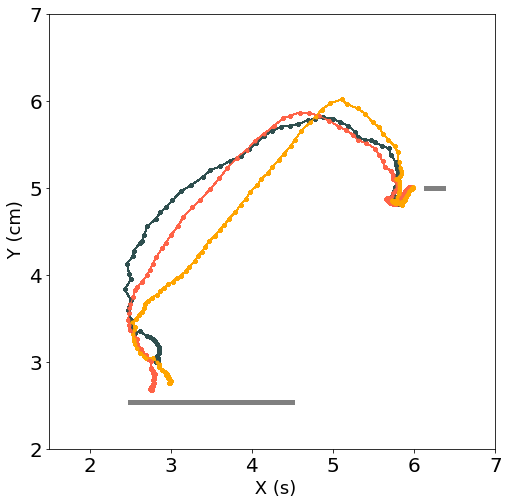

In [17]:
df = pd.read_csv('/home/shiva/Desktop/outputDLC_resnet50_Rat_lever_Sophie_Rat_2Apr12shuffle1_250000.csv',header=[1,2])
pad_left_x = 150; pad_right_x = 270
scale_pix_to_cm = 2/(pad_right_x-pad_left_x)
x = (df['Lfinger0','x'].values)*scale_pix_to_cm
y = (512-df['Lfinger0','y'].values)*scale_pix_to_cm
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), sharey=True)
ax.get_xaxis().set_tick_params(direction='out',labelsize = 20)
ax.xaxis.set_ticks_position('bottom')
ax.get_yaxis().set_tick_params(direction='out',labelsize = 20)
ax.yaxis.set_ticks_position('left')
lever_x = 375*scale_pix_to_cm;lever_y = (512-212)*scale_pix_to_cm
pad_y = (512-360)*scale_pix_to_cm ;pad_left_x = 150*scale_pix_to_cm; pad_right_x = 270*scale_pix_to_cm
plt.plot([lever_x - 0.1, lever_x + 0.1],[lever_y,lever_y],lw = 5, c = 'grey')
plt.plot([pad_left_x,pad_right_x],[pad_y,pad_y],lw = 5, c = 'grey')
plt.xlim(1.5,7)
plt.ylim(2,7)
start= 0; stop= len(x)
#for i in range(0,stop-start):
for i in range(600,len(x)):
    if i%20 == 0:
        print(i)
    plt.plot(x[:225], y[:225], '-o', markersize = 3, lw = 1,c = 'darkslategrey')
    plt.plot(x[225:600], y[225:600], '-o', markersize = 3, lw = 1,c = 'tomato')
    plt.plot(x[600:i], y[600:i], '-o', markersize = 3, lw = 1,c = 'orange')

    plt.ylabel(" Y (cm)",fontsize = 18)
    plt.xlabel(" X (s)",fontsize = 18)
    plt.savefig('/home/shiva/Desktop/tracking_lever/frame'+str(i).zfill(5)+'.png',bbox_inches='tight',orientation='landscape',dpi=300)

# Create metadata df

In [6]:
folder_list =["Square_2-5_mW_partial-MT_Nf_375", "Square_5_mW_all-RT_Nf_500","Beta_20_mW_all-RT_Nf_375",
              "Beta_15_mW_all-MT_Nf_500", "Beta_10_mW_all-RT_Nf_375","Square_5_mW_partial-MT_Nf_500"]            
exp_par_list = ['Laser_ArchT','Laser_ArchT', 'Laser_ArchT', 'Laser_ArchT', 'Laser_ChR2', 'Laser_ChR2']  
frame_height_list = np.array([400, 400, 400, 400, 400,300])
experiment_dict = {'folder':folder_list, 'exp_par':exp_par_list, 'frame_height':frame_height_list}

metadata = build_metadeta_all_folders(experiment_dict)
metadata.to_csv(os.join.path(pre_direct,'opto_exp_all_protocols_and_animals.csv'),header = True,index=False)

to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  1
n trials =  42
to discard bc no solid detection above pad 1
# second order jitter : 0
discarded:  1
n trials =  42
to discard bc no solid detection above pad 2
# second order jitter : 0
discarded:  5
n trials =  38
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  35
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

laser v.s. no laser: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.519e-01 U_stat=2.100e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

laser v.s. no laser: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.676e-01 U_stat=5.000e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

laser v.s. no laser: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.956e-03 U_stat=2.330e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p 

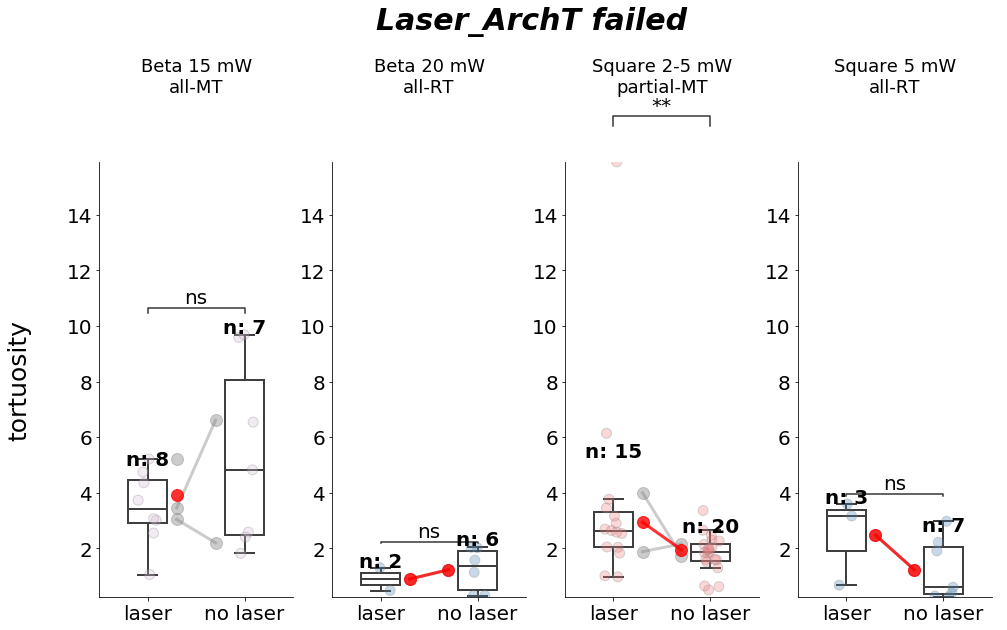

In [36]:
df = pd.read_csv(pre_direct+'/opto_exp_all_protocols_and_animals.csv', delimiter=",")
df['folder'] = df['pulse'] + df['intensity'] + df['protocol']

column = 'folder'
y = 'tortuosity'
# y = 'RT(ms)'
# y = 'MT(ms)'
# y = 'v_max(cm/s)'
exp_par = 'Laser_ArchT'
# exp_par = 'Laser_ChR2'
# trial = 'successful'
trial = 'failed'

df_plot = df[(df['opto_par'] == exp_par) & (df['trial'] == trial)]

protocol_palete_dict = {'all-RT':['steelblue','lightskyblue'], 'all-MT':['indigo','thistle'],
                       'partial-MT':['lightcoral','peachpuff']}
protocol_color_dict = {'all-RT':'steelblue', 'all-MT':'thistle',
                       'partial-MT':'lightcoral'}
def sns_box_point_plot(df,y,column,exp_par,trial):
    n_subplots = len(np.unique(df['folder']))
    y_max = max(df[y]) ; y_min = min(df[y])
    fig, axes = plt.subplots(nrows=1, ncols=n_subplots, figsize=(4*n_subplots, 8))
    folders = np.unique(df['folder'])
    for count in range(1,len(np.unique(df['folder']))+1):
        folder = folders[count-1]
        result = df[df['folder'] == folder]
        ax = axes[count-1] 
        ax = plt.subplot(100+n_subplots*10+count)
        set_ticks(ax)
        protocol = result['protocol'].values[0]
        trial = result['trial'].values[0]


        sns.stripplot(x="laser", y=y, order=["laser", "no laser"], data=result,jitter=True, edgecolor='grey',
                            linewidth=1,marker='o', size = 10,alpha=0.3 , color=protocol_color_dict[protocol])#color=(.25,.5,.75) )
        g = sns.boxplot(x="laser", y=y, order=["laser", "no laser"],linewidth=2,
                    data=result, fliersize = 0,dodge=False,width = 0.4, boxprops={'facecolor':'None'})
        add_stat_annotation(g, data=result,x="laser", y=y, order=["laser", "no laser"],
                    box_pairs=[("laser", "no laser")],
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2,fontsize = 20)

        medians = result.groupby(['laser'])[y].quantile(.9)
        nobs =  result.groupby(['laser']).apply(lambda x: 'n: {}'.format(len(x)))
        for tick, label in enumerate(ax.get_xticklabels()):
            ax_laser = label.get_text()
            x_offset = tick
            med_val = medians[ ax_laser]
            num = nobs[ax_laser]

            ax.text(tick, med_val + 0.1, num,
                        horizontalalignment='center', size=20, color='k', weight='semibold')
        rat_key = np.unique(result['rat_no'])
        grouped_ave_var =  group_and_av_animals(result,y)
        x = [0.3,0.7]
        for i in range(grouped_ave_var.shape[0]):
            plt.plot(x,grouped_ave_var[i],'-o',lw = 3, c= 'grey',alpha = 0.4,markersize = 12)
        plt.plot(x,np.average(grouped_ave_var,axis = 0),'-o',lw = 3, c= 'r',alpha = 0.8,markersize = 12)
        plt.ylim(y_min,y_max)
        # get legend information from the plot object
        # handles, labels = ax.get_legend_handles_labels()
        # specify just one legend
        # plt.legend(handles[0:2], labels[0:2], fontsize = 20)
        plt.ylabel('').set_fontproperties(font_label)
        plt.xlabel('').set_fontproperties(font_label)
        plt.title(result['pulse'].values[0]+' '+ result['intensity'].values[0]+' mW' +
                  '\n'+ result['protocol'].values[0],fontsize = 18,pad=70)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
#     y_title_pos = ax.get_position().get_points()+0.2
    fig.suptitle(exp_par+' ' + trial,y=1.15, fontproperties=font)
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel(y,fontsize = 25,labelpad=45)
    if '/' in y : y = y.replace('/', '_')
    plt.savefig(pre_direct+'/Subplots/'+y+'_'+trial+'_Rat_'+folder+'_'+exp_par+
                         '.png',bbox_inches='tight',orientation='landscape',dpi=200)
    
sns_box_point_plot(df_plot,y,column,exp_par,trial)

# Get all sessions 6OHDA mean trajectory

/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_-2_fps_250_Nf_375/Left/Plots  already exists!
Day_-2_fps_250_Nf_375
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 18
discarded:  0
n trials =  43
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 10
discarded:  0
n trials =  43
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 4
discarded:  0
n trials =  43
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 2
discarded:  0
n trials =  43
 succeeded =  172 
 failed =  0 
 pad miss detections =  0


No handles with labels found to put in legend.


/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_-1_fps_250_Nf_375/Left/Plots  already exists!
Day_-1_fps_250_Nf_375
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 3
discarded:  0
n trials =  43


No handles with labels found to put in legend.


16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 1
discarded:  0
n trials =  43
 succeeded =  86 
 failed =  0 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_0_pre_fps_250_Nf_375/Left/Plots  already exists!
Day_0_pre_fps_250_Nf_375


No handles with labels found to put in legend.


16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 1
discarded:  0
n trials =  43
 succeeded =  43 
 failed =  0 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_0_post_1_fps_250_Nf_375/Left/Plots  already exists!
Day_0_post_1_fps_250_Nf_375


No handles with labels found to put in legend.


16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  1
# second order jitter : 4
discarded:  1
n trials =  42
 succeeded =  42 
 failed =  0 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_0_post_2_fps_250_Nf_375/Left/Plots  already exists!
Day_0_post_2_fps_250_Nf_375


No handles with labels found to put in legend.
No handles with labels found to put in legend.


16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  15
# second order jitter : 2
discarded:  15
n trials =  28
 succeeded =  28 
 failed =  0 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_0_post_3_fps_250_Nf_375/Left/Plots  already exists!
Day_0_post_3_fps_250_Nf_375
5250 5250
to discard - pad misdetection 0
to discard - low likelihoods  1
# second order jitter : 0
discarded:  1
n trials =  13
 succeeded =  13 
 failed =  0 
 pad miss detections =  0


No handles with labels found to put in legend.


/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_0_post_6h_fps_250_Nf_375/Left/Plots  already exists!
Day_0_post_6h_fps_250_Nf_375
16125 16125
pad not off before reward
pad not off before reward
pad not off before reward
to discard - pad misdetection 3
to discard - low likelihoods  28
# second order jitter : 3
discarded:  30
n trials =  13
 succeeded =  11 
 failed =  2 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_1_fps_250_Nf_375/Left/Plots  already exists!
Day_1_fps_250_Nf_375


No handles with labels found to put in legend.


8625 8625
to discard - pad misdetection 0
to discard - low likelihoods  19
# second order jitter : 0
discarded:  19
n trials =  4
 succeeded =  2 
 failed =  2 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_2_fps_250_Nf_375/Left/Plots  already exists!
Day_2_fps_250_Nf_375
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  25
# second order jitter : 1
discarded:  25
n trials =  18


No handles with labels found to put in legend.


16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  23
# second order jitter : 3
discarded:  23
n trials =  20
6000 6000
to discard - pad misdetection 0
to discard - low likelihoods  9
# second order jitter : 0
discarded:  9
n trials =  7
 succeeded =  1 
 failed =  44 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_3_fps_250_Nf_375/Left/Plots  already exists!
Day_3_fps_250_Nf_375
3375 3375
to discard - pad misdetection 0
to discard - low likelihoods  3


No handles with labels found to put in legend.
No handles with labels found to put in legend.


# second order jitter : 1
discarded:  3
n trials =  6
 succeeded =  4 
 failed =  2 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_4_fps_250_Nf_375/Left/Plots  already exists!
Day_4_fps_250_Nf_375
11250 11250
to discard - pad misdetection 0
to discard - low likelihoods  6
# second order jitter : 1
discarded:  6
n trials =  24
 succeeded =  3 
 failed =  21 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_5_fps_250_Nf_375/Left/Plots  already exists!
Day_5_fps_250_Nf_375


No handles with labels found to put in legend.


8250 8250
pad not off before reward
to discard - pad misdetection 1
to discard - low likelihoods  7
# second order jitter : 0
discarded:  7
n trials =  15
 succeeded =  15 
 failed =  0 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_6_fps_250_Nf_375/Left/Plots  already exists!
Day_6_fps_250_Nf_375
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  25
# second order jitter : 0


No handles with labels found to put in legend.


discarded:  25
n trials =  18
 succeeded =  0 
 failed =  18 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_7_fps_250_Nf_375/Left/Plots  already exists!
Day_7_fps_250_Nf_375
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 0


No handles with labels found to put in legend.


discarded:  0
n trials =  43
13875 13875
to discard - pad misdetection 0
to discard - low likelihoods  1
# second order jitter : 1
discarded:  1
n trials =  36
 succeeded =  79 
 failed =  0 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_8_fps_250_Nf_375/Left/Plots  already exists!
Day_8_fps_250_Nf_375
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 7
discarded:  0
n trials =  43
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 1
discarded:  0
n trials =  43
16125 16125
to discard - pad misdetection 0
to discard - low likelihoods  0


No handles with labels found to put in legend.


# second order jitter : 0
discarded:  0
n trials =  43
 succeeded =  129 
 failed =  0 
 pad miss detections =  0
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_36/Day_9_fps_250_Nf_375/Left/Plots  already exists!
Day_9_fps_250_Nf_375
7500 7500
to discard - pad misdetection 0
to discard - low likelihoods  2
# second order jitter : 1
discarded:  2
n trials =  18


No handles with labels found to put in legend.


7500 7500
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 0
discarded:  0
n trials =  20
7500 7500
to discard - pad misdetection 0
to discard - low likelihoods  0
# second order jitter : 2
discarded:  0
n trials =  20
 succeeded =  58 
 failed =  0 
 pad miss detections =  0


<Figure size 432x288 with 0 Axes>

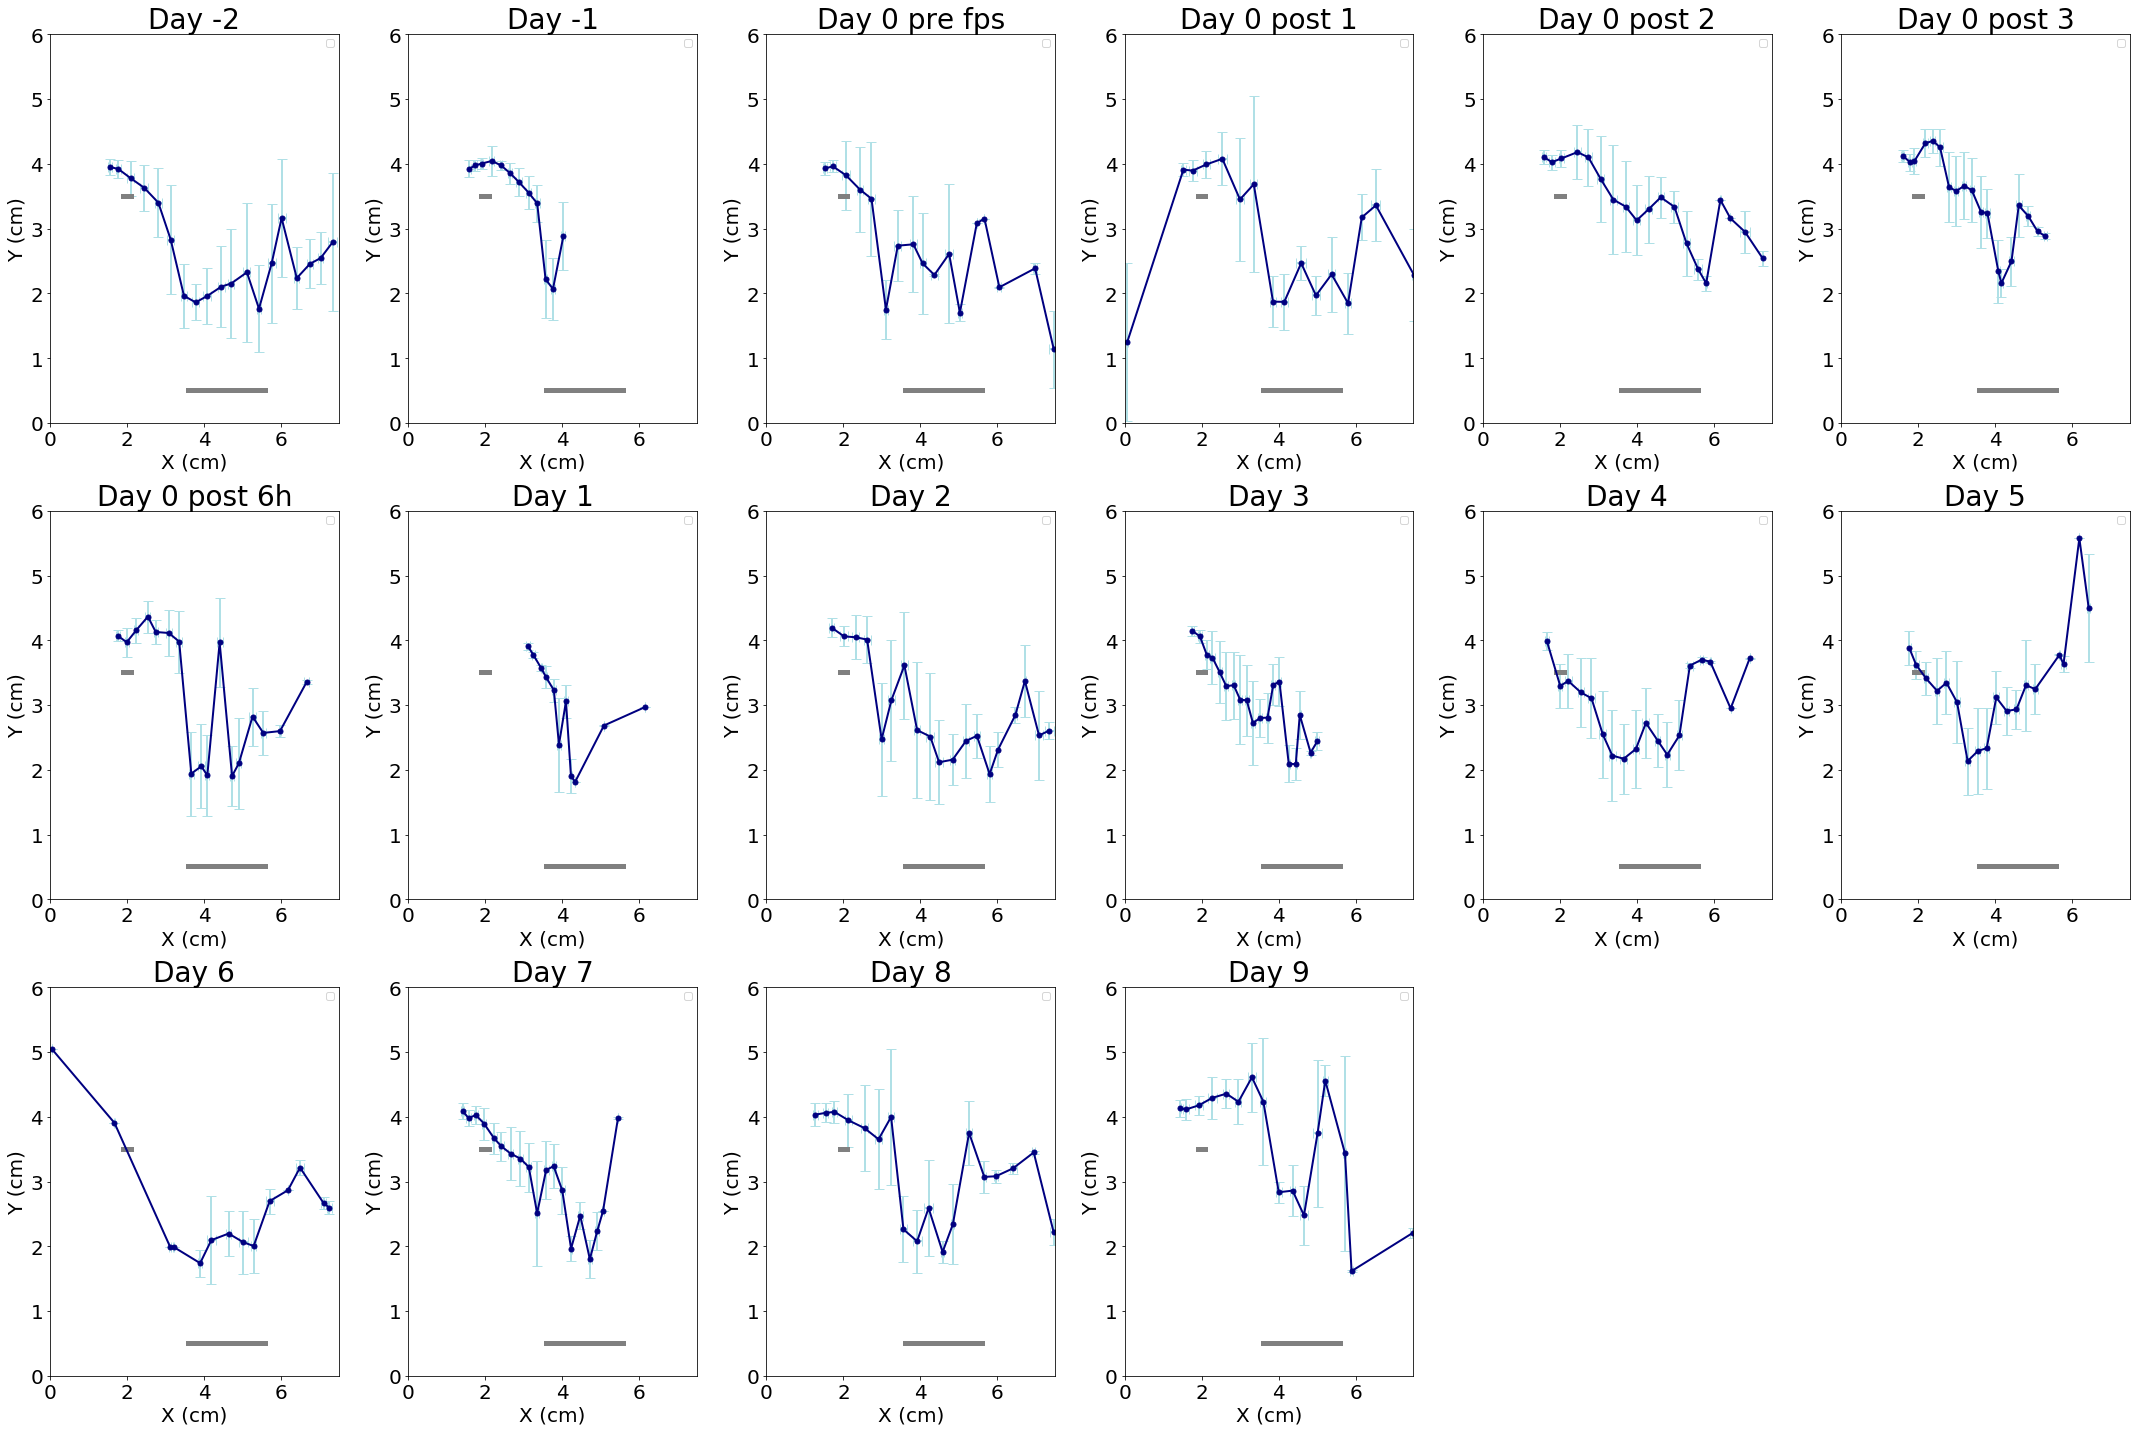

In [49]:

def find_all_files_same_protocol_non_laser(direct, protocol_name):
    ''' gets folder as input and finds all sessions of a certain protocol among different animals.
        returns an array specifying L or R handedness together with DLC and LED file paths '''
    files_list_DLC = []
    files_list_LED = []
    r_or_l_list = []
    for dirpath, dirnames, filenames in os.walk(direct):
        for dirname in dirnames:
            if dirname == protocol_name:
                path = os.path.join(dirpath, protocol_name)
                prop = protocol_name.split('_')
                R_L_folder = [ f.name for f in os.scandir(path) if f.is_dir() ][0] # gives the Right or Left
                config_sup_info = { 'optogenetic_manip': False, 
                        'exp_par': os.path.basename(os.path.normpath(direct)),
                        'r_or_l': R_L_folder[0],
                        'fp_trial': int(prop[-1]),
                        'fps': int(prop[-3]),
                        'pad_thresh': 0} 
                configname = set_config_file(protocol_name,dirpath)
                edit_config(configname, config_sup_info)
                attempt_to_make_folder(os.path.join(path,R_L_folder, 'Plots'))
                
                files_list_DLC += list_all_files(os.path.join(path, R_L_folder, 'DLC'),'.csv')
                files_list_LED += (list_all_files(os.path.join(path, R_L_folder, 'LED'),'.csv'))
#     print("number of sessionsf for "+ protocol_name + "protocol " , len(files_list_DLC))
    cfg_sample = read_plainconfig(configname)
    return  cfg_sample, files_list_DLC, files_list_LED

def extract_epochs(df,df_LED,path,folder,body_part,cfg):
    '''extract epochs of one session 
        return the session class containing all the info for the session'''

    scale_pix_to_cm = set_pix_scale(df_LED,cfg['pad_length_cm'])
#     variable_x , variable_y = average_position(df,body_part,cfg['r_or_l'],cfg['fp_trial'],scale_pix_to_cm)
    x , y, likelihood = position(df,body_part,cfg['r_or_l'],scale_pix_to_cm)
    y = cfg['frame_height']*scale_pix_to_cm - y # image has decreasing y instead of increasing

    session = Session(folder)
    session.set_epochs(x, y,likelihood, cfg) # reshapes to separate trials  
    session.set_properties(path,df_LED,cfg)
#     session.apply_pad_constraint(cfg)
    session.mark_unreasonable_n_acc_likelihood(cfg)
    
    session.epochs_x, session.epochs_y = correct_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,cfg)
    session.epochs_x, session.epochs_y,session.to_keep = correct_lasting_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,session.to_keep,cfg)
    session.correct_small_likelihoods(cfg)
    session.calculate_steps_traveled(cfg) # get the steps before masking 
    session.calculate_velocity(cfg)
    session.discard_unacceptable_trials()
#     session.mask_beginnings_and_end_of_trials(cfg)
    print("n trials = ",session.n_trials)
    return session

def extract_epochs_over_sessions(files_list_DLC, files_list_LED, folder,body_part,cfg_sample):
    '''return all the epochs of all trials for one animal '''
    trials_each = 45 # estimated number of trials per session
    all_sessions = All_Session(len(files_list_DLC)* trials_each,cfg_sample['optogenetic_manip'],cfg_sample['fp_trial'])
    trial_count = 0
    for i in range(0,len(files_list_DLC)):
#         print(' number of session = {} out of {}'.format(i+1,len(files_list_DLC)))
#         print(files_list_DLC[i])
        
        configname = os.path.join(up(up(up(files_list_DLC[i]))), 'config_'+folder+'.yaml')
        cfg = read_plainconfig(configname)
        df = read_DLC_csv(files_list_DLC[i],cfg['fp_trial'])
        df_LED = read_LED_csv(files_list_LED[i],len(df.index))
        print(len(df.index),len(df_LED.index))
#         r_or_l = r_or_l_list[i]
        path = files_list_LED[i]
        if cfg['optogenetic_manip'] == True:
            session = extract_opto_epochs(df, df_LED, path, folder, body_part, cfg)
        elif cfg['optogenetic_manip'] == False:
            session = extract_epochs(df, df_LED, path, folder, body_part, cfg)
#         print(np.max(session.velocity_r,axis = 1))
        all_sessions.add_session(trial_count, session.n_trials, session,cfg['optogenetic_manip'])
        trial_count += session.n_trials
    all_sessions.remove_extra_nans(cfg['optogenetic_manip'])
    return all_sessions

def run_one_folder(rat_no, folder_list):
    ''' run data over all mice of one group and one intensity and 
    save data of epochs and individal rats to a npz file'''
    plt.figure(2)
    fig = plt.figure(figsize=(30,20))
    
    nrows=3;ncols= int(len(folder_list)/nrows)+1

    count = 0
    for folder in folder_list: # Run over all the mice
        count +=1
        cfg_sample,files_list_DLC, files_list_LED = find_all_files_same_protocol_non_laser(path, folder)
        where_plot,what_plot = 0,0
        print(folder)
        body_part = cfg_sample['body_part_list'][where_plot]
        all_sessions = extract_epochs_over_sessions( files_list_DLC, files_list_LED, folder,body_part,cfg_sample)

        failed = Failed(all_sessions)
        successful = Successful(all_sessions)
        print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", all_sessions.n_pad_miss_detection)
#         print(" max trial time = ", successful.max_time/cfg['fps']*1000 ," ms", "\n min trial time = ", successful.min_time/cfg['fps']*1000 ," ms")


        if len(files_list_DLC)==0 :
            print("No files for ",folder)
            continue
        elif len(files_list_LED)==0 :
            print("No LED detection")
            continue
        else:

            ax = fig.add_subplot(nrows,ncols,count)
            set_ticks(ax)
            plot_mean_trajectory(all_sessions,folder,cfg_sample)


    plt.tight_layout()

#     plt.savefig(pre_direct+'/Subplots'+'/All_days_'+'Rat_'+str(rat_no)+'.png',bbox_inches='tight',orientation='landscape',dpi=200)
#     plt.show()

def plot_mean_trajectory(session,folder,cfg):
    trials = find_mean_trajectory(cfg, session)
    plt.errorbar(trials.x,trials.y,  trials.err_y, trials.err_x,  marker = 'o',
             markersize=5, linewidth=2, capsize=5, capthick=1, color = 'navy', ecolor='powderblue')
    plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
    plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')
    name= folder.split('_')
    title  = name[0]+' '+name[1]
    if len(name) > 6:
        title = title +' ' + name[2] + ' ' + name[3]
    plt.title(title,fontsize = 28)
    plt.ylabel("Y (cm)",fontsize = 20)
    plt.xlabel("X (cm)",fontsize = 20)
    plt.legend(fontsize = 10)
    plt.xlim(0,7.5)
    plt.ylim(0,6)
rat_no = 12;    
# folder_list = ['Day_-1_fps_250_Nf_375','Day_0_fps_250_Nf_375','Day_7_fps_250_Nf_375','Day_8_fps_250_Nf_375',
#                'Day_9_fps_250_Nf_375','Day_10_fps_250_Nf_375']
rat_no = 36;
folder_list = ['Day_-2_fps_250_Nf_375', 'Day_-1_fps_250_Nf_375', 'Day_0_pre_fps_250_Nf_375', 'Day_0_post_1_fps_250_Nf_375',
                'Day_0_post_2_fps_250_Nf_375', 'Day_0_post_3_fps_250_Nf_375', 'Day_0_post_6h_fps_250_Nf_375',
                'Day_1_fps_250_Nf_375', 'Day_2_fps_250_Nf_375', 'Day_3_fps_250_Nf_375', 'Day_4_fps_250_Nf_375', 
                'Day_5_fps_250_Nf_375', 'Day_6_fps_250_Nf_375', 'Day_7_fps_250_Nf_375', 
                'Day_8_fps_250_Nf_375', 'Day_9_fps_250_Nf_375']
 
# exp_par = '6OHDA'
# path  = os.path.join(pre_direct, exp_par, 'Rat_' +str(rat_no))
# folder_list = os.listdir(path)


# cfg_sample,files_list_DLC, files_list_LED = find_all_files_same_protocol_non_laser(path, folder)
# where_plot,what_plot = 0,0
# all_sessions = extract_epochs_over_sessions( files_list_DLC, files_list_LED, folder,body_part,cfg_sample)
# failed = Failed(all_sessions)
# successful = Successful(all_sessions)

run_one_folder(rat_no, folder_list)   

# plt.savefig(os.path.join(pre_direct, 'Subplots','Rat_'+str(rat_no)+'_'+folder+'_mean_trajectory'+
#              '.png'),bbox_inches='tight',orientation='landscape',dpi=200)


In [43]:
path  = os.path.join(pre_direct, exp_par, 'Rat_' +str(rat_no))
folder_list = os.listdir(path)
print(folder_list)



['Day_3_fps_250_Nf_375', 'Day_-2_fps_250_Nf_375', 'Day_2_fps_250_Nf_375', 'Day_0_pre_fps_250_Nf_375', 'Day_-1_fps_250_Nf_375', 'Day_0_post_3_fps_250_Nf_375', 'Day_6_fps_250_Nf_375', 'Day_7_fps_250_Nf_375', 'Day_0_post_1_fps_250_Nf_375', 'Day_5_fps_250_Nf_375', 'Day_9_fps_250_Nf_375', 'Day_1_fps_250_Nf_375', 'Day_0_post_2_fps_250_Nf_375', 'Day_0_post_6h_fps_250_Nf_375', 'Day_8_fps_250_Nf_375', 'Day_4_fps_250_Nf_375']


## plot fastest and slowest trials

t_s 10
# jitter in DLC  =  413
t_s 10
# jitter in DLC  =  240
 succeeded =  41 
 failed =  0 
 pad miss detections =  0
 max trial time =  776.0  ms 
 min trial time =  96.0  ms


<Figure size 432x288 with 0 Axes>

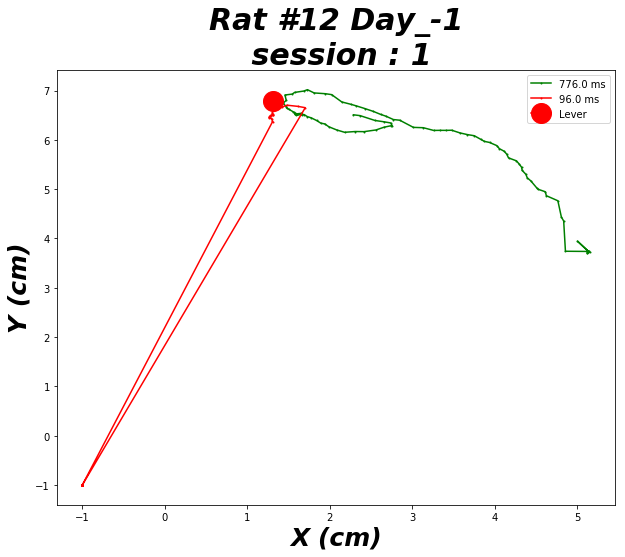

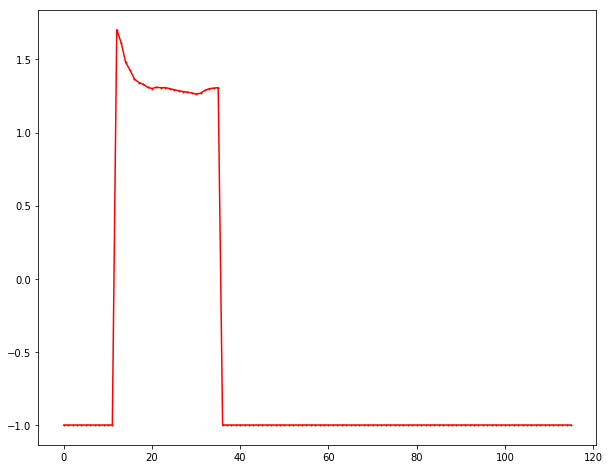

In [11]:
rat_no = 12; spont = "n"; folder = "Day_-1"
folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
direct = pre_direct +'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse

i = 0
files_list_DLC = list_all_files(direct+folder+'/DLC','.csv')
files_list_LED = list_all_files(direct+folder+'/LED','.csv')
path = direct+folder+'/DLC/'+files_list_DLC[i]
df = read_DLC_csv(direct+folder+'/DLC/'+files_list_DLC[i],cfg['fp_trial'])
df_LED = read_LED_csv(direct+folder+'/LED/'+files_list_LED[i],len(df.index))
body_part,what_plot = [0],0

session = extract_opto_epochs(df,df_LED,path,folder,cfg['fp_trial'],body_part,cfg['frame_height'])
session.discard_unacceptable_trials()

failed = Failed(session)
successful = Successful(session)
print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
print(" max trial time = ", successful.max_time/cfg['fps']*1000 ," ms", "\n min trial time = ", successful.min_time/cfg['fps']*1000 ," ms")
plt.figure(1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)

ind, = np.where(successful.epochs_x[j,:] != -1 ) 
plt.plot(successful.epochs_x[successful.trial_no_max_time,ind],successful.epochs_y[successful.trial_no_max_time,ind],c='g', marker='o',markersize=1, label = str(successful.max_time/cfg['fps']*1000)+" ms")

ind, = np.where(successful.epochs_x[j,:] != -1 ) 
plt.plot(successful.epochs_x[successful.trial_no_min_time,ind],successful.epochs_y[successful.trial_no_min_time,ind],c='r', marker='o',markersize=1, label = str(successful.min_time/cfg['fps']*1000)+" ms")
plt.plot([lever_x],[lever_y], marker='o',markersize=20,c = 'r',label = "Lever")
plt.title("Rat #"+str(rat_no)+" "+folder+"\n session : "+str(i+1)).set_fontproperties(font)
plt.ylabel("Y (cm)").set_fontproperties(font_label)
plt.xlabel("X (cm)").set_fontproperties(font_label)
plt.legend(fontsize = 10)
plt.figure(2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)
plt.plot(successful.epochs_x[successful.trial_no_min_time,ind],c='r', marker='o',markersize=1, label = str(successful.min_time/cfg['fps']*1000)+" ms")



# check session

In [51]:
rat_no = 1
n_session = 0
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300


# files_list_DLC, files_list_LED, path, body_part, cfg = set_conf_and_df(pre_direct, folder,rat_no,exp_par )
# df, df_LED = get_DLC_LED_df(files_list_DLC, files_list_LED, n_session,cfg)
# session = extract_opto_epochs(df,df_LED,path,folder,body_part,cfg)
# laser = Laser(session)
# failed = Failed(laser)
# successful = Successful(laser)
# non_laser = Non_Laser(session)

cfg_sample,files_list_DLC, files_list_LED = find_all_files_same_protocol(os.path.join(pre_direct,exp_par), folder)
all_sessions = extract_epochs_over_sessions(files_list_DLC,files_list_LED,folder,body_part, cfg_sample)
write_pickle(os.path.join(pre_direct,'sessions.pickle'), all_sessions)
unpickled = read_pickle(os.path.join(pre_direct,'sessions.pickle'))
print(unpickled.n_trials)

# laser = Laser(all_sessions)
# laser_failed = Failed(laser)
# laser_successful = Successful(laser)
# # non_laser = Non_Laser(all_sessions)
# # normal_failed = Failed(non_laser)
# # normal_successful = Successful(non_laser)


294


# Laser

## Trajectory successful and failed

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_1/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43
 succeeded =  18 
 failed =  0 
 pad miss detections =  0
 max trial time =  404.0  ms 
 min trial time =  228.0  ms


No handles with labels found to put in legend.


400
to discard bc no solid detection above pad 0
# second order jitter : 4
discarded:  0
n trials =  43
 succeeded =  10 
 failed =  2 
 pad miss detections =  0
 max trial time =  512.0  ms 
 min trial time =  256.0  ms
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  1
n trials =  42
 succeeded =  11 
 failed =  1 
 pad miss detections =  0
 max trial time =  432.0  ms 
 min trial time =  196.0  ms
400
to discard bc no solid detection above pad 1
# second order jitter : 1
discarded:  1
n trials =  39
 succeeded =  13 
 failed =  1 
 pad miss detections =  0
 max trial time =  760.0  ms 
 min trial time =  212.0  ms


<Figure size 432x288 with 0 Axes>

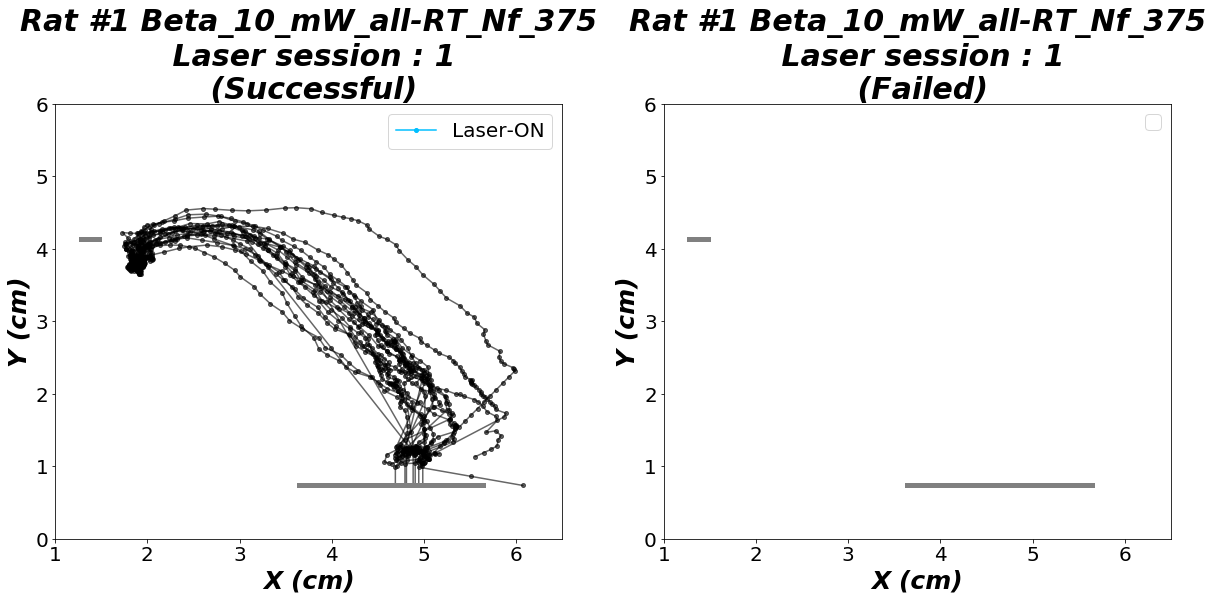

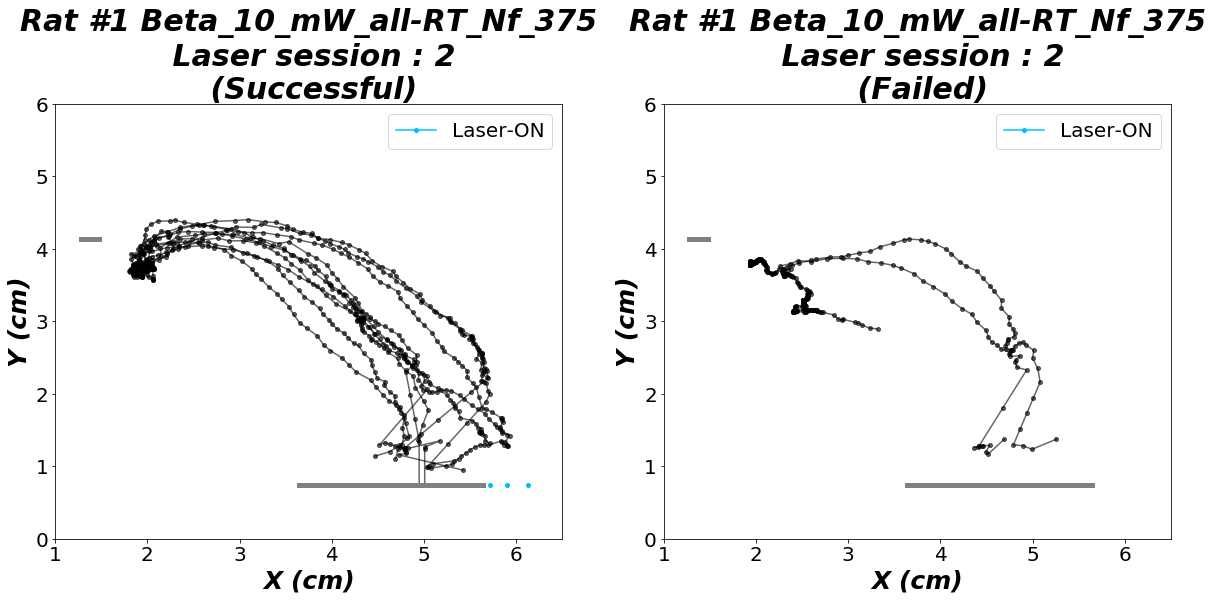

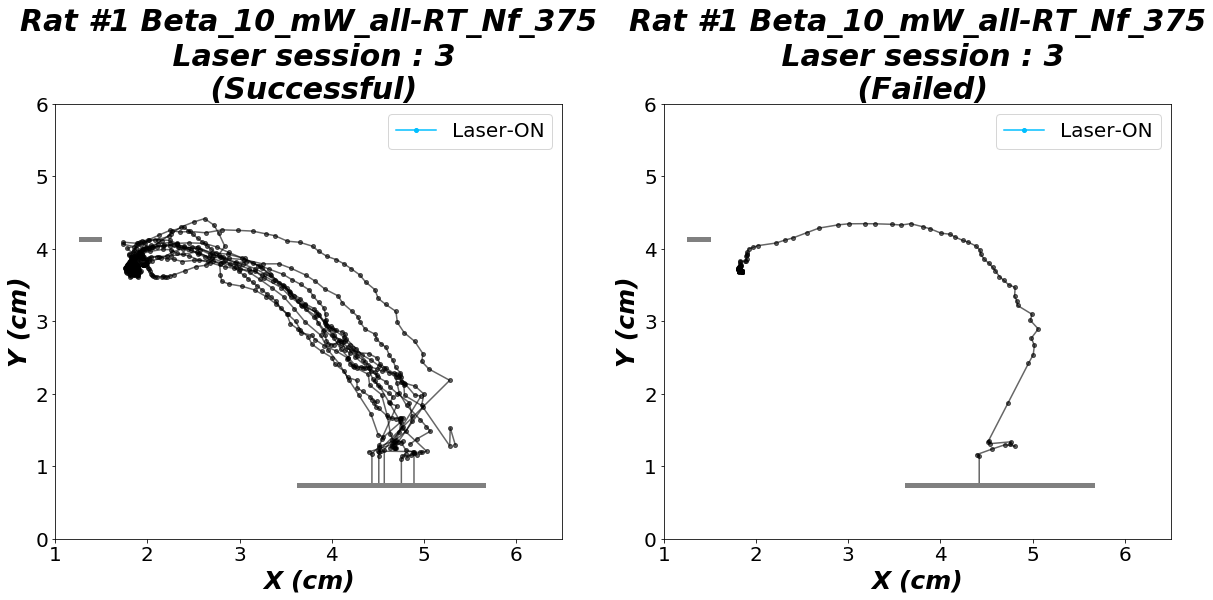

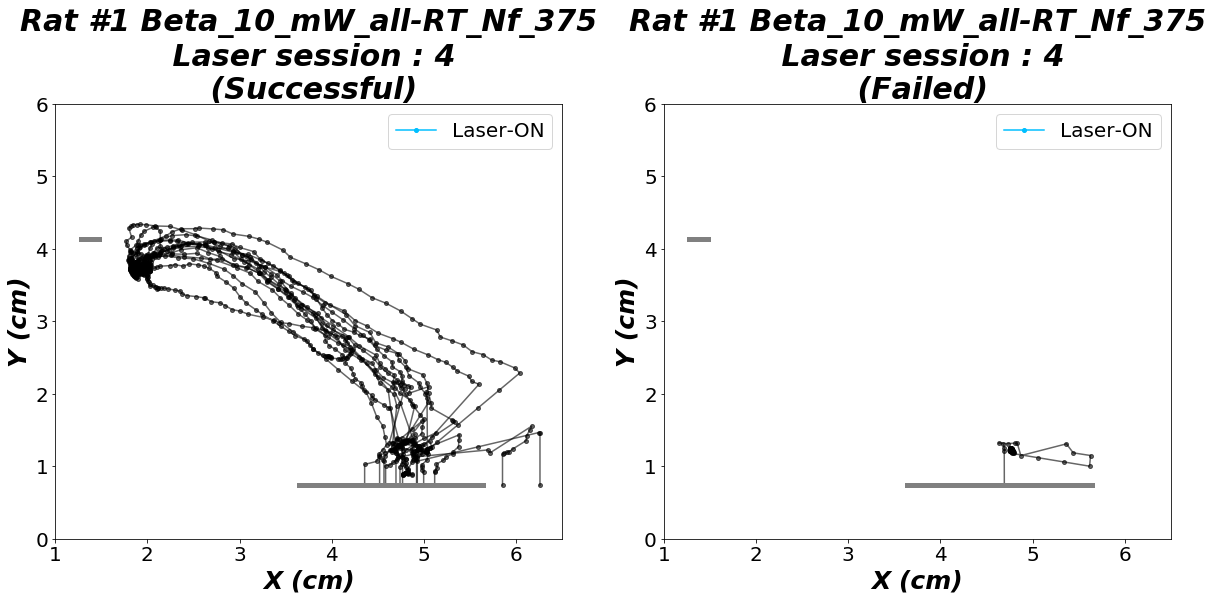

In [45]:

def plot_laser_trajectory(n,files_list_DLC,files_list_LED,path,folder,cfg):
    df, df_LED = get_DLC_LED_df(files_list_DLC, files_list_LED, n,cfg)
    i = 0
    j = 0
    session = extract_opto_epochs(df,df_LED,path,folder,body_part,cfg)
    laser = Laser(session)
    failed = Failed(laser)
    successful = Successful(laser)
    print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
    print(" max trial time = ", successful.max_time/cfg['fps']*1000 ," ms", "\n min trial time = ", successful.min_time/cfg['fps']*1000 ," ms")
    plt.figure(1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
    ax[0] = plt.subplot(121)
#     for j in range (m,m+1):
    for j in range (0,successful.n_trials):
#         successful.epochs_x, successful.epochs_y = correct_labeling_jitter(successful.epochs_x, successful.epochs_y,
#                                                 successful.likelihood,cfg['cfg['max_delta_r_per_frame']'], cfg['t_s'])
#         successful.epochs_x, successful.epochs_y,session.to_keep = correct_lasting_labeling_jitter(successful.epochs_x, successful.epochs_y,
#                                                 successful.likelihood,session.to_keep,cfg['max_delta_r_per_frame'], cfg['t_s'],cfg['fp_trial'],cfg['cor_t_prox_thresh'])
#         successful.epochs_x[j,successful.likelihood[j] < cfg['p_cutoff']] = -1
        overall_ind, = np.where(successful.epochs_x[j,:] != -1 )

#         alphas = np.linspace(0.1, 1, len(overall_ind))
#         rgba_colors = np.zeros((len(overall_ind),4))
#         rgba_colors[:,:-1] = np.random.random((3))
#         rgba_colors[:, 3] = alphas
#         plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
#         plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )
        ind_bef = overall_ind[overall_ind <= successful.laser_start[j]]
        ind_aft = overall_ind[overall_ind >= (successful.laser_start[j]+successful.laser_duration[j])]
#         print(successful.epochs_x[j,ind_bef])
        plt.plot(successful.epochs_x[j,ind_bef],successful.epochs_y[j,ind_bef],'-o', color = 'k',alpha = 0.6 , markersize = 4)
        plt.plot(successful.epochs_x[j,ind_aft],successful.epochs_y[j,ind_aft],'-o', color = 'k',alpha = 0.6 , markersize = 4)
        # to doo
        ind = np.arange(successful.laser_duration[j],dtype = int)+int(successful.laser_start[j])
        ind = ind[ind >= successful.pad_off_t[j]]
#         print(successful.epochs_x[j,ind])
        plt.plot(successful.epochs_x[j,ind],successful.epochs_y[j,ind],'-o', c = 'deepskyblue', alpha = 1, markersize = 4 )

    plt.plot(successful.epochs_x[j,ind],successful.epochs_y[j,ind],'-o', c = 'deepskyblue', alpha = 1, markersize = 4,label= "Laser-ON" )
    plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
    plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')
    plt.legend(fontsize = 20)
    plt.title("Rat #"+str(rat_no)+" "+folder+"\n Laser session : "+str(n+1)+"\n (Successful)").set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
#     plt.legend(fontsize = 10)
    plt.xlim(1,6.5)
    plt.ylim(0,6)
    set_ticks(ax[0])
    ax[1] = plt.subplot(122)

    for i in range (0,failed.n_trials):
#         failed.epochs_x[i,failed.likelihood[i] < cfg['p_cutoff']] = -1
        overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
        ind = np.arange(failed.laser_duration[i],dtype = int)+int(failed.laser_start[i]) 
        
#         alphas = np.linspace(0.1, 1, len(overall_ind))
#         rgba_colors = np.zeros((len(overall_ind),4))
#         rgba_colors[:,:-1] = np.random.random((3))
#         rgba_colors[:, 3] = alphas
#         plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )
#         plt.plot(failed.epochs_x[i,ind],failed.epochs_y[i,ind], c = 'navy', alpha = 0.5 )
#         plt.plot(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )
        
        ind_bef = overall_ind[overall_ind <= failed.laser_start[i]]
        ind_aft = overall_ind[overall_ind >= (failed.laser_start[i]+failed.laser_duration[i])]
        plt.plot(failed.epochs_x[i,ind_bef],failed.epochs_y[i,ind_bef],'-o', color = 'k',alpha = 0.6 , markersize = 4)
        plt.plot(failed.epochs_x[i,ind_aft],failed.epochs_y[i,ind_aft],'-o', color = 'k',alpha = 0.6 , markersize = 4)

    if failed.n_trials > 0:
#         plt.plot(failed.epochs_x[i,ind],failed.epochs_y[i,ind], c = 'navy', alpha = 0.1, label= "Laser-ON" )
        plt.plot(failed.epochs_x[i,ind],failed.epochs_y[i,ind],'-o', c = 'deepskyblue', alpha = 1, markersize = 4, label= "Laser-ON" )

    plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
    plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')
    plt.legend(fontsize = 20)
    plt.title("Rat #"+str(rat_no)+" "+folder+"\n Laser session : "+str(n+1)+'\n (Failed)').set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
    plt.xlim(1,6.5)
    plt.ylim(0,6)
    set_ticks(ax[1])
    plt.savefig(os.path.join(pre_direct, 'Subplots', 'Rat_'+str(rat_no)+'_'+folder+'_session = '+str(n+1)+
                 '.png'),bbox_inches='tight',orientation='landscape',dpi=200)

    

m = 6
rat_no = 1; 
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300
# 

files_list_DLC, files_list_LED, path, body_part, cfg = set_conf_and_df(pre_direct, folder,rat_no,exp_par )

for n in range(0,len(files_list_DLC)):
    plot_laser_trajectory(n,files_list_DLC,files_list_LED,path,folder,cfg)


## Velocity

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_2/Square_2-5_mW_partial-MT_Nf_375/Right/Plots  already exists!
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  1
n trials =  42
[] []
[63] [0.248]
[] []
[67] [0.256]
[57] [0.224]
[68] [0.272]
[] []
[81] [0.32]
[] []
[ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108] [0.312 0.316 0.32  0.324 0.328 0.332 0.336 0.34  0.344 0.348 0.352 0.356
 0.36  0.364 0.368 0.372 0.376 0.38  0.384 0.388 0.392 0.396 0.4   0.404
 0.408 0.412 0.416 0.42 ]
[ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107] [0.192 0.196 0.2   0.204 0.208 0.212 0.216 0.22  0.224 0.228 0.232 0.236
 0.24  0.244 0.248 0.252 0.256 0.26  0.264 0.268 0.272 0.276 0.28  0.284
 0.288 0.292 0.296]
[ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 

ValueError: x and y must have same first dimension, but have shapes (119,) and (64,)

<Figure size 432x288 with 0 Axes>

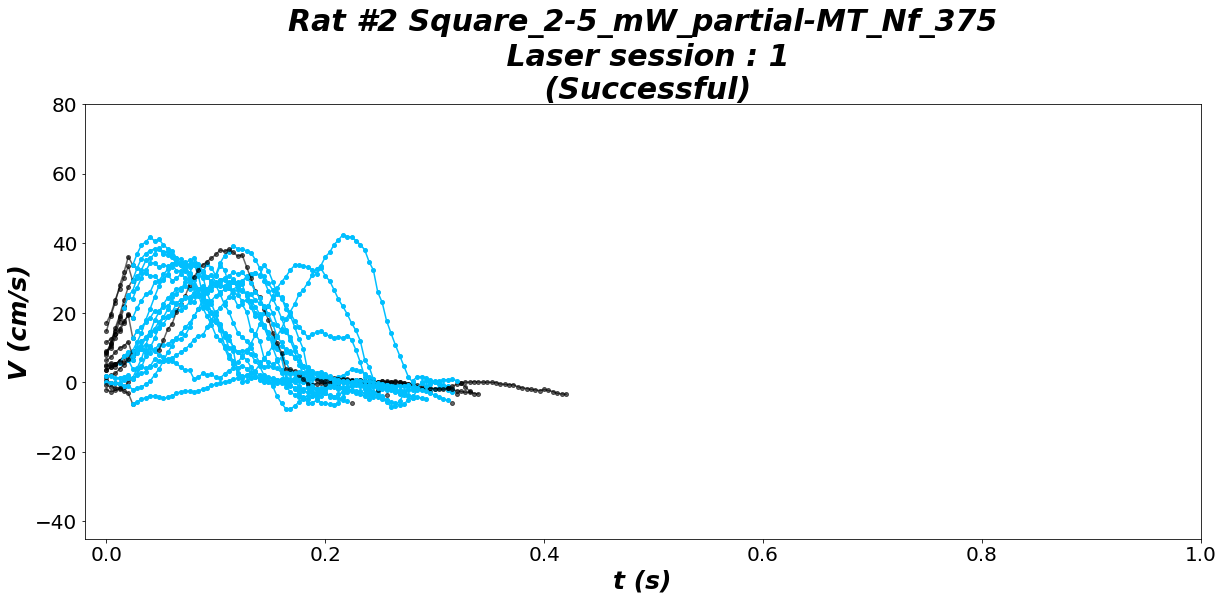

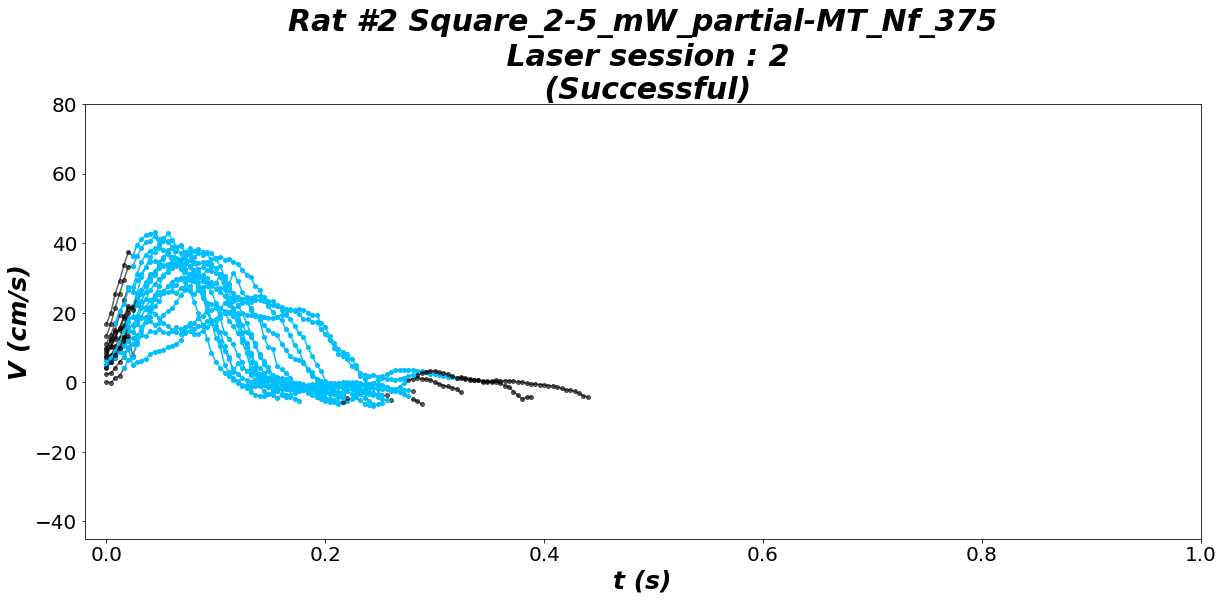

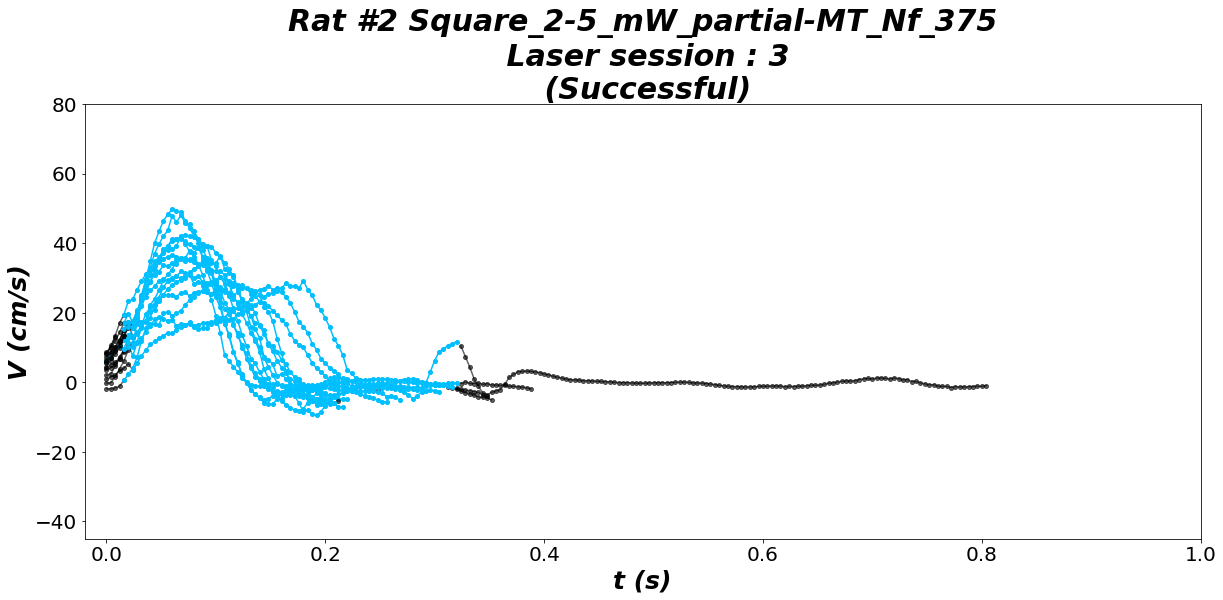

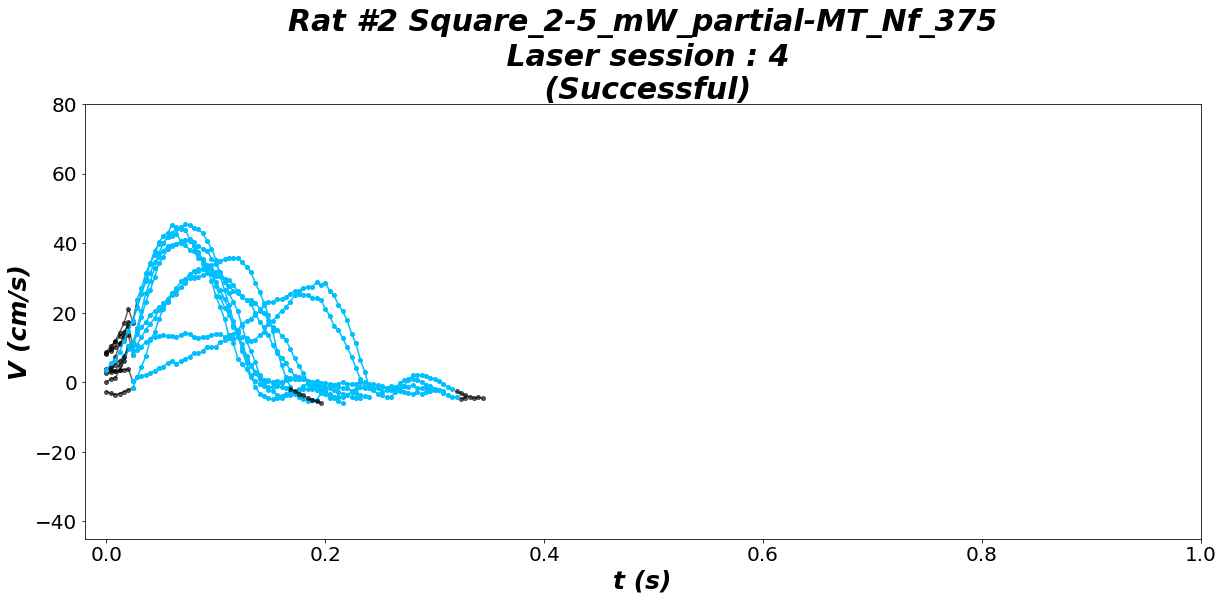

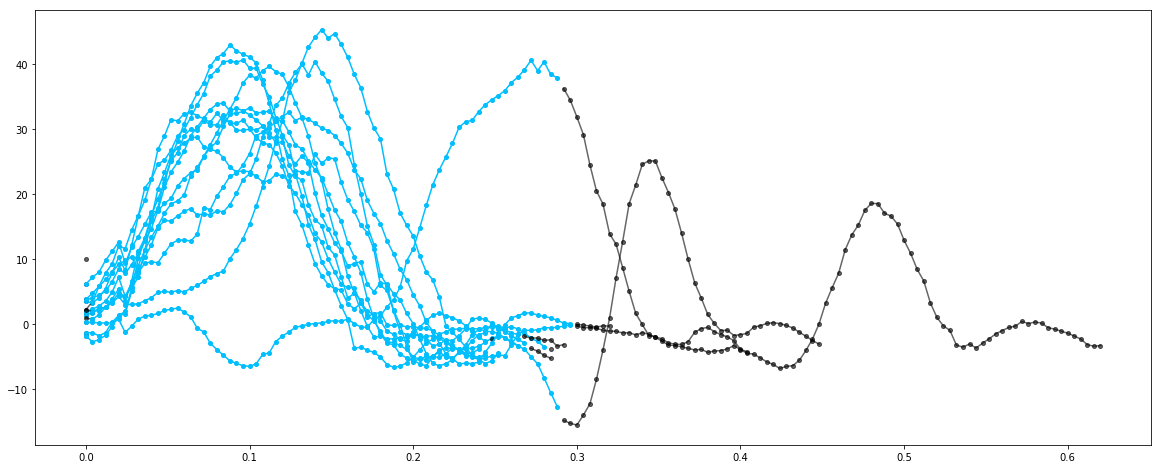

In [18]:
def plot_laser_velocity(n,files_list_DLC,files_list_LED,path,folder,cfg):


    df, df_LED = get_DLC_LED_df(files_list_DLC, files_list_LED, n,cfg)

    i = 0
    j = 0
    session = extract_opto_epochs(df,df_LED,path,folder,body_part,cfg)  
    laser = Laser(session)
    failed = Failed(laser)
    successful = Successful(laser)
    plt.figure(1)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8), sharey=True)
    for j in range (0,successful.n_trials):
        overall_ind, = np.where(successful.velocity_r[j,:] != cfg['velocity_mask'] )
#         rgba_colors = np.zeros((4))
#         rgba_colors[:-1] = np.random.random((3))
#         rgba_colors[3] = 0.5
#         time_series_overall = (np.arange(successful.pad_off_t[j],successful.got_reward_t[j])-successful.pad_off_t[j])/cfg['fps']
#         plt.scatter(time_series_overall,successful.velocity_r[j,overall_ind], color = rgba_colors )
#         plt.plot(time_series_overall,successful.velocity_r[j,overall_ind], color = rgba_colors[:-1],alpha = 0.1 )
        if successful.laser_start[j] < successful.pad_off_t[j]:
            laser_start = successful.pad_off_t[j]
        else:
            laser_start = successful.laser_start[j]
        if successful.laser_duration[j]+successful.laser_start[j] > successful.got_reward_t[j]:
            laser_end = successful.got_reward_t[j]
        else: 
            laser_end = successful.laser_duration[j]+successful.laser_start[j]
        ind_bef = overall_ind[overall_ind <= laser_start]
        ind_aft = overall_ind[(overall_ind >= laser_end)]
        time_series_bef = np.arange(laser_start-successful.pad_off_t[j]+1)/cfg['fps']
        time_series_aft = np.arange(laser_end,overall_ind[-1]+1)/cfg['fps'] - successful.pad_off_t[j]/cfg['fps']
        print(ind_aft, time_series_aft)                   
        plt.plot(time_series_bef,successful.velocity_r[j,ind_bef],'-o', color = 'k',alpha = 0.6 , markersize = 4)
        plt.plot(time_series_aft,successful.velocity_r[j,ind_aft],'-o', color = 'k',alpha = 0.6 , markersize = 4)

        ind = np.arange(laser_start,laser_end,dtype = int)
#         ind = np.intersect1d(ind,overall_ind)
        if len(ind) != 0: # it could be possible that the hand doesn't leave the pad during laser
            time_series_laser = (np.arange(laser_start,laser_end)-successful.pad_off_t[j])/cfg['fps']
#             plt.plot(time_series_laser,successful.velocity_r[j,ind], c = 'navy', alpha = 0.5 )
            plt.plot(time_series_laser,successful.velocity_r[j,ind],'-o', c = 'deepskyblue', alpha = 1 , markersize = 4)

#     plt.axvspan(np.average(successful.laser_start)/cfg['fps']-np.average(successful.pad_off_t)/cfg['fps'], 
#         np.average(successful.laser_start)/cfg['fps']+ np.average(successful.laser_duration)/cfg['fps']-np.average(successful.pad_off_t)/cfg['fps'], alpha=0.2, color='lightskyblue')
    plt.title("Rat #"+str(rat_no)+" "+folder+"\n Laser session : "+str(n+1)+"\n (Successful)").set_fontproperties(font)
    plt.ylabel("V (cm/s)").set_fontproperties(font_label)
    plt.xlabel("t (s)").set_fontproperties(font_label)
#     plt.legend(fontsize = 10)
    plt.xlim(-0.02,1.)
    plt.ylim(-45,80)
    set_ticks(ax)
    plt.savefig(os.path.join(pre_direct, 'Subplots','Velocity_Rat_'+str(rat_no)+'_'+folder+'_session = '+str(n+1)+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)
    

rat_no = 2;
folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300


files_list_DLC, files_list_LED, path, body_part, cfg = set_conf_and_df(pre_direct, folder,rat_no,exp_par )

for n in range(0,len(files_list_DLC)):
    plot_laser_velocity(n,files_list_DLC,files_list_LED,path,folder,cfg)




# Non Laser 

## Trajectory

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_1/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43
 succeeded =  25 
 failed =  0 
 pad miss detections =  0


<Figure size 432x288 with 0 Axes>

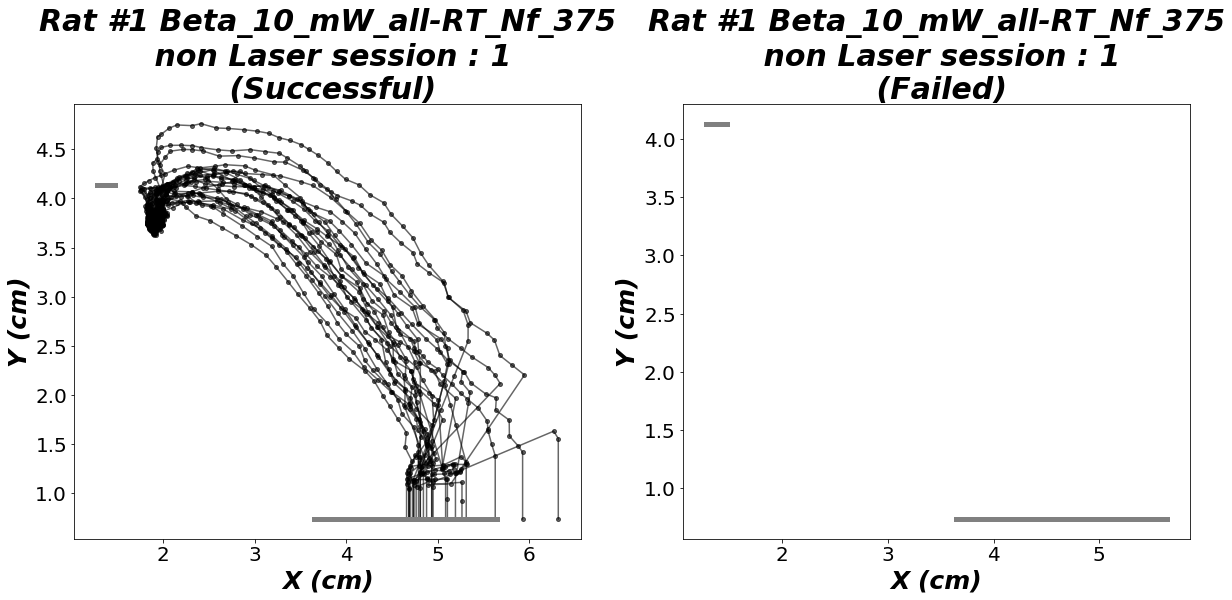

In [140]:

def plot_non_laser_trajectory(n,files_list_DLC,files_list_LED,path,folder,cfg):
    df, df_LED = get_DLC_LED_df(files_list_DLC, files_list_LED, n,cfg)
    i = 0
    j = 0
    session = extract_opto_epochs(df,df_LED,path,folder,body_part,cfg)
    non_laser = Non_Laser(session)
    failed = Failed(non_laser)
    successful = Successful(non_laser)
    print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
    plt.figure(1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
    ax[0] = plt.subplot(121)
    for j in range (0,successful.n_trials):
#     for j in range (m,m+1):
#         successful.epochs_x[j,successful.likelihood[j] < cfg['p_cutoff']] = -1
        overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
        ind = np.arange(successful.laser_duration[j],dtype = int)+int(successful.laser_start[j])

#         alphas = np.linspace(0.1, 1, len(overall_ind))
#         rgba_colors = np.zeros((len(overall_ind),4))
#         rgba_colors[:,:-1] = np.random.random((3))
#         rgba_colors[:, 3] = alphas
#         plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
#         plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

        plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],'-o', color = 'k',alpha = 0.6 , markersize = 4,label = 'traveled path')

    plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
    plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')
#     plt.plot([successful.epochs_x[j,overall_ind[0]],session.lever_x[0]],[session.pad_y[0],session.lever_y[0]],'--',
#              lw = 3, c = 'lightskyblue',label = 'straight line')

    plt.title("Rat #"+str(rat_no)+" "+folder+"\n non Laser session : "+str(n+1)+"\n (Successful)").set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
#     plt.legend(fontsize = 20)
#     plt.xlim(1,6.5)
#     plt.ylim(0,6)
    set_ticks(ax[0])
    ax[1] = plt.subplot(122)

    for i in range (0,failed.n_trials):
#         failed.epochs_x[i,failed.likelihood[i] < cfg['p_cutoff']] = -1
        overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
#         ind = np.arange(failed.cfg['laser_duration'][i],dtype = int)+int(failed.laser_start[i]) 
#         alphas = np.linspace(0.1, 1, len(overall_ind))
#         rgba_colors = np.zeros((len(overall_ind),4))
#         rgba_colors[:,:-1] = np.random.random((3))
#         rgba_colors[:, 3] = alphas
#         plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )
#         plt.plot(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )
        plt.plot(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind],'-o', color = 'k',alpha = 0.6 , markersize = 4)
    
    plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
    plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

    plt.title("Rat #"+str(rat_no)+" "+folder+"\n non Laser session : "+str(n+1)+'\n (Failed)').set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
#     plt.xlim(1,6.5)
#     plt.ylim(0,6)
    set_ticks(ax[1])
    plt.savefig(os.path.join(pre_direct,'Subplots', 'Rat_'+str(rat_no)+'_'+folder+'_non_laser_session = '+str(n+1)+
                 '.png'),bbox_inches='tight',orientation='landscape',dpi=200)

    
    return session


rat_no = 1
m = 3
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300


files_list_DLC, files_list_LED, path, body_part, cfg = set_conf_and_df(pre_direct, folder,rat_no,exp_par )
for n in range(0,1):#len(files_list_DLC)):
    plot_non_laser_trajectory(n,files_list_DLC,files_list_LED,path,folder,cfg)


## Velocity

No handles with labels found to put in legend.


/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_102/Square_5_mW_partial-MT_Nf_500/Right/Plots  already exists!
400
to discard bc no solid detection above pad 3
# second order jitter : 1
discarded:  3
n trials =  29


<Figure size 432x288 with 0 Axes>

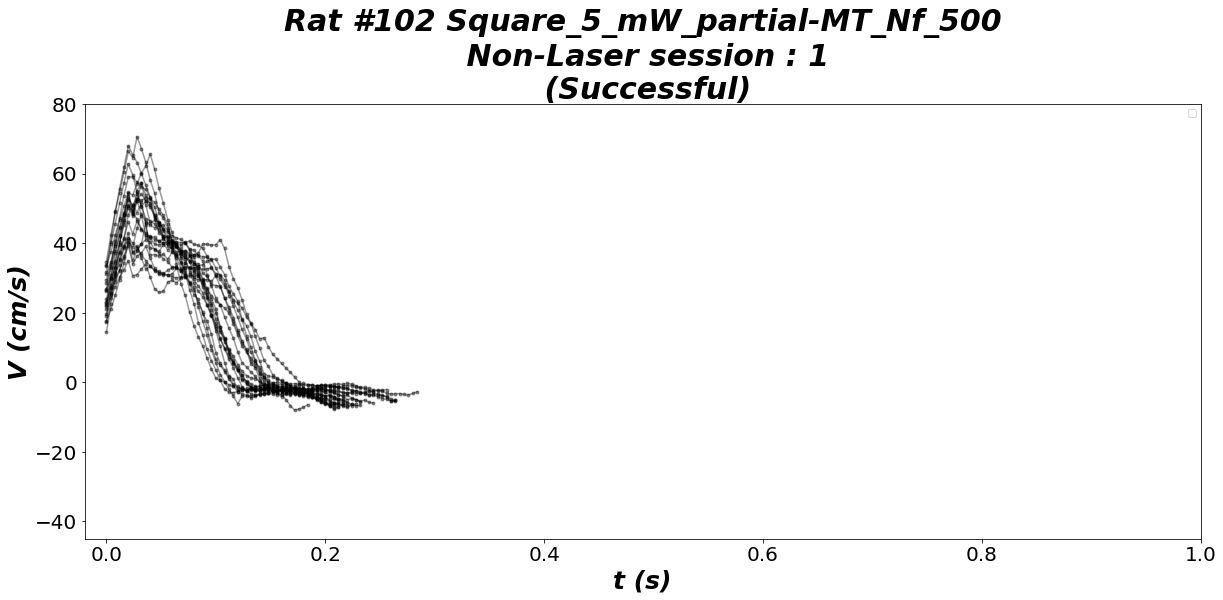

In [97]:

def plot_non_laser_velocity(n,files_list_DLC,files_list_LED,path,folder,cfg):
    df, df_LED = get_DLC_LED_df(files_list_DLC, files_list_LED, n,cfg)

    i = 0
    j = 0
    session = extract_opto_epochs(df,df_LED,path,folder,body_part,cfg)  

    laser = Non_Laser(session)
    failed = Failed(laser)
    successful = Successful(laser)
    plt.figure(1)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8), sharey=True)
    for j in range (0,successful.n_trials):
        overall_ind, = np.where(successful.velocity_r[j,:] != cfg['velocity_mask'] )
        time_series_overall = np.arange(len(overall_ind))/cfg['fps']
        plt.plot(time_series_overall,successful.velocity_r[j,overall_ind],'-o', color = 'k',alpha = 0.4, markersize = 3)

    plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-Laser session : "+str(n+1)+"\n (Successful)").set_fontproperties(font)
    plt.ylabel("V (cm/s)").set_fontproperties(font_label)
    plt.xlabel("t (s)").set_fontproperties(font_label)
    plt.legend(fontsize = 10)
    plt.xlim(-0.02,1.)
    plt.ylim(-45,80)
    set_ticks(ax)
    plt.savefig(os.path.join(pre_direct, 'Subplots', 'Velocity_Rat_'+str(rat_no)+'_'+folder+'_Non-Laser_session = '+str(n+1)+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)
    

rat_no = 102;
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300


files_list_DLC, files_list_LED, path, body_part, cfg = set_conf_and_df(pre_direct, folder,rat_no,exp_par )
for n in range(0,len(files_list_DLC)):
    plot_non_laser_velocity(n,files_list_DLC,files_list_LED,path,folder,cfg)



# Compare $Traveled\: distance$ laser vs. non laser

## Successful + Failed

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_1/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_21/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:625: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:626: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:627: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:628: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:647: RuntimeWarning: invalid value encountered in multiply


400
to discard bc no solid detection above pad 0
# second order jitter : 4
discarded:  0
n trials =  43
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 1
# second order jitter : 1
discarded:  1
n trials =  39
400
to discard bc no solid detection above pad 1
# second order jitter : 0
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 1
# second order jitter : 2
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  0
n trials =  43
laser success trials =  103
laser failed trials =  12
normal success trials =  162
normal failed trials =  17


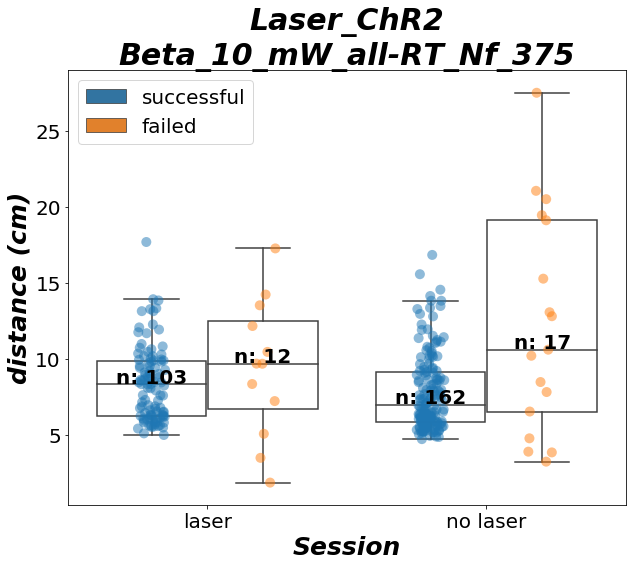

In [116]:
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300


result = build_sessions_transf_to_df(folder,exp_par)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
set_ticks(ax)
ax = sns.stripplot(x="laser", y="distance(cm)", order=["laser", "no laser"],hue="trial",dodge=True, data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="distance(cm)", order=["laser", "no laser"],hue="trial",dodge=True, 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser','trial'])['distance(cm)'].median()
nobs =  result.groupby(['laser','trial']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    for j, ax_trial in enumerate(ax.get_legend_handles_labels()[1][:2]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ ax_laser, ax_trial]
        num = nobs[ax_laser, ax_trial]
        
        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('distance (cm)').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(os.path.join(pre_direct, 'Subplots','Distance_Rat_'+folder+'_'+exp_par+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)


## Only Successful

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_102/Square_5_mW_partial-MT_Nf_500/Right/Plots  already exists!
300
to discard bc no solid detection above pad 3
# second order jitter : 1
discarded:  3
n trials =  29
laser success trials =  8
laser failed trials =  0
normal success trials =  21
normal failed trials =  0


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:624: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:625: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:626: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:627: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:628: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:647: RuntimeWarning: invalid value encountered in multiply


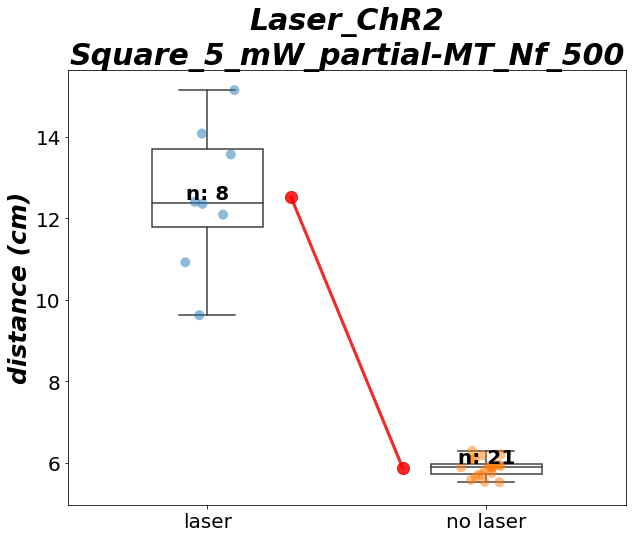

In [117]:
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300



df = build_sessions_transf_to_df(folder,exp_par)
result = df[df['trial'] == 'successful']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

set_ticks(ax)
ax = sns.stripplot(x="laser", y="distance(cm)", order=["laser", "no laser"],dodge=True, data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="distance(cm)", order=["laser", "no laser"],dodge=False, width = 0.4 ,
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser'])['distance(cm)'].median()
nobs =  result.groupby(['laser']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    x_offset = tick
    med_val = medians[ ax_laser]
    num = nobs[ax_laser]
        
    ax.text(tick, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
    
grouped_ave_var = group_and_av_animals(result,y = 'distance(cm)')
x = np.unique(result['laser'])
x = [0.3,0.7]
for i in range(grouped_ave_var.shape[0]):
    plt.plot(x,grouped_ave_var[i],'-o',lw = 3, c= 'grey',alpha = 0.4,markersize = 12)
plt.plot(x,np.average(grouped_ave_var,axis = 0),'-o',lw = 3, c= 'r',alpha = 0.8,markersize = 12)

# get legend information from the plot object
# handles, labels = ax.get_legend_handles_labels()
# specify just one legend
# plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('distance (cm)').set_fontproperties(font_label)
plt.xlabel('').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(os.path.join(pre_direct,'Subplots','Distance_Rat_'+folder+'_'+exp_par+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)


# Compare $MT$ laser vs. non laser

## Only successful

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_102/Square_5_mW_partial-MT_Nf_500/Right/Plots  already exists!
300
to discard bc no solid detection above pad 3
# second order jitter : 1
discarded:  3
n trials =  29
laser success trials =  8
laser failed trials =  0
normal success trials =  21
normal failed trials =  0


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:624: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:625: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:626: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:627: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:628: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:647: RuntimeWarning: invalid value encountered in multiply


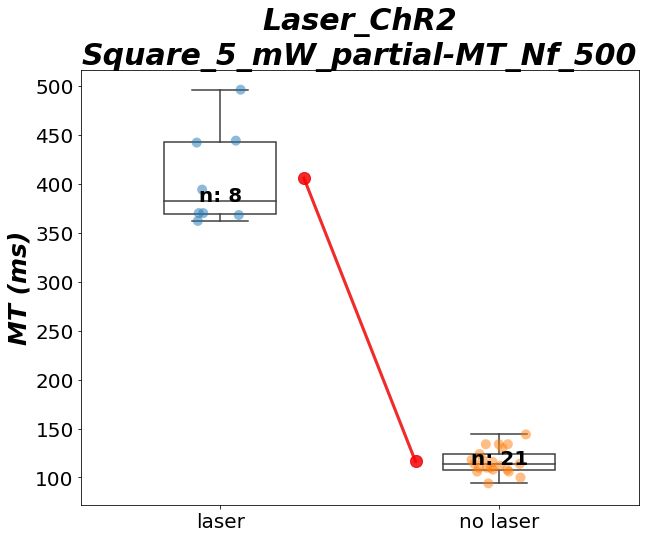

In [118]:
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300


result = build_sessions_transf_to_df(folder,exp_par)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
set_ticks(ax)
ax = sns.stripplot(x="laser", y="MT(ms)", order=["laser", "no laser"], data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="MT(ms)", order=["laser", "no laser"], 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0, dodge=False, width = 0.4)

medians = result.groupby(['laser'])['MT(ms)'].median()
nobs =  result.groupby(['laser']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    x_offset = tick
    med_val = medians[ ax_laser]
    num = nobs[ax_laser]
        
    ax.text(tick, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
    
grouped_ave_var = grouped_ave_var = group_and_av_animals(result,y = 'MT(ms)')
x = np.unique(result['laser'])
x = [0.3,0.7]
for i in range(grouped_ave_var.shape[0]):
    plt.plot(x,grouped_ave_var[i],'-o',lw = 3, c= 'grey',alpha = 0.4,markersize = 12)
plt.plot(x,np.average(grouped_ave_var,axis = 0),'-o',lw = 3, c= 'r',alpha = 0.8,markersize = 12)

# get legend information from the plot object
# handles, labels = ax.get_legend_handles_labels()
# specify just one legend
# plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('MT (ms)').set_fontproperties(font_label)
plt.xlabel('').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(os.path.join(pre_direct,'Subplots','MT_Rat_'+folder+'_'+exp_par+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)
    
# plt.show()


# print(result.head())
# ax = sns.swarmplot(x="day", y="total_bill", hue="smoker",

#                    data=tips, palette="Set2", dodge=True)

# Compare $RT$ laser vs. non laser

## Successful + Failed

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_1/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_21/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:624: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:625: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:647: RuntimeWarning: invalid value encountered in multiply


400
to discard bc no solid detection above pad 0
# second order jitter : 4
discarded:  0
n trials =  43
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 1
# second order jitter : 1
discarded:  1
n trials =  39
400
to discard bc no solid detection above pad 1
# second order jitter : 0
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 1
# second order jitter : 2
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  0
n trials =  43
laser success trials =  103
laser failed trials =  12
normal success trials =  162
normal failed trials =  17


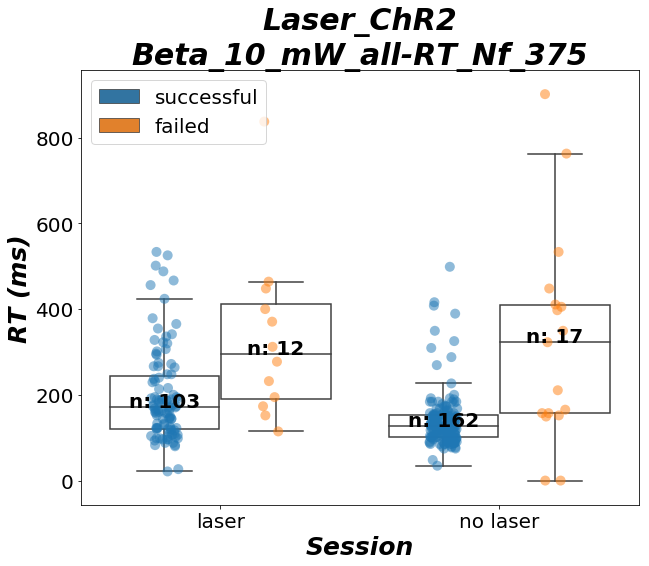

In [123]:
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300


result = build_sessions_transf_to_df(folder,exp_par)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

set_ticks(ax)
ax = sns.stripplot(x="laser", y="RT(ms)", order=["laser", "no laser"],hue="trial",dodge=True, data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="RT(ms)", order=["laser", "no laser"],hue="trial",dodge=True, 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser','trial'])['RT(ms)'].median()
nobs =  result.groupby(['laser','trial']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    for j, ax_trial in enumerate(ax.get_legend_handles_labels()[1][:2]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ ax_laser, ax_trial]
        num = nobs[ax_laser, ax_trial]
        
        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('RT (ms)').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(os.path.join(pre_direct,'Subplots','RT_Rat_'+folder+'_'+exp_par+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)
    
# plt.show()


# print(result.head())
# ax = sns.swarmplot(x="day", y="total_bill", hue="smoker",

#                    data=tips, palette="Set2", dodge=True)

## Only Successful

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_102/Square_5_mW_partial-MT_Nf_500/Right/Plots  already exists!
300
to discard bc no solid detection above pad 3
# second order jitter : 1
discarded:  3
n trials =  29
laser success trials =  8
laser failed trials =  0
normal success trials =  21
normal failed trials =  0


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:624: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:625: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:626: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:627: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:628: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:647: RuntimeWarning: invalid value encountered in multiply


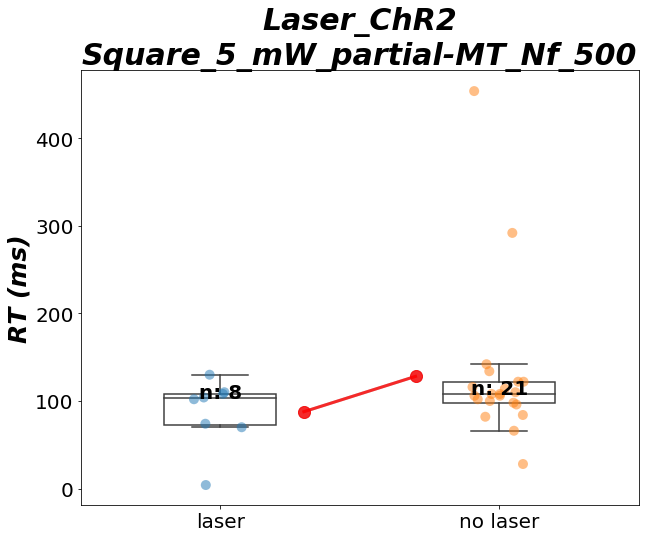

In [121]:
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300


result = build_sessions_transf_to_df(folder,exp_par)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
set_ticks(ax)
ax = sns.stripplot(x="laser", y="RT(ms)", order=["laser", "no laser"],dodge=True, data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="RT(ms)", order=["laser", "no laser"],dodge=False, width = 0.4, 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser'])['RT(ms)'].median()
nobs =  result.groupby(['laser']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    x_offset = tick
    med_val = medians[ ax_laser]
    num = nobs[ax_laser]
        
    ax.text(tick, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
    
grouped_ave_var = group_and_av_animals(result,y = 'RT(ms)')
x = np.unique(result['laser'])
x = [0.3,0.7]
for i in range(grouped_ave_var.shape[0]):
    plt.plot(x,grouped_ave_var[i],'-o',lw = 3, c= 'grey',alpha = 0.4,markersize = 12)
plt.plot(x,np.average(grouped_ave_var,axis = 0),'-o',lw = 3, c= 'r',alpha = 0.8,markersize = 12)

# get legend information from the plot object
# handles, labels = ax.get_legend_handles_labels()
# specify just one legend
# plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('RT (ms)').set_fontproperties(font_label)
plt.xlabel('').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(os.path.join(pre_direct,'Subplots','RT_Rat_'+folder+'_'+exp_par+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)
    

## all sessions one rat

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_3/Beta_15_mW_all-MT_Nf_500/Left/Plots  already exists!
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_2/Beta_15_mW_all-MT_Nf_500/Right/Plots  already exists!
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_4/Beta_15_mW_all-MT_Nf_500/Right/Plots  already exists!
400
to discard bc no solid detection above pad 0
# second order jitter : 0


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:624: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:625: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:626: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:627: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:628: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:647: RuntimeWarning: invalid value encountered in multiply


discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  5
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  19
400
to discard bc no solid detection

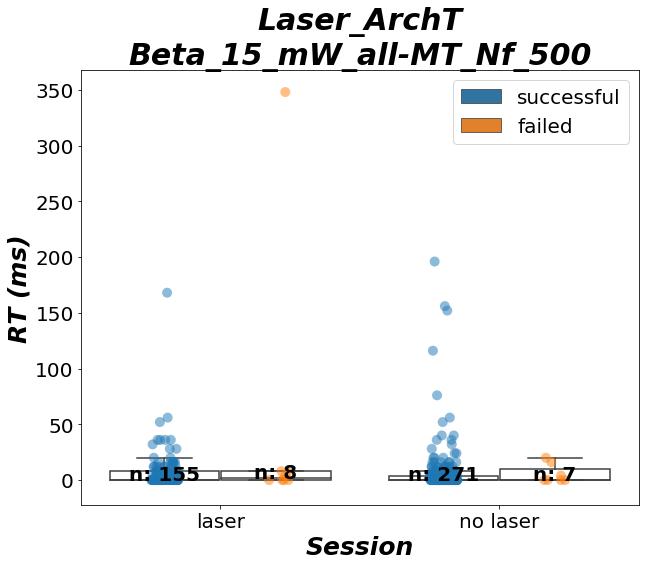

In [124]:
rat_no = 2; 

# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300


cfg_sample,files_list_DLC, files_list_LED = find_all_files_same_protocol(os.path.join(pre_direct,exp_par), folder)

all_sessions = extract_epochs_over_sessions(files_list_DLC, files_list_LED, folder,body_part,cfg_sample)
laser = Laser(all_sessions)
laser_failed = Failed(laser)
laser_successful = Successful(laser)
print("laser success trials = ",laser_successful.n_trials)
print("laser failed trials = ",laser_failed.n_trials)
non_laser = Non_Laser(all_sessions)
print(non_laser.path.shape)
normal_failed = Failed(non_laser)
normal_successful = Successful(non_laser)
print("normal success trials = ",normal_successful.n_trials)
print("normal failed trials = ",normal_failed.n_trials)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

col_names =  ['RT', 'trial', 'laser']
result = pd.DataFrame(columns = col_names)
df = pd.DataFrame(({'RT':laser_successful.pad_off_t, 'trial':['successful']*len(laser_successful.pad_off_t), 'laser':['laser']*len(laser_successful.pad_off_t)}))
df1 = pd.DataFrame(({'RT':laser_failed.pad_off_t, 'trial':['failed']*len(laser_failed.pad_off_t), 'laser':['laser']*len(laser_failed.pad_off_t)}))
df2 = pd.DataFrame(({'RT':normal_successful.pad_off_t, 'trial':['successful']*len(normal_successful.pad_off_t), 'laser':['no laser']*len(normal_successful.pad_off_t)}))
df3 = pd.DataFrame(({'RT':normal_failed.pad_off_t, 'trial':['failed']*len(normal_failed.pad_off_t), 'laser':['no laser']*len(normal_failed.pad_off_t)}))


result = pd.concat([result, df, df1, df2, df3],ignore_index=True)
result['RT'] = result['RT']*4


set_ticks(ax)
ax = sns.stripplot(x="laser", y="RT", order=["laser", "no laser"],hue="trial",dodge=True, data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="RT", order=["laser", "no laser"],hue="trial",dodge=True, 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser','trial'])['RT'].median()
nobs =  result.groupby(['laser','trial']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    for j, ax_trial in enumerate(ax.get_legend_handles_labels()[1][:2]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ ax_laser, ax_trial]
        num = nobs[ax_laser, ax_trial]
        
        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('RT (ms)').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(os.path.join(pre_direct, 'Subplots', 'RT_Rat_'+folder+'_'+exp_par+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)


# Compare $Tortuosity$ laser vs. non laser

## successfull + Failed

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_1/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_21/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:625: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:626: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:627: RuntimeWarning: invalid value encountered in multiply


400
to discard bc no solid detection above pad 0
# second order jitter : 4
discarded:  0
n trials =  43
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 1
# second order jitter : 1
discarded:  1
n trials =  39
400
to discard bc no solid detection above pad 1
# second order jitter : 0
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 1
# second order jitter : 2
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  0
n trials =  43
laser success trials =  103
laser failed trials =  12
normal success trials =  162
normal failed trials =  17


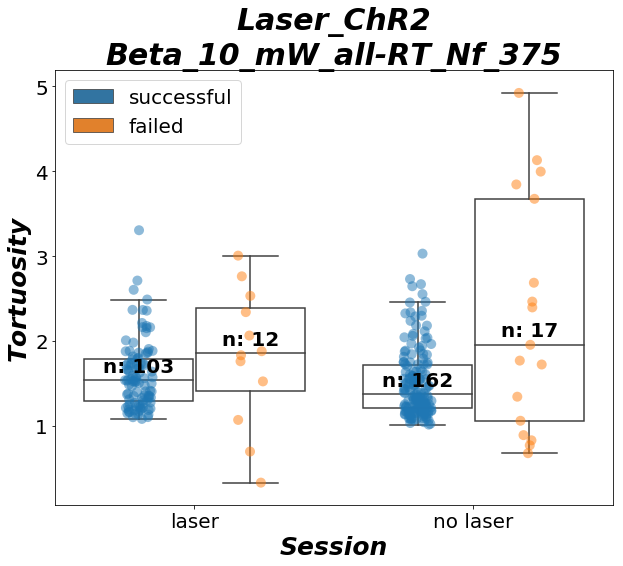

In [126]:
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300

result = build_sessions_transf_to_df(folder,exp_par)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
set_ticks(ax)
ax = sns.stripplot(x="laser", y="tortuosity", order=["laser", "no laser"],hue="trial",dodge=True, data=result,
                   jitter=True,marker='o', size = 10, alpha=0.5)
ax = sns.boxplot(x="laser", y="tortuosity", order=["laser", "no laser"],hue="trial",dodge=True, 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser','trial'])['tortuosity'].median()
nobs =  result.groupby(['laser','trial']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    for j, ax_trial in enumerate(ax.get_legend_handles_labels()[1][:2]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ ax_laser, ax_trial]
        num = nobs[ax_laser, ax_trial]
        
        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('Tortuosity').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(os.path.join(pre_direct, 'Subplots', 'Tortuosity_Rat_'+folder+'_'+exp_par+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)
    

## Only successfull

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_1/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_21/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:625: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:626: RuntimeWarning: invalid value encountered in multiply


400
to discard bc no solid detection above pad 0
# second order jitter : 4
discarded:  0
n trials =  43
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 1
# second order jitter : 1
discarded:  1
n trials =  39
400
to discard bc no solid detection above pad 1
# second order jitter : 0
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 1
# second order jitter : 2
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  0
n trials =  43
laser success trials =  103
laser failed trials =  12
normal success trials =  162
normal failed trials =  17


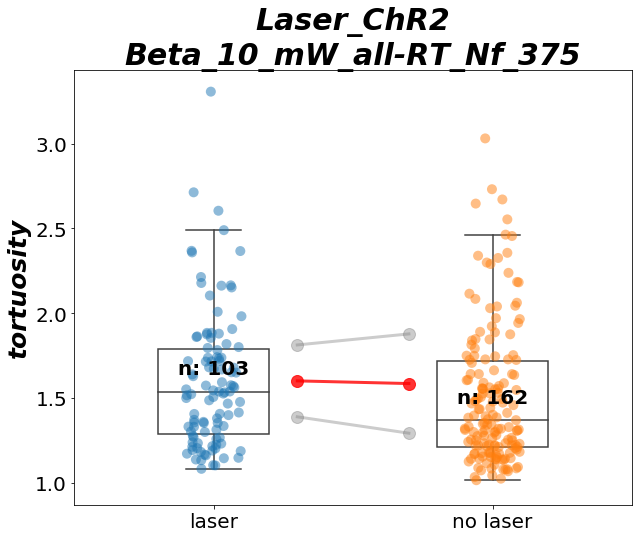

In [128]:
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300

df = build_sessions_transf_to_df(folder,exp_par)
result = df[df['trial'] == 'successful']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
set_ticks(ax)
ax = sns.stripplot(x="laser", y="tortuosity", order=["laser", "no laser"], data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="tortuosity", order=["laser", "no laser"], 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0,dodge=False,width = 0.4)

medians = result.groupby(['laser'])['tortuosity'].median()
nobs =  result.groupby(['laser']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    x_offset = tick
    med_val = medians[ ax_laser]
    num = nobs[ax_laser]
        
    ax.text(tick, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
    
grouped_ave_var = group_and_av_animals(result,y = 'tortuosity')
x = [0.3,0.7]
for i in range(grouped_ave_var.shape[0]):
    plt.plot(x,grouped_ave_var[i],'-o',lw = 3, c= 'grey',alpha = 0.4,markersize = 12)
plt.plot(x,np.average(grouped_ave_var,axis = 0),'-o',lw = 3, c= 'r',alpha = 0.8,markersize = 12)

# get legend information from the plot object
# handles, labels = ax.get_legend_handles_labels()
# specify just one legend
# plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('tortuosity').set_fontproperties(font_label)
plt.xlabel('').set_fontproperties(font_label)
plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(os.path.join(pre_direct, 'Subplots', 'tortuosity_only_success_Rat_'+folder+'_'+exp_par+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)
    

# Compare $ V_{max}$ laser vs. non laser

## Successful + failed

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_1/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_21/Beta_10_mW_all-RT_Nf_375/Left/Plots  already exists!
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  43


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:626: RuntimeWarning: invalid value encountered in multiply


400
to discard bc no solid detection above pad 0
# second order jitter : 4
discarded:  0
n trials =  43
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 1
# second order jitter : 1
discarded:  1
n trials =  39
400
to discard bc no solid detection above pad 1
# second order jitter : 0
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 1
# second order jitter : 2
discarded:  1
n trials =  42
400
to discard bc no solid detection above pad 0
# second order jitter : 1
discarded:  0
n trials =  43
laser success trials =  103
laser failed trials =  12
normal success trials =  162
normal failed trials =  17


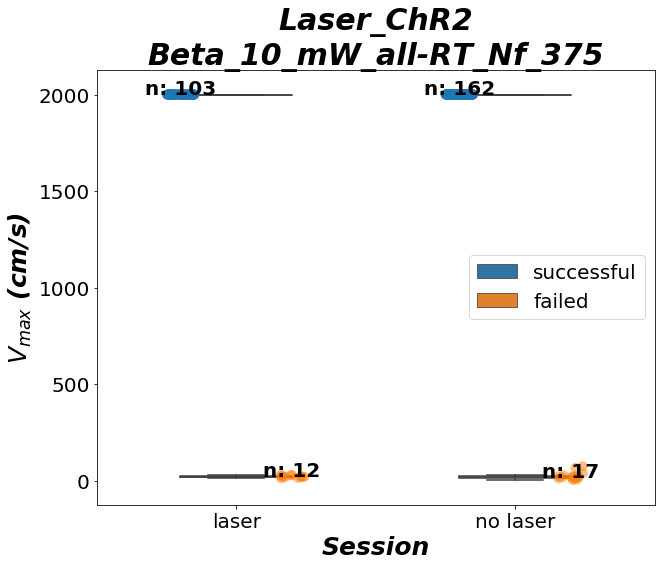

In [131]:
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300

result = build_sessions_transf_to_df(folder,exp_par)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

set_ticks(ax)
ax = sns.stripplot(x="laser", y="v_max(cm/s)", order=["laser", "no laser"],hue="trial",dodge=True, data=result,
                   jitter=True,marker='o', size = 10, alpha=0.5)
ax = sns.boxplot(x="laser", y="v_max(cm/s)", order=["laser", "no laser"],hue="trial",
            data=result, boxprops={'facecolor':'None'}, fliersize = 0,dodge=False,width = 0.4)

medians = result.groupby(['laser','trial'])['v_max(cm/s)'].median()
nobs =  result.groupby(['laser','trial']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    for j, ax_trial in enumerate(ax.get_legend_handles_labels()[1][:2]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ ax_laser, ax_trial]
        num = nobs[ax_laser, ax_trial]
        
        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel(r'$V_{max}$ (cm/s)').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(os.path.join(pre_direct, 'Subplots', 'V_max_Rat_'+folder+'_'+exp_par+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)


## Only successful

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_3/Beta_15_mW_all-MT_Nf_500/Left/Plots  already exists!
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_2/Beta_15_mW_all-MT_Nf_500/Right/Plots  already exists!
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_4/Beta_15_mW_all-MT_Nf_500/Right/Plots  already exists!
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  5
400
to discard bc no solid detection above pad 0
# second order jitter : 0
discarded:  0
n trials =  32
400
to discard bc no solid detection above pa

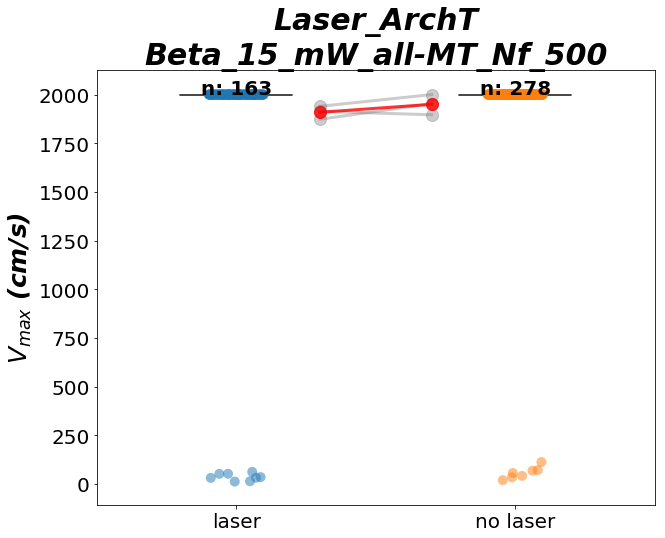

In [137]:
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_500" ; exp_par = 'Laser_ChR2' ; frame_height = 300

result = build_sessions_transf_to_df(folder,exp_par)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
set_ticks(ax)
ax = sns.stripplot(x="laser", y="v_max(cm/s)", order=["laser", "no laser"],dodge=True, data=result,
                   jitter=True,marker='o', size = 10, alpha=0.5)
ax = sns.boxplot(x="laser", y="v_max(cm/s)", order=["laser", "no laser"], 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0,dodge=False,width = 0.4)

medians = result.groupby(['laser'])['v_max(cm/s)'].median()
nobs =  result.groupby(['laser']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    x_offset = tick
    med_val = medians[ ax_laser]
    num = nobs[ax_laser]
        
    ax.text(tick, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
    
grouped_ave_var = group_and_av_animals(result,y='v_max(cm/s)')
x = [0.3,0.7]
for i in range(grouped_ave_var.shape[0]):
    plt.plot(x,grouped_ave_var[i],'-o',lw = 3, c= 'grey',alpha = 0.4,markersize = 12)
plt.plot(x,np.average(grouped_ave_var,axis = 0),'-o',lw = 3, c= 'r',alpha = 0.8,markersize = 12)


# get legend information from the plot object
# handles, labels = ax.get_legend_handles_labels()
# specify just one legend
# plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel(r'$V_{max}$ (cm/s)').set_fontproperties(font_label)
plt.xlabel('').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(os.path.join(pre_direct, 'Subplots', 'v_max_Rat_'+folder+'_'+exp_par+
                     '.png'),bbox_inches='tight',orientation='landscape',dpi=200)
    
# ax = sns.swarmplot(x="day", y="total_bill", hue="smoker",data=tips, palette="Set2", dodge=True)

# Loop to plot each session alone for all days

0.2
0.5235987755982988
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_180719_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
before [2.62567342 2.5087818 ]
after [2.75063486 2.72251548]
# second order jitter : 1
n trials =  42
[194 115  90 230 220 160  85 106  99 133 184 105 314 125  82 169  83  76
 108 130 100 153 154 113  67  58  54  96  67  99  49  61  61  55  78  64
  50  65  73 107  64]
[ 94  51  23 113  79  46  19   2  23  45 105  42   0  35   0  98   0  23
  41  10  29  41  47  42   0   0   0   1   0   0   0   0   0   0   0   0
   0   0   0   2   0]


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_182008_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
before [1.9323854  1.93818054 1.91674369 1.93157087 1.91553853 1.91578456]
after [5.63831903 5.63831903 5.63831903 5.63831903 5.63831903 5.63831903]
before [2.7091233]
after [3.93897792]
before [2.79551886]
after [3.75852647]
# second order jitter : 3
n trials =  42
[200 148 311 124 154 303  78 149 107 168 106 124  80 222  60  73 144  50
  61  55  83 134  62  96  78  68 108 244  66  77 142 153  86  91  66 109
 117 216 184]
[ 92  38 218   0  46  71   8  60  42  88   1  10   0  80   0   0   2   0
   0   0   1   0   0   0   0   0  52   2   0   1   0   2  27   0   0   1
   4  27  89]
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_182821_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
# second order jitter : 0

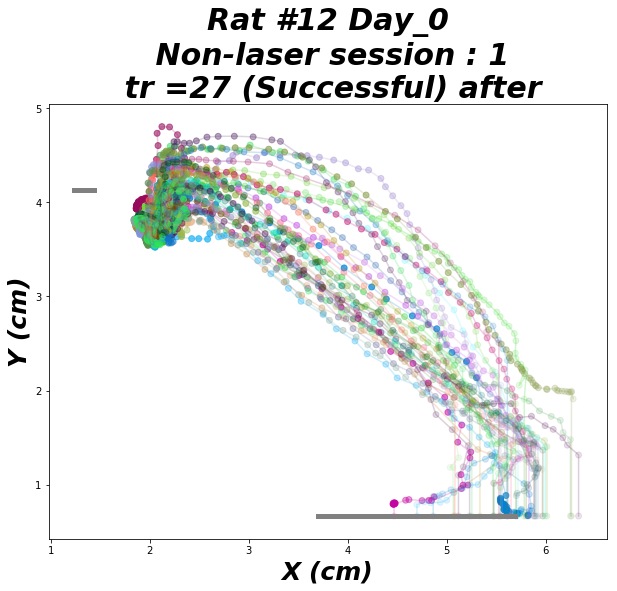

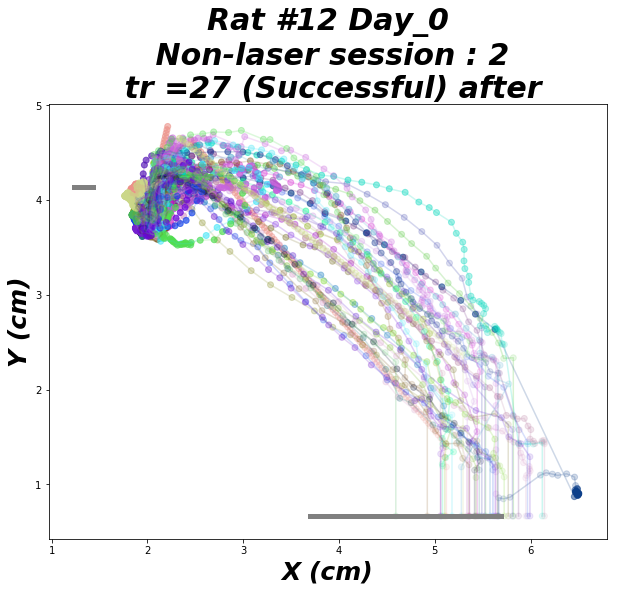

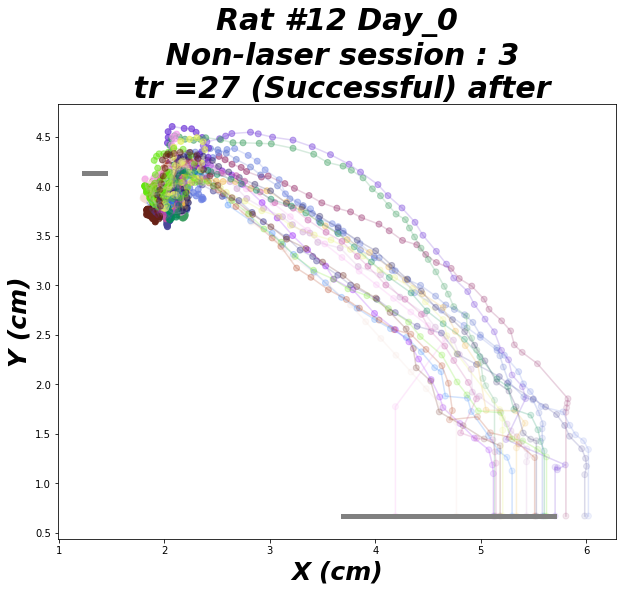

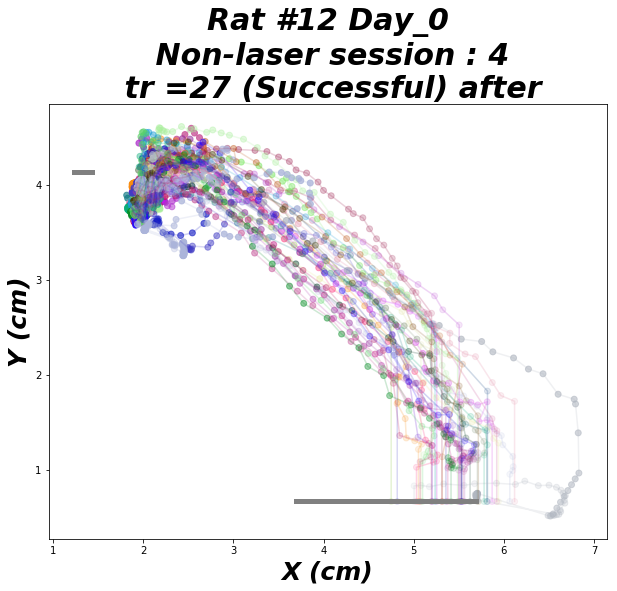

In [9]:

cfg['fp_trial'] = 375 # number of frames per trial
np.random.seed(10)
rat_no = 12
cfg['r_or_l'] = 'L'
# folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
folder_list = ['Day_0']
direct = pre_direct +'/6OHDA'+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
extension = ".csv"
cfg['p_cutoff'] = 0.8
cfg['max_speed'] = 50 # cm/s # the max speed of the rat derived from average trajectory 
cfg['max_delta_r_per_frame'] = cfg['max_speed']/cfg['fps']
print(cfg['max_delta_r_per_frame'])
cfg['max_delta_r_per_frame'] =cfg['max_delta_r_per_frame']
cfg['jitter_proximity_thresh_rho'] = 0.7 # the acceptable jitter in r coordinate to be considered as the samr jump
cfg['thresh_adjust'] = 1/5 # if there are 5 jemped points the threshold is <cfg['jitter_proximity_thresh_rho']>
cfg['jitter_proximity_thresh_phi'] = 30/180*np.pi
print(cfg['jitter_proximity_thresh_phi'])
m = 27
for folder in folder_list:
    files_list_DLC = list_all_files(direct+folder+'/DLC/','.csv')
    files_list_LED = list_all_files(direct+folder+'/LED/','.csv')
    for i in range(len(files_list_DLC)):
#     for i in range(1,2):
        print(files_list_DLC[i])
        df = read_DLC_csv(files_list_DLC[i],cfg['fp_trial'])
        df_LED = read_LED_csv(files_list_LED[i],len(df.index))
        where_plot,what_plot = [0],0
        body_part = cfg['body_part_list'][where_plot]
        path = direct+folder
        session = extract_epochs(df,df_LED, cfg['r_or_l'],path,folder,cfg['fp_trial'],body_part,cfg['frame_height'],cfg['n_timebin'],
                                 cfg['velocity_mask'],cfg['p_cutoff'],cfg['pad_thresh'],cfg['max_delta_r_per_frame'],cfg['pad_length_cm'],cfg['t_s'],cfg['max_delta_r_per_frame'])

        failed = Failed(session)
        successful = Successful(session)    

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)
        ax = plt.subplot(111)
        
        for j in range (successful.n_trials-1):
#         for j in range (m,m+1):

            successful.epochs_x[j,successful.likelihood[j] < cfg['p_cutoff']] = -1
            overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
            alphas = np.linspace(0.1, 1, len(overall_ind))
            rgba_colors = np.zeros((len(overall_ind),4))
            rgba_colors[:,:-1] = np.random.random((3))
            rgba_colors[:, 3] = alphas
            plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
            plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )
        plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
        plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

        plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-laser session : "+str(i+1)+"\n tr ="+str(m)+" (Successful) after").set_fontproperties(font)
        plt.ylabel("Y (cm)").set_fontproperties(font_label)
        plt.xlabel("X (cm)").set_fontproperties(font_label)
#         plt.legend(fontsize = 10)
#         plt.xlim(1,6)
#         plt.ylim(3.5,7)
#         ax[1] = plt.subplot(122)
#         set_ticks(ax[1])
#         for i in range (0,failed.n_trials):
#             failed.epochs_x[i,failed.likelihood[i] < cfg['p_cutoff']] = -1 # remove frames with small likelihood
#             overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
#             alphas = np.linspace(0.1, 1, len(overall_ind))
#             rgba_colors = np.zeros((len(overall_ind),4))
#             rgba_colors[:,:-1] = np.random.random((3))
#             rgba_colors[:, 3] = alphas
#             plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )
#             plt.plot(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

#         plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
#         plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

#         plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-Laser session : "+str(i+1)+'\n (Failed)').set_fontproperties(font)
#         plt.ylabel("Y (cm)").set_fontproperties(font_label)
#         plt.xlabel("X (cm)").set_fontproperties(font_label)
# #         plt.legend(fontsize = 10)
# #         plt.xlim(1,7)
# #         plt.ylim(3.5,7.5)
#         set_ticks(ax[1])
        plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_successful_session = '+str(i+1)+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)

# Mean trajectory 

t_s 10
# jitter in DLC  =  413
t_s 10
# jitter in DLC  =  240
 succeeded =  41 
 failed =  0 
 pad miss detections =  0
 max trial time =  776.0  ms 
 min trial time =  96.0  ms


<ErrorbarContainer object of 3 artists>

<Figure size 432x288 with 0 Axes>

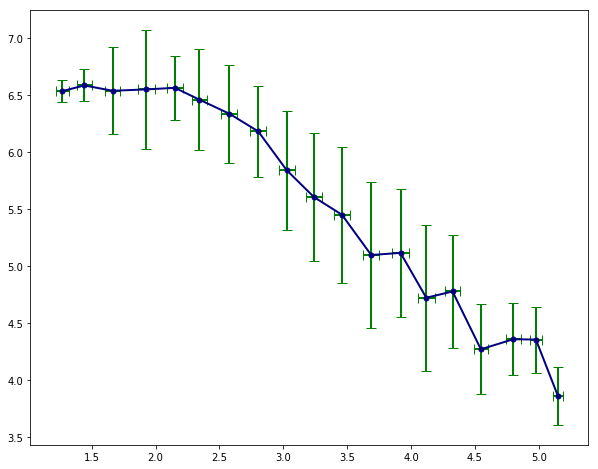

In [39]:
rat_no = 12; spont = "n"; folder = "Day_-1"
folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
direct = pre_direct +'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse

i = 0
files_list_DLC = list_all_files(direct+folder+'/DLC','.csv')
files_list_LED = list_all_files(direct+folder+'/LED','.csv')
path = direct+folder+'/DLC/'+files_list_DLC[i]
df = read_DLC_csv(direct+folder+'/DLC/'+files_list_DLC[i],cfg['fp_trial'])
df_LED = read_LED_csv(direct+folder+'/LED/'+files_list_LED[i],len(df.index))
where_plot,what_plot = [0],0
body_part = cfg['body_part_list'][where_plot]
session = extract_opto_epochs(df,df_LED,path,file_name,folder,cfg['fp_trial'],body_part,cfg['frame_height'])

failed = Failed(session)
successful = Successful(session)
print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
print(" max trial time = ", successful.max_time/cfg['fps']*1000 ," ms", "\n min trial time = ", successful.min_time/cfg['fps']*1000 ," ms")

epochs_x = successful.epochs_x
epochs_y = successful.epochs_y
cfg['n_grid'] = 20

trials = find_mean_trajectory(cfg['n_grid'], epochs_x, epochs_y)
plt.figure(2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)
        
plt.errorbar(trials.x,trials.y,  trials.err_y, trials.err_x,  marker = 'o',
             markersize=5, linewidth=2, capsize=5, capthick=1, color = 'navy', ecolor='g')
# plt.errorbar(trials.x,trials.y, trials.conf_inter_y.T, trials.conf_inter_x.T , marker = 'o',
#              markersize=5, linewidth=2, capsize=5, capthick=1, color = 'navy', ecolor='g')
plt.plot([lever_x],[lever_y], marker='o',markersize=20,c = 'r',label = "Lever")
plt.title("Rat #"+str(rat_no)+" "+folder+"\n session : "+str(i+1)).set_fontproperties(font)
plt.ylabel("Y (cm)").set_fontproperties(font_label)
plt.xlabel("X (cm)").set_fontproperties(font_label)
plt.legend(fontsize = 10)
plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_session = '+str(i+1)+
             '.png',bbox_inches='tight',orientation='landscape',dpi=200)



# jitter removal using likelihood

0.2
0.5235987755982988
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_182008_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
n trials =  43


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:435: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


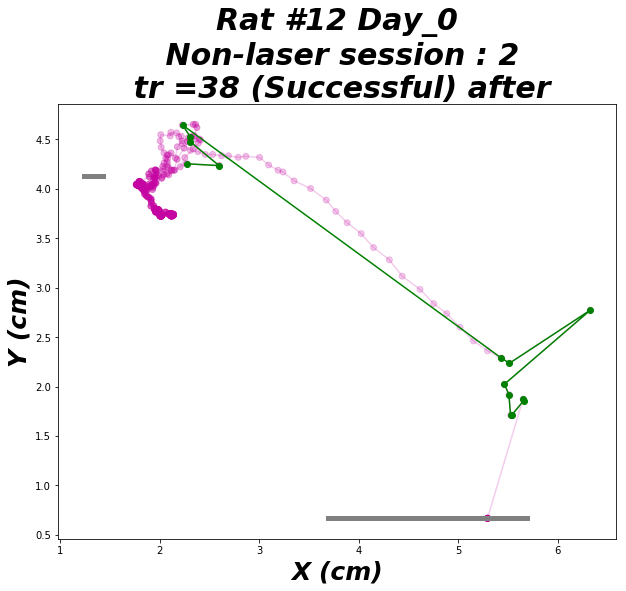

In [92]:

def correct_lasting_labeling_jitter(epochs_x, epochs_y,likelihood,to_keep, cfg['max_delta_r_per_frame'],t,cfg['fp_trial']):
    ''' correct the detections exceeding the max speed of the mouse (chekcing for r) with
        extrapolation with a straight line. Thus enforcing corrections to be dependent on early detections.
        for early jitters t extra points are provided before time zero if the paw is definitly at pad proximity by 
        <set_points_around_the_pad> function.
        '''
    count = 0
    for i in range(epochs_x.shape[0]): # go over trials
#     for i in range(m,m+1): # go over single trial
        x_copy = np.copy(epochs_x[i,likelihood[i] > cfg['p_cutoff']]) 
        y_copy = np.copy(epochs_y[i,likelihood[i] > cfg['p_cutoff']]) 
        if len(x_copy) < cfg['fp_trial']/4: 
            to_keep[i] = False
            continue
        shifted_x = shift((x_copy), 1, cval=0) #  shifts in a periodic manner, hence the next line
        shifted_x[0] = shifted_x[1] # set the shifted value 
        deltas_before_x = np.copy(shifted_x - x_copy)

        shifted_y = shift((y_copy), 1, cval=0) # np.roll shifts in a periodic manner, hence the next line
        shifted_y[0] = shifted_y[1] # set the shifted value 
        deltas_before_y =  np.copy(shifted_y - y_copy)
        
        x,y,deltas_x,deltas_y = set_points_around_the_pad(x_copy,y_copy,
                                                        deltas_before_x, deltas_before_y,t)
#         print(epochs_x[i])
#         print(x)
        rho,phi = cart2pol(deltas_x,deltas_y) # we have the displacement vector in polar coordinates
        ind, = np.where(rho > cfg['max_delta_r_per_frame']) # find the jumps
#         print("ind",ind)
        ind = ind[ind > t] # leave room for having reference before the jump
#         if len(ind) > 0: 
#             print("x",x[ind[0]-1:ind[-1]+1])
#             print("y",y[ind[0]-1:ind[-1]+1])
#             print("rho",rho[ind[0]-1:ind[-1]+1])
#         print("delta",deltas_before_x[m,ind[0]-1:ind[-1]+1])
        if len(ind) >= 2: # since we're checking for back and forths we need couples            
            for j in range (0,len(ind)-1):
#                 print("j",ind[j] , ind[j+1])
#                 print("delta rho",rho[ind[j]] - rho[ind[j+1]])
#                 print("delta phi",(abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi))*180/np.pi)
                if abs(rho[ind[j]] - rho[ind[j+1]]) < cfg['jitter_proximity_thresh_rho'] and abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi) < cfg['jitter_proximity_thresh_phi']: 
                ## check to see if there is an approximatly same size backward jump to the correct path from this jump
                    print("in")
                    # referece provided by average of t points before the jump
                    ref_av_x = np.sum(x[ind[j]-t:ind[j]-1])/ len((x[ind[j]-t:ind[j]-1])) 
                    ref_av_y = np.sum(y[ind[j]-t:ind[j]-1])/ len((y[ind[j]-t:ind[j]-1]))
                    n_points_to_correct = len((x[ind[j]:ind[j+1]])) # number of points included in the jump
                    # average of jumped points provided by average of points included in the jump
                    av_x = np.sum(x[ind[j]:ind[j+1]])/ n_points_to_correct
                    av_y = np.sum(y[ind[j]:ind[j+1]])/n_points_to_correct
                    
                    r_ref,theta_ref = cart2pol(ref_av_x,ref_av_y)# get a vector pointing to reference average  
                    r_av,theta_av = cart2pol(av_x,av_y)# get a vector pointing to jump average 
#                     print("Rs",r_av,r_ref)
#                     print("thetas",theta_av,theta_ref)
                    print((n_points_to_correct*cfg['jitter_proximity_thresh_rho']*cfg['thresh_adjust']))
                    print((n_points_to_correct*cfg['jitter_proximity_thresh_phi']*cfg['thresh_adjust']/2))

                    # since points are corrected as we go. If this is not a forth and back, the reference and jump vectors would be almost the same
                    if abs(r_av - r_ref) <  (n_points_to_correct
                    *cfg['jitter_proximity_thresh_rho']*cfg['thresh_adjust']) and abs(theta_av - theta_ref) < (n_points_to_correct
                    *cfg['jitter_proximity_thresh_phi']*cfg['thresh_adjust']/2):
                        continue # if these criteria aren't met this not a forth and back of a jump but the back and forth of two consecutive jumps
                    
                    p1 = np.array([x[ind[j]-1],y[ind[j]-1]])
                    p2 = np.array([x[ind[j+1]],y[ind[j+1]]])
                    print("points", p1,p2)
                    correction_x,correction_y = equidistant_points_between(p1, p2, n_p_between = ind[j+1]- ind[j])# extrapolate the correction for jumped points using
                     
                    count += 1
                    ind = ind - t
#                     print(y_copy[ind[j]:ind[j+1]])
                    x_copy[ind[j]:ind[j+1]] = correction_x
                    y_copy[ind[j]:ind[j+1]] = correction_y
#                     print(y_copy[ind[j]:ind[j+1]])
        epochs_x[i,likelihood[i] > cfg['p_cutoff']] = x_copy
#         print("epochs",epochs_x[i,likelihood[i] > cfg['p_cutoff']])
        epochs_y[i,likelihood[i] > cfg['p_cutoff']] = y_copy
    print("# second order jitter :", count)
    return epochs_x, epochs_y,to_keep
def extract_epochs(df,df_LED, cfg['r_or_l'],path,folder,cfg['fp_trial'],body_part,cfg['frame_height'],cfg['n_timebin'],cfg['velocity_mask'],
                   cfg['p_cutoff'],cfg['pad_thresh'],cfg['max_delta_r_per_frame'],cfg['pad_length_cm'],cfg['t_s'],cfg['max_delta_r_per_frame']):
    '''extract epochs of one session 
        return the session class containing all the info for the session'''

    scale_pix_to_cm = set_pix_scale(df_LED,cfg['pad_length_cm'])
#     variable_x , variable_y = average_position(df,body_part,cfg['r_or_l'],cfg['fp_trial'],scale_pix_to_cm)
    x , y, likelihood = position(df,body_part,cfg['r_or_l'],scale_pix_to_cm)
    y = cfg['frame_height']*scale_pix_to_cm - y # image has decreasing y instead of increasing

    session = Session(folder)
    session.set_epochs(x, y,likelihood, cfg['fp_trial']) # reshapes to separate trials  
    session.set_properties(path,df_LED, cfg['r_or_l'], cfg['fp_trial'],cfg['pad_thresh'],cfg['frame_height'])
    session.apply_pad_constraint(cfg['p_cutoff'],cfg['r_or_l'])
    session.epochs_x, session.epochs_y = correct_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,cfg['cfg['max_delta_r_per_frame']'], cfg['t_s'])
#     session.epochs_x, session.epochs_y,session.to_keep = correct_lasting_labeling_jitter(session.epochs_x, session.epochs_y,
#                                                 session.likelihood,session.to_keep,cfg['max_delta_r_per_frame'], cfg['t_s'],cfg['fp_trial'])
#     session.correct_small_likelihoods(cfg['p_cutoff'],cfg['cor_t_prox_thresh'])
    session.calculate_steps_traveled(cfg['max_delta_r_per_frame']) # get the steps before masking 
    session.calculate_velocity(cfg['n_timebin'])
#     session.discard_unacceptable_trials()
#     session.mask_beginnings_and_end_of_trials(cfg['velocity_mask'],cfg['max_delta_r_per_frame'])
    print("n trials = ",session.n_trials)
    return session

cfg['fp_trial'] = 375 # number of frames per trial
np.random.seed(10)
rat_no = 12
cfg['r_or_l'] = 'L'
# folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
folder_list = ['Day_0']
direct = pre_direct +'/6OHDA'+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
extension = ".csv"
cfg['p_cutoff'] = 0.8
cfg['max_speed'] = 50 # cm/s # the max speed of the rat derived from average trajectory 
cfg['max_delta_r_per_frame'] = cfg['max_speed']/cfg['fps']
print(cfg['max_delta_r_per_frame'])
cfg['max_delta_r_per_frame'] =cfg['max_delta_r_per_frame']
cfg['jitter_proximity_thresh_rho'] = 0.7 # the acceptable jitter in r coordinate to be considered as the samr jump
cfg['thresh_adjust'] = 1/5 # if there are 5 jemped points the threshold is <cfg['jitter_proximity_thresh_rho']>
cfg['jitter_proximity_thresh_phi'] = 30/180*np.pi
print(cfg['jitter_proximity_thresh_phi'])
m = 38
for folder in folder_list:
    files_list_DLC = list_all_files(direct+folder+'/DLC/','.csv')
    files_list_LED = list_all_files(direct+folder+'/LED/','.csv')
#     for i in range(len(files_list_DLC)):
    for i in range(1,2):
        print(files_list_DLC[i])
        df = read_DLC_csv(files_list_DLC[i],cfg['fp_trial'])
        df_LED = read_LED_csv(files_list_LED[i],len(df.index))
        where_plot,what_plot = [0],0
        body_part = cfg['body_part_list'][where_plot]
        path = direct+folder
        session = extract_epochs(df,df_LED, cfg['r_or_l'],path,folder,cfg['fp_trial'],body_part,cfg['frame_height'],cfg['n_timebin'],
                                 cfg['velocity_mask'],cfg['p_cutoff'],cfg['pad_thresh'],cfg['max_delta_r_per_frame'],cfg['pad_length_cm'],cfg['t_s'],cfg['max_delta_r_per_frame'])
        
        failed = Failed(session)
        successful = Successful(session)
        
#         successful.epochs_x, successful.epochs_y = correct_lasting_labeling_jitter(successful.epochs_x, successful.epochs_y,
#                                                 successful.likelihood,cfg['max_delta_r_per_frame'], cfg['t_s'],cfg['fp_trial'])
#         successful.mask_beginnings_and_end_of_trials(cfg['velocity_mask'],cfg['max_delta_r_per_frame'])

#         print(successful.n_trials, session.n_trials, failed.n_trials)

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)
        ax = plt.subplot(111)
#         successful.correct_small_likelihoods(cfg['p_cutoff'],cfg['cor_t_prox_thresh'])

#         for j in range (successful.n_trials-1):
        for j in range (m,m+1):

#             successful.epochs_x[j,successful.likelihood[j] < cfg['p_cutoff']] = -1
#             if len(np.where((successful.epochs_y[j,:] < session.lever_y[0]) & (successful.epochs_x[j,:] < 2.5)& (successful.epochs_x[j,:] > 1.5))[0]) != 0:
#                 print(j)

            overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
            low_p_ind, = np.where(successful.likelihood[j] < cfg['p_cutoff'] )
            alphas = np.linspace(0.1, 1, len(overall_ind))
            rgba_colors = np.zeros((len(overall_ind),4))
            rgba_colors[:,:-1] = np.random.random((3))
            rgba_colors[:, 3] = alphas
            plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
            plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )
            plt.plot(successful.epochs_x[j,low_p_ind],successful.epochs_y[j,low_p_ind], '-o',color = 'g' )

#         print(successful.pad_off_t)
        plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
        plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

        plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-laser session : "+str(i+1)+"\n tr ="+str(m)+" (Successful) after").set_fontproperties(font)
        plt.ylabel("Y (cm)").set_fontproperties(font_label)
        plt.xlabel("X (cm)").set_fontproperties(font_label)
#         plt.legend(fontsize = 10)
#         plt.xlim(1,6)
#         plt.ylim(3.5,7)
#         ax[1] = plt.subplot(122)
#         set_ticks(ax[1])
#         for i in range (0,failed.n_trials):
#             failed.epochs_x[i,failed.likelihood[i] < cfg['p_cutoff']] = -1 # remove frames with small likelihood
#             overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
#             alphas = np.linspace(0.1, 1, len(overall_ind))
#             rgba_colors = np.zeros((len(overall_ind),4))
#             rgba_colors[:,:-1] = np.random.random((3))
#             rgba_colors[:, 3] = alphas
#             plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )
#             plt.plot(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

#         plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
#         plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

#         plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-Laser session : "+str(i+1)+'\n (Failed)').set_fontproperties(font)
#         plt.ylabel("Y (cm)").set_fontproperties(font_label)
#         plt.xlabel("X (cm)").set_fontproperties(font_label)
# #         plt.legend(fontsize = 10)
# #         plt.xlim(1,7)
# #         plt.ylim(3.5,7.5)
#         set_ticks(ax[1])
        plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_successful_session = '+str(i+1)+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)

# jitter removal without likelihood

In [57]:
def set_points_around_the_pad(x,y,delta_x,delta_y,pad_off_t,t,pad_x,pad_y):
    ''' concatenate t elements before pad off  '''
    cfg['t_s']tart = 0
    if pad_off_t < t:
        
#         print("paw at pad off",x[pad_off_t], y[pad_off_t])
        # check to see if the paw leaves the pad at the pad proximity
        if (pad_x[0] < x[pad_off_t] < pad_x[1]) and (pad_y[0] < y[pad_off_t] < pad_y[1]):
#             print("voila")
            x = np.hstack((np.repeat(x[0],t),x)) 
            y = np.hstack((np.repeat(y[0],t),y)) 
            delta_x = np.hstack((np.zeros((t)),delta_x)) 
            delta_y = np.hstack((np.zeros((t)),delta_y)) 
            
            cfg['t_s']tart = t
    return x,y,delta_x,delta_y,cfg['t_s']tart
def correct_lasting_labeling_jitter(epochs_x, epochs_y,pad_off_t, cfg['max_delta_r_per_frame'],t,cfg['fp_trial'],pad_x,pad_y):
    ''' correct the detections exceeding the max speed of the mouse (chekcing for r) with
        extrapolation of previous time step velocities. Thus enforcing corrections to be dependent on early detections.
        for early jitters t extra points are provided before time zero if the paw is definitly at pad proximity by 
        <set_points_around_the_pad> function. This function was written before using likelihoods.
        '''
#     epochs_x = epochs_x.reshape(int(len(epochs_x)/cfg['fp_trial']),cfg['fp_trial'])# reshape to separate trials
#     epochs_y = epochs_y.reshape(int(len(epochs_y)/cfg['fp_trial']),cfg['fp_trial'])
    x_copy = np.copy(epochs_x) 
    y_copy = np.copy(epochs_y) 
    shifted_x = np.roll((x_copy), 1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_x[:,0] = shifted_x[:,1] # set the shifted value 
    deltas_before_x = np.copy(shifted_x - x_copy)

    shifted_y = np.roll((y_copy), 1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_y[:,0] = shifted_y[:,1] # set the shifted value 
    deltas_before_y =  np.copy(shifted_y - y_copy)
    count = 0
#     for i in range(epochs_x.shape[0]): # go over trials
    for i in range(m,m+1): # go over single trial
#         print(deltas_before_y.shape,pad_off_t.shape)
        x,y,deltas_x,deltas_y,cfg['t_s']tart = set_points_around_the_pad(epochs_x[i],epochs_y[i],
                                                        deltas_before_x[i], deltas_before_y[i],pad_off_t[i],t,pad_x,pad_y)
        
        rho,phi = cart2pol(deltas_x,deltas_y) # we have the displacement vector in polar coordinates
#         rho,phi = cart2pol(deltas_before_x[i],deltas_before_y[i]) # we have the displacement vector in polar coordinates

        ind, = np.where(rho > cfg['max_delta_r_per_frame']) # find the jumps
#         print("ind",ind)
        ind = ind[ind > t] # leave room for having velocity reference before the jump
#         if len(ind)>0: 
#             print("x",x[ind[0]-1:ind[-1]+1])
#             print("rho",rho[ind[0]-1:ind[-1]+1])
#         print("delta",deltas_before_x[m,ind[0]-1:ind[-1]+1])
        if len(ind) > 2: # since we're checking for back and forths we need couples            
            for j in range (0,len(ind)-1):
                print("j",ind[j] , ind[j+1])
                print("delta rho",rho[ind[j]] - rho[ind[j+1]])
                print("delta phi",(abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi))*180/np.pi)
                if abs(rho[ind[j]] - rho[ind[j+1]]) < cfg['jitter_proximity_thresh_rho'] and abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi) < cfg['jitter_proximity_thresh_phi']: 
                ## check to see if there is an approximatly same size backward jump to the correct path from this jump
                    print("in")
                    # referece provided by average of t points before the jump
                    ref_av_x = np.sum(x[ind[j]-t:ind[j]-1])/ len((x[ind[j]-t:ind[j]-1])) 
                    ref_av_y = np.sum(y[ind[j]-t:ind[j]-1])/ len((y[ind[j]-t:ind[j]-1]))
                    n_points_to_correct = len((x[ind[j]:ind[j+1]])) # number of points included in the jump
                    # average of jumped points provided by average of points included in the jump
                    av_x = np.sum(x[ind[j]:ind[j+1]])/ n_points_to_correct
                    av_y = np.sum(y[ind[j]:ind[j+1]])/n_points_to_correct
                    
                    r_ref,theta_ref = cart2pol(ref_av_x,ref_av_y)# get a vector pointing to reference average  
                    r_av,theta_av = cart2pol(av_x,av_y)# get a vector pointing to jump average 
#                     print("Rs",r_av,r_ref)
#                     print("thetas",theta_av,theta_ref)
#                     print((n_points_to_correct*cfg['jitter_proximity_thresh_phi']*cfg['thresh_adjust']))
                    # since points are corrected as we go. If this is not a forth and back, the reference and jump vectors would be almost the same
                    if abs(r_av - r_ref) <  (n_points_to_correct
                    *cfg['jitter_proximity_thresh_rho']*cfg['thresh_adjust']) and abs(theta_av - theta_ref) < (n_points_to_correct
                    *cfg['jitter_proximity_thresh_phi']*cfg['thresh_adjust']/2):
                        print("dismiss")
                        continue # if these criteria aren't met this not a forth and back of a jump but the back and forth of two consecutive jumps
                    # provide a velocity reference from reference points before the jump
                    velocity_x = np.sum(deltas_before_x[ind[j]-t:ind[j]-1])/(t-1)
                    velocity_y = np.sum(deltas_before_y[ind[j]-t:ind[j]-1])/(t-1)
                    # extrapolate the correction for jumped points using the reference velocity
                    correction_x = (np.arange(ind[j+1]-ind[j])+1)*velocity_x + x[ind[j]-1]
                    correction_y = (np.arange(ind[j+1]-ind[j])+1)*velocity_y + y[ind[j]-1]
#                     print("wrong",x[ind[j]:ind[j+1]],y[ind[j]:ind[j+1]])
                    count += 1
                    ind = ind - cfg['t_s']tart
                    epochs_x[i,ind[j]:ind[j+1]] = correction_x
                    epochs_y[i,ind[j]:ind[j+1]] = correction_y
#                     print("Correct",epochs_x[i,ind[j]:ind[j+1]],correction_y)
#         print(epochs_x[m,ind[0]-1:ind[-1]+1])
    print("# second order jitter :", count)
#     return epochs_x.flatten().reshape(-1,1), epochs_y.flatten().reshape(-1,1)
    return epochs_x, epochs_y

def correct_labeling_jitter(x, y, cfg['max_delta_r_per_frame'],cfg['t_s'],cfg['fp_trial']):
    ''' correct the single point jitters in detections exceeding the max speed of the mouse with
        the average of before and after time stamps 
        '''

    x_copy = np.copy(x)
    y_copy = np.copy(y)
    xx = np.concatenate((np.repeat(x_copy[:,0].reshape(-1,1),cfg['t_s']+1,axis = 1),x_copy,
                         np.repeat(x_copy[:,-1].reshape(-1,1),cfg['t_s']+1,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
    yy = np.concatenate((np.repeat(y_copy[:,0].reshape(-1,1),cfg['t_s']+1,axis = 1),y_copy,
                         np.repeat(y_copy[:,-1].reshape(-1,1),cfg['t_s']+1,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition

    
    shifted_x = np.roll(np.copy(x_copy), 1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_x[:,0] = shifted_x[:,1] # set the shifted value 
    deltas_before_x = shifted_x - x_copy
    shifted_x = np.roll(np.copy(x_copy), -1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_x[:,-1] = shifted_x[:,-2] # set the shifted value equal to the boundary
    deltas_after_x = x_copy -  shifted_x

    shifted_y = np.roll(np.copy(y_copy), 1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_y[:,0] = shifted_y[:,1] # set the shifted value 
    deltas_before_y = shifted_y - y_copy
    shifted_y = np.roll(np.copy(y_copy), -1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_y[:,-1] = shifted_y[:,-2] # set the shifted value equal to the boundary
    deltas_after_y = y_copy -  shifted_y

    deltas_after = np.sqrt(np.power(deltas_after_x,2)+np.power(deltas_after_y,2))
    deltas_before = np.sqrt(np.power(deltas_before_x,2)+np.power(deltas_before_y,2))
    ind_bef = np.where(np.absolute(deltas_before) > cfg['max_delta_r_per_frame'])
    ind_aft = np.where(np.absolute(deltas_after) > cfg['max_delta_r_per_frame'])


    bool_ind = np.logical_and(np.absolute(deltas_after) > cfg['max_delta_r_per_frame'],np.absolute(deltas_before) > cfg['max_delta_r_per_frame'])
    ind_row,ind_col = np.where(bool_ind == True)
    ind = np.vstack((ind_row,ind_col+cfg['t_s']+1)).T # tuples of indices (col+cfg['t_s']+1 bc the array is sandwitched to avoid boundary prob)
    if len(ind_row) > 0: # if jumped in detection set to the mean of <cfg['t_s']> previous and next detections
        x_copy[ind_row,ind_col] = np.hstack([np.average(xx[i,j-cfg['t_s']-1:j-1])+np.average(xx[i,j+1:j+cfg['t_s']+1]) for i,j in ind])/2
        y_copy[ind_row,ind_col] = np.hstack([np.average(yy[i,j-cfg['t_s']-1:j-1])+np.average(yy[i,j+1:j+cfg['t_s']+1]) for i,j in ind])/2
        print("# jitter in DLC  = ", len(ind_row))                                     

    return x_copy,y_copy

cfg['max_speed'] = 50 # cm/s # the max speed of the rat derived from average trajectory 
cfg['max_delta_r_per_frame'] = cfg['max_speed']/cfg['fps']
print(cfg['max_delta_r_per_frame'])
cfg['max_delta_r_per_frame'] =cfg['max_delta_r_per_frame']
cfg['jitter_proximity_thresh_rho'] = 0.2 # the acceptable jitter in r coordinate to be considered as the samr jump
cfg['thresh_adjust'] = 1/5 # if there are 5 jemped points the threshold is <cfg['jitter_proximity_thresh_rho']>
cfg['jitter_proximity_thresh_phi'] = 30/180*np.pi


cfg['fp_trial'] = 375 # number of frames per trial
np.random.seed(10)
rat_no = 12
cfg['r_or_l'] = 'L'
# folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
folder_list = ['Day_0']
direct = pre_direct +'/6OHDA'+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
extension = ".csv"

m = 25
for folder in folder_list:
    files_list_DLC = list_all_files(direct+folder+'/DLC/','.csv')
    files_list_LED = list_all_files(direct+folder+'/LED/','.csv')
    for i in range(1,2):#len(files_list_DLC)):
#     for i in range(len(files_list_DLC)):

        print(files_list_DLC[i])
        df = read_DLC_csv(files_list_DLC[i],cfg['fp_trial'])
        df_LED = read_LED_csv(files_list_LED[i],len(df.index))
        where_plot,what_plot = [0],0
        body_part = cfg['body_part_list'][where_plot]
        path = direct+folder
        cfg['jitter_proximity_thresh_rho'] = 0.2
        cfg['max_delta_r_per_frame'] = cfg['max_delta_r_per_frame']
        session = extract_opto_epochs(df,df_LED, cfg['r_or_l'],path,folder,cfg['fp_trial'],body_part,cfg['frame_height'],cfg['n_timebin'],
                                 cfg['velocity_mask'])
        session.discard_unacceptable_trials()
        session.mask_beginnings_and_end_of_trials(cfg['velocity_mask'],cfg['max_delta_r_per_frame'])
        failed = Failed(session)
        successful = Successful(session)
#         print(successful.n_trials, session.n_trials, failed.n_trials)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
        ax[0] = plt.subplot(121)
        
        for j in range (m,m+1):#successful.n_trials-1):
#         for j in range (successful.n_trials-1):
#             print("pad off",successful.pad_off_t[j])
            overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
            alphas = np.linspace(0.1, 1, len(overall_ind))
            rgba_colors = np.zeros((len(overall_ind),4))
            rgba_colors[:,:-1] = np.random.random((3))
            rgba_colors[:, 3] = alphas
            plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
            plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

        plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
        plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

        plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-laser session : "+str(i+1)+"\n tr ="+str(m)+" (Successful) after").set_fontproperties(font)
        plt.ylabel("Y (cm)").set_fontproperties(font_label)
        plt.xlabel("X (cm)").set_fontproperties(font_label)
#         plt.legend(fontsize = 10)
#         plt.xlim(1,6)
#         plt.ylim(3.5,7)
        set_ticks(ax[0])
        ax[1] = plt.subplot(122)
        cfg['max_delta_r_per_frame'] = 6000
#         cfg['jitter_proximity_thresh_rho'] = 10
        session = extract_opto_epochs(df,df_LED, cfg['r_or_l'],path,folder,cfg['fp_trial'],body_part,cfg['frame_height'],cfg['n_timebin'],cfg['velocity_mask'])
        session.discard_unacceptable_trials()
        session.mask_beginnings_and_end_of_trials(cfg['velocity_mask'],cfg['max_delta_r_per_frame'])
        failed = Failed(session)
        successful = Successful(session)
#         print(successful.n_trials, session.n_trials, failed.n_trials)

        for j in range (m,m+1):#successful.n_trials-1):
#         for j in range (successful.n_trials-1):
#             print(successful.starts[j])
            overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
            alphas = np.linspace(0.1, 1, len(overall_ind))
            rgba_colors = np.zeros((len(overall_ind),4))
            rgba_colors[:,:-1] = np.random.random((3))
            rgba_colors[:, 3] = alphas

            plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
            plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

        plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
        plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')
        plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-laser session : "+str(i+1)+"\n tr ="+str(m)+" (Successful) before").set_fontproperties(font)
        plt.ylabel("Y (cm)").set_fontproperties(font_label)
        plt.xlabel("X (cm)").set_fontproperties(font_label)
#         plt.legend(fontsize = 10)
#         plt.xlim(1,6)
#         plt.ylim(3.5,7)
        set_ticks(ax[1])
#         for i in range (0,failed.n_trials):
#             overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
#             alphas = np.linspace(0.1, 1, len(overall_ind))
#             rgba_colors = np.zeros((len(overall_ind),4))
#             rgba_colors[:,:-1] = np.random.random((3))
#             rgba_colors[:, 3] = alphas
#             plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )


#         plt.plot([lever_x],[lever_y], marker='o',markersize=20,c = 'r',label = "Lever")
#         plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-Laser session : "+str(i+1)+'\n (Failed)').set_fontproperties(font)
#         plt.ylabel("Y (cm)").set_fontproperties(font_label)
#         plt.xlabel("X (cm)").set_fontproperties(font_label)
#         plt.legend(fontsize = 10)
#         plt.xlim(1,7)
#         plt.ylim(3.5,7.5)
#         set_ticks(ax[1])
#         plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_successful_session = '+str(i+1)+
#                      '.png',bbox_inches='tight',orientation='landscape',dpi=200)

0.2
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_182008_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv


TypeError: extract_epochs() missing 1 required positional argument: 'p_cutoff'

# Blah Blah

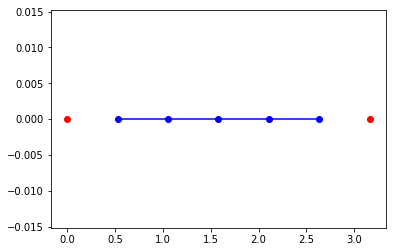

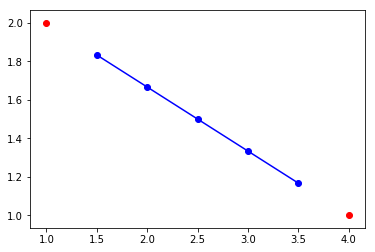

In [71]:
def R_rotation(phi): 
    ''' build rotation matrix R for rotaion of phi around z axis'''
    c, s = np.cos(phi), np.sin(phi)
    R = np.array(((c, s), (-s, c))) # rotation matrix
    return R
def put_n_points_in_between(p1,p2,n_p_between):
    ''' put n_p_between points between p1 and p2 points. Returns a set of x and ys. 
    The points are derived by rotation to put the line on x axis'''
    phi = np.arctan((p2[1]-p1[1])/(p2[0]-p1[0]))
    R = R_rotation(phi)
    p2_prime = np.matmul(R,p2-p1)
    x_p = np.linspace(0, p2_prime[0], num= n_p_between+1, endpoint=False) # produce n points on the line 
    plt.scatter([0,p2_prime[0]],[0,p2_prime[1]], c = 'r')

    points_prime = np.vstack((x_p[1:],np.zeros_like(x_p[1:])))
    plt.plot(points_prime[0,:],points_prime[1,:],'-o',c= 'b')

    points = np.matmul(R_rotation(-phi),points_prime)+p1.reshape(-1,1) # brings points to the original coordinate
    return points
def equidistant_points_between(p1, p2, n_p_between):
    x = np.linspace(p1[0], p2[0], n_p_between+1, endpoint=False)
    y = np.linspace(p1[1], p2[1], n_p_between+1, endpoint=False)
    return np.vstack((x[1:],y[1:]))
p1 = np.array([1,2])
p2 = np.array([4,1])
# plt.figure(1)
points = put_n_points_in_between(p1,p2,5)
# points = equidistant_points_between(p1, p2, 5)
plt.figure(2)
plt.scatter([p1[0],p2[0]],[p1[1],p2[1]], c = 'r')
plt.plot(points[0,:],points[1,:],'-o',c= 'b')





In [16]:
xx = np.arange(64).reshape(8,8)
print(xx)
mask = xx>5
print(mask)
print(xx[mask])
# conc_t = 2
# shifted_forward_x = np.concatenate((np.repeat(xx[:,0].reshape(-1,1),conc_t,axis = 1),xx[:,:-conc_t]),axis = 1) # repeat boundaries to avoid boundary condition
# print(shifted_forward_x)
# print(shifted_forward_x.shape)
# shifted_back_x = np.concatenate((xx[:,conc_t:],np.repeat(xx[:,-1].reshape(-1,1),conc_t,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
# print(shifted_back_x)
# print(shifted_back_x.shape)
# velocity = (shifted_back_x - shifted_forward_x)
# print(velocity)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]
[[False False False False False False  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63]
